# What's here

- using conda venv lets_drift_env_V1

- Evaluate the latents and corresponding firing neurons. 


In [1]:
# Import necessary libraries
import pandas as pd
import json
import re
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#import seaborn as sns
#from scipy import stats

# Preprocessing: What data is worth looking at? 

The interesting data: the ones where the unsteered answer is correct, but the steered answer IS or IS NOT. 


In [3]:
def parse_jsonl_file(folder_path, file_number=0):
    """
    Parse a specific JSONL file from a folder into a pandas DataFrame.
    
    Args:
        folder_path (str): Path to the folder containing JSONL files
        file_number (int): File number to read (0-based index)
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed JSON data
    """
    try:
        # Get all JSONL files from folder (excluding metadata.jsonl)
        jsonl_files = [f for f in os.listdir(folder_path) 
                      if f.endswith('.jsonl') and f != 'metadata.jsonl']
        jsonl_files.sort(key=lambda x: int(re.search(r'ID(\d+)', x).group(1)))
        
        if file_number >= len(jsonl_files):
            raise ValueError(f"File number {file_number} not found in folder")
        
        target_file = os.path.join(folder_path, jsonl_files[file_number])
        
        # Read all lines from the file
        with open(target_file, 'r') as file:
            lines = file.readlines()
        
        # Parse each JSON line separately
        data_parts = []
        for line in lines:
            try:
                data_parts.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Failed to parse JSON line: {e}")
                print(f"Problematic JSON string: {line[:100]}...")
                continue
        
        # Combine all parts into a single dictionary
        combined_data = {}
        for part in data_parts:
            combined_data.update(part)
        
        # Convert to DataFrame and return
        return pd.DataFrame([combined_data])

    except Exception as e:
        print(f"Error processing data: {e}")
        return None




In [4]:
# Check first line of parsed file to df:
df = parse_jsonl_file('77to82Hotpot_negative_v2_fixed', file_number=0)
if df is not None:
    print(df)

   Prompt_ID                                             Prompt  Ref_answer  \
0         77  Alvaro Mexia had a diplomatic mission with whi...  Apalachees   

                                  Answer_No_Steering  \
0  \n\nAlvaro Mexia had a diplomatic mission with...   

                    Output_Tokens_Answer_No_Steering  \
0  [109, 1875, 52675, 8197, 740, 1093, 476, 49124...   

               Activations_Answer_No_Steering_layer9  \
0  [[2.9538607597351074, -1.0386548042297363, 0.5...   

              Activations_Answer_No_Steering_layer20  \
0  [[3.309230327606201, -0.7437329292297363, 2.09...   

              Activations_Answer_No_Steering_layer31  \
0  [[-1.4490699768066406, 0.07230710983276367, 0....   

           SAE_Activations_Answer_No_Steering_layer9  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

          SAE_Activations_Answer_No_Steering_layer20  ...  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  ...   

             SAE_Activations_Answer_Stee

In [5]:
def find_lowest_id_file(folder_path):
    """
    Find the file with the lowest ID number matching the pattern 'IDn_out.jsonl'
    in the specified folder.
    
    Args:
        folder_path (str): Path to the folder containing JSONL files
        
    Returns:
        str: Filename with lowest ID, or None if no matching files found
    """
    try:
        # Get all files matching the pattern ID*_out.jsonl
        out_files = [f for f in os.listdir(folder_path) 
                    if f.endswith('_out.jsonl') and f.startswith('ID')]
        
        if not out_files:
            print("No files matching pattern 'IDn_out.jsonl' found in folder")
            return None
            
        # Extract ID numbers using regex and convert to integers
        id_numbers = []
        for filename in out_files:
            match = re.search(r'ID(\d+)_out\.jsonl', filename)
            if match:
                id_numbers.append(int(match.group(1)))
        
        if not id_numbers:
            print("Could not extract ID numbers from filenames")
            return None
            
        # Find lowest ID number
        lowest_id = min(id_numbers)
        
        # Get corresponding filename
        lowest_file = f'ID{lowest_id}_out.jsonl'
        
        print(f"Found lowest ID file: {lowest_file}")
        return lowest_file

    except Exception as e:
        print(f"Error processing folder: {e}")
        return None

# Example usage:


In [6]:
lowest_file = find_lowest_id_file('77to82Hotpot_negative_v2_fixed')

Found lowest ID file: ID77_out.jsonl


In [7]:
def get_correct_unsteered_cases(folder_path):
    """
    Get all cases where the unsteered answer was correct (evaluation starts with 1)
    from a folder of JSONL files.
    
    Args:
        folder_path (str): Path to the folder containing JSONL files
    
    Returns:
        pandas.DataFrame: DataFrame containing all cases where unsteered answer was correct
        list: List of Prompt_IDs where evaluation is missing
    """
    # Initialize an empty DataFrame and list for missing evaluations
    correct_cases = pd.DataFrame()
    missing_evaluations = []
    
    # Get all JSONL files from folder
    jsonl_files = [f for f in os.listdir(folder_path) 
                   if f.endswith('_out.jsonl') and f.startswith('ID')]
    
    # Sort files by ID number
    jsonl_files.sort(key=lambda x: int(re.search(r'ID(\d+)', x).group(1)))
    
    # Process each file
    for filename in jsonl_files:
        filepath = os.path.join(folder_path, filename)
        file_data = {}
        has_evaluation = False
        
        try:
            with open(filepath, 'r') as file:
                lines = file.readlines()
                
                # Process each line in the file
                for line in lines:
                    data = json.loads(line.strip())
                    # Update file_data with all fields from the line
                    file_data.update(data)
                    
                    # Check if this line contains evaluation
                    if "evaluation" in data:
                        has_evaluation = True
                        # Check if unsteered answer was correct (first position in evaluation)
                        if data["evaluation"][0] == "1":
                            correct_cases = pd.concat([correct_cases, 
                                                     pd.DataFrame([file_data])], 
                                                    ignore_index=True)
                
                # If no evaluation found, add to missing list
                if not has_evaluation:
                    missing_evaluations.append(filename)
                    
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            continue
    
    if missing_evaluations:
        print(f"\nFound {len(missing_evaluations)} files with missing evaluations:")
        for filename in missing_evaluations:
            print(f"- {filename}")
    
    return correct_cases, missing_evaluations

### CHOOSE FOLDER NAMES TO EVALUATE
- first, evaluate the file manually using EVAL_steered_jsonl_V2.ipynb to add the 'evaluation' column to the jsonl

In [8]:

def combine_folders_to_df(folder_paths):
    """
    Combine data from multiple folders into a single DataFrame.
    
    Args:
        folder_paths (list): List of paths to folders containing JSONL files
        
    Returns:
        pandas.DataFrame: Combined DataFrame containing all cases with correct unsteered answers
        dict: Dictionary mapping folder names to lists of missing evaluations
    """
    combined_df = pd.DataFrame()
    missing_evals_dict = {}
    
    for folder_path in folder_paths:
        # Get data from this folder
        folder_df, missing_evals = get_correct_unsteered_cases(folder_path)
        
        if folder_df is not None and not folder_df.empty:
            # Add folder name as a column to identify source
            folder_df['source_folder'] = folder_path
            
            # Concatenate with existing data
            combined_df = pd.concat([combined_df, folder_df], ignore_index=True)
            
        # Store missing evaluations for this folder
        if missing_evals:
            missing_evals_dict[folder_path] = missing_evals
            
        print(f"\nProcessed folder: {folder_path}")
        print(f"Added {len(folder_df) if folder_df is not None else 0} cases")
        
    print(f"\nTotal combined cases: {len(combined_df)}")
    
    return combined_df, missing_evals_dict

# Example usage:
folder_paths = [
    "77to82Hotpot_negative_v2_fixed",
    "77to82USMLE_negative_v2_fixed",
    #-"60to75USMLE_negative_v2_fixed", --> Junk. See eval texts at the end of EVAL_steered_jsonl_v2 script
    "60to75Hotpot_pirate_v2_fixed",
    "60to75USMLE_pirate_v2_fixed"
]

correct_df, missing_evals_dict = combine_folders_to_df(folder_paths)

# Print missing evaluations by folder
for folder, missing in missing_evals_dict.items():
    if missing:
        print(f"\nMissing evaluations in {folder}:")
        print(missing)

# Now correct_df contains data from all folders and includes a 'source_folder' column
# to track which folder each row came from


Processed folder: 77to82Hotpot_negative_v2_fixed
Added 4 cases

Processed folder: 77to82USMLE_negative_v2_fixed
Added 3 cases

Processed folder: 60to75Hotpot_pirate_v2_fixed
Added 6 cases

Processed folder: 60to75USMLE_pirate_v2_fixed
Added 12 cases

Total combined cases: 25


Note: THe above function needs 200GB of RAM/SSD space for 25 'cases'. Would have to completely re-do the functions to take out the relevant data out of the dataframes one-by-one to reduce this..

In [9]:
#folder_name= "77to82Hotpot_negative_v2_fixed"

In [10]:
# Example of filtering by source folder
folder_specific_df = correct_df[correct_df['source_folder'] == '77to82Hotpot_negative_v2_fixed']

# Example of grouping results by source folder
grouped_results = correct_df.groupby('source_folder').agg({
    'evaluation': 'count'
    # Add other aggregations as needed
})

In [11]:
"""folder_path = folder_name#"77to82Hotpot_negative_v2_fixed"
correct_df, missing_evals = get_correct_unsteered_cases(folder_path)
print(f"Found {len(correct_df)} cases with correct unsteered answers")
print(f"Found {len(missing_evals)} cases with missing evaluations. \n The following prompt IDs are not yet evaluated:") 
print(missing_evals)#! Manual check: Are there missing evals and are they intentional?"""

'folder_path = folder_name#"77to82Hotpot_negative_v2_fixed"\ncorrect_df, missing_evals = get_correct_unsteered_cases(folder_path)\nprint(f"Found {len(correct_df)} cases with correct unsteered answers")\nprint(f"Found {len(missing_evals)} cases with missing evaluations. \n The following prompt IDs are not yet evaluated:") \nprint(missing_evals)#! Manual check: Are there missing evals and are they intentional?'

In [12]:
#correct_df.head()
print("\nColumns in correct_df:")
print(correct_df.columns)



Columns in correct_df:
Index(['Prompt_ID', 'Prompt', 'Ref_answer', 'Answer_No_Steering',
       'Output_Tokens_Answer_No_Steering',
       'Activations_Answer_No_Steering_layer9',
       'Activations_Answer_No_Steering_layer20',
       'Activations_Answer_No_Steering_layer31',
       'SAE_Activations_Answer_No_Steering_layer9',
       'SAE_Activations_Answer_No_Steering_layer20',
       'SAE_Activations_Answer_No_Steering_layer31', 'Answer_Steered1',
       'Output_Tokens_Answer_Steered1', 'Activations_Answer_Steered1_layer9',
       'Activations_Answer_Steered1_layer20',
       'Activations_Answer_Steered1_layer31',
       'SAE_Activations_Answer_Steered1_layer9',
       'SAE_Activations_Answer_Steered1_layer20',
       'SAE_Activations_Answer_Steered1_layer31', 'Answer_Steered2',
       'Output_Tokens_Answer_Steered2', 'Activations_Answer_Steered2_layer9',
       'Activations_Answer_Steered2_layer20',
       'Activations_Answer_Steered2_layer31',
       'SAE_Activations_Answer_Steer

In V1 the columns contained the following: 
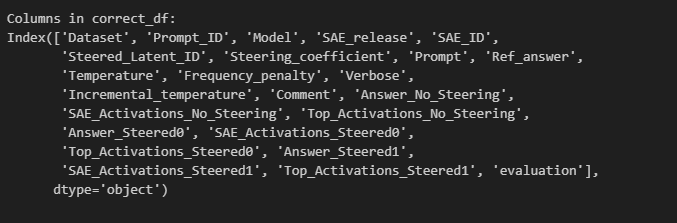

In [13]:
#print("\nExample of SAE_Activations_Answer_No_Steering_layer9:")
#print(correct_df['SAE_Activations_Answer_No_Steering_layer9'].iloc[0])


In [14]:
def extract_last_forward_pass(correct_df):
    # Create new column with the last sublist from each row's nested lists
    correct_df['last_forward_pass'] = correct_df['SAE_Activations_Answer_No_Steering_layer9'].apply(lambda x: x[-1])
    return correct_df

def extract_all_last_forward_passes(correct_df):
    # Get all column names containing 'Activations'
    activation_columns = [col for col in correct_df.columns if 'Activations' in col]
    
    # For each activation column, create a new column with the last forward pass
    for col in activation_columns:
        new_col_name = f"{col}_lastForwardPass"
        correct_df[new_col_name] = correct_df[col].apply(lambda x: x[-1])
    
    return correct_df

In [15]:
correct_df = extract_all_last_forward_passes(correct_df)

In [16]:
# Print all columns containing 'lastForwardPass'
print([col for col in correct_df.columns if 'lastForwardPass' in col])

['Activations_Answer_No_Steering_layer9_lastForwardPass', 'Activations_Answer_No_Steering_layer20_lastForwardPass', 'Activations_Answer_No_Steering_layer31_lastForwardPass', 'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass', 'SAE_Activations_Answer_No_Steering_layer20_lastForwardPass', 'SAE_Activations_Answer_No_Steering_layer31_lastForwardPass', 'Activations_Answer_Steered1_layer9_lastForwardPass', 'Activations_Answer_Steered1_layer20_lastForwardPass', 'Activations_Answer_Steered1_layer31_lastForwardPass', 'SAE_Activations_Answer_Steered1_layer9_lastForwardPass', 'SAE_Activations_Answer_Steered1_layer20_lastForwardPass', 'SAE_Activations_Answer_Steered1_layer31_lastForwardPass', 'Activations_Answer_Steered2_layer9_lastForwardPass', 'Activations_Answer_Steered2_layer20_lastForwardPass', 'Activations_Answer_Steered2_layer31_lastForwardPass', 'SAE_Activations_Answer_Steered2_layer9_lastForwardPass', 'SAE_Activations_Answer_Steered2_layer20_lastForwardPass', 'SAE_Activations_Ans

In [17]:
#correct_df.head()
print("\nColumns in correct_df:")
print(correct_df.columns)



Columns in correct_df:
Index(['Prompt_ID', 'Prompt', 'Ref_answer', 'Answer_No_Steering',
       'Output_Tokens_Answer_No_Steering',
       'Activations_Answer_No_Steering_layer9',
       'Activations_Answer_No_Steering_layer20',
       'Activations_Answer_No_Steering_layer31',
       'SAE_Activations_Answer_No_Steering_layer9',
       'SAE_Activations_Answer_No_Steering_layer20',
       'SAE_Activations_Answer_No_Steering_layer31', 'Answer_Steered1',
       'Output_Tokens_Answer_Steered1', 'Activations_Answer_Steered1_layer9',
       'Activations_Answer_Steered1_layer20',
       'Activations_Answer_Steered1_layer31',
       'SAE_Activations_Answer_Steered1_layer9',
       'SAE_Activations_Answer_Steered1_layer20',
       'SAE_Activations_Answer_Steered1_layer31', 'Answer_Steered2',
       'Output_Tokens_Answer_Steered2', 'Activations_Answer_Steered2_layer9',
       'Activations_Answer_Steered2_layer20',
       'Activations_Answer_Steered2_layer31',
       'SAE_Activations_Answer_Steer

In [18]:
#correct_df = extract_last_forward_pass(correct_df)
#print(len(correct_df['last_forward_pass'].iloc[0]))  # Should print the length of a single latents list

### Preprocess in such a way that the top latent index's of the unsteered answers are taken into account only. 
All other latents indexes of the steered answers will then be masked (set to 0)


In [19]:
def extract_top_activations(df, column_name, top_n=20):
    """
    Extract the top N activations from a specified column.
    
    Args:
        df: DataFrame containing the activation data
        column_name: Name of the column to analyze
        top_n: Number of top activations to extract (default=20)
    
    Returns:
        list of tuples: [(index, activation_value), ...] for the top N activations
    """
    def get_top_n_indices(vector_data, n=top_n):
        """Helper function to get indices of top N activations"""
        # Convert input to numpy array if needed
        if isinstance(vector_data, str):
            vector = np.array(eval(vector_data))
        elif isinstance(vector_data, list):
            vector = np.array(vector_data)
        else:
            vector = vector_data
            
        # Get indices of top N values
        indices = np.argsort(vector)[-n:][::-1]  # Reverse to get descending order
        return [(int(idx), float(vector[idx])) for idx in indices]
    
    # Initialize list to store results
    top_activations = []
    
    try:
        # Process each row
        for idx in range(len(df)):
            vector = df[column_name].iloc[idx]
            top_indices = get_top_n_indices(vector)
            top_activations.append(top_indices)
            
        return top_activations
        
    except Exception as e:
        print(f"Error processing column {column_name}: {e}")
        return None

# Example usage:
# Choose one of the available columns
available_columns = [
    'Activations_Answer_No_Steering_layer9_lastForwardPass',
    'Activations_Answer_No_Steering_layer20_lastForwardPass',
    'Activations_Answer_No_Steering_layer31_lastForwardPass',
    'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass',
    'SAE_Activations_Answer_No_Steering_layer20_lastForwardPass',
    'SAE_Activations_Answer_No_Steering_layer31_lastForwardPass'
]

# Extract top 20 activations from a specific column
column_to_analyze = 'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass'
top_activations = extract_top_activations(correct_df, column_to_analyze, top_n=20)

# Print results for the first row
if top_activations:
    print(f"\nTop 20 activations for {column_to_analyze} (first row):")
    for idx, val in top_activations[0]:
        print(f"Latent {idx} had activation {val:.2f}")


Top 20 activations for SAE_Activations_Answer_No_Steering_layer9_lastForwardPass (first row):
Latent 3879 had activation 50.64
Latent 120222 had activation 28.26
Latent 104959 had activation 22.79
Latent 98395 had activation 14.91
Latent 129335 had activation 12.00
Latent 127994 had activation 9.45
Latent 114730 had activation 9.43
Latent 11970 had activation 8.45
Latent 398 had activation 8.08
Latent 7208 had activation 7.73
Latent 98306 had activation 7.58
Latent 34309 had activation 7.37
Latent 18308 had activation 6.76
Latent 99092 had activation 5.89
Latent 67198 had activation 5.32
Latent 54777 had activation 5.08
Latent 111661 had activation 4.96
Latent 22540 had activation 4.61
Latent 129426 had activation 4.60
Latent 73960 had activation 4.57


In [20]:
def add_top_activations_to_df(df, top_n=20):
    """
    Extract top N activations for each activation column and store results in new columns.
    
    Args:
        df: DataFrame containing the activation data
        top_n: Number of top activations to extract (default=20)
    
    Returns:
        DataFrame with new columns containing top activations
    """
    # Define available columns
    available_columns = [
        'Activations_Answer_No_Steering_layer9_lastForwardPass',
        'Activations_Answer_No_Steering_layer20_lastForwardPass',
        'Activations_Answer_No_Steering_layer31_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer20_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer31_lastForwardPass'
    ]
    
    # Create new DataFrame to avoid modifying original
    new_df = df.copy()
    
    # Process each column
    for column in available_columns:
        try:
            # Extract top activations
            top_acts = extract_top_activations(df, column, top_n)
            
            if top_acts:
                # Create new column name
                new_column = f'Top_{top_n}_{column}'
                
                # Add to DataFrame
                new_df[new_column] = top_acts
                
                print(f"Successfully processed {column}")
            else:
                print(f"No results for {column}")
                
        except Exception as e:
            print(f"Error processing {column}: {e}")
            continue
    
    return new_df

# Update the DataFrame with top activations
correct_df = add_top_activations_to_df(correct_df, top_n=20)

# Print the new column names to verify
print("\nNew columns added:")
new_columns = [col for col in correct_df.columns if col.startswith('Top_')]
for col in new_columns:
    print(col)

# Print example of stored data from first row
print("\nExample of stored top activations (first row, first new column):")
print(correct_df[new_columns[0]].iloc[0])

Successfully processed Activations_Answer_No_Steering_layer9_lastForwardPass
Successfully processed Activations_Answer_No_Steering_layer20_lastForwardPass
Successfully processed Activations_Answer_No_Steering_layer31_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer9_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer20_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer31_lastForwardPass

New columns added:
Top_20_Activations_Answer_No_Steering_layer9_lastForwardPass
Top_20_Activations_Answer_No_Steering_layer20_lastForwardPass
Top_20_Activations_Answer_No_Steering_layer31_lastForwardPass
Top_20_SAE_Activations_Answer_No_Steering_layer9_lastForwardPass
Top_20_SAE_Activations_Answer_No_Steering_layer20_lastForwardPass
Top_20_SAE_Activations_Answer_No_Steering_layer31_lastForwardPass

Example of stored top activations (first row, first new column):
[(1279, 27.138877868652344), (3055, 15.590797424316406

In [21]:
# Access top activations for a specific row and column
row_num = 0
column_name = new_columns[0]  # First new column
top_activations = correct_df[column_name].iloc[row_num]

print(f"\nTop activations for row {row_num}, {column_name}:")
for idx, val in top_activations:
    print(f"Latent {idx} had activation {val:.2f}")


Top activations for row 0, Top_20_Activations_Answer_No_Steering_layer9_lastForwardPass:
Latent 1279 had activation 27.14
Latent 3055 had activation 15.59
Latent 2833 had activation 9.21
Latent 2783 had activation 8.14
Latent 1243 had activation 7.11
Latent 2558 had activation 6.99
Latent 2533 had activation 6.78
Latent 2719 had activation 6.77
Latent 2602 had activation 6.73
Latent 1673 had activation 6.27
Latent 536 had activation 6.27
Latent 26 had activation 6.09
Latent 3158 had activation 5.87
Latent 1354 had activation 5.87
Latent 602 had activation 5.77
Latent 1963 had activation 5.51
Latent 317 had activation 5.37
Latent 1388 had activation 5.26
Latent 3519 had activation 5.20
Latent 2362 had activation 5.04


#### Extract steered activations (top_k) 
    Extract activation strengths from both steered1 and steered2 columns corresponding 
    to top activations in non-steered columns.

ToDo: Parse the top 20 of each individual column instead of using unsteered answer to mask them.

In [22]:
def extract_steered_activations(df, top_n=20):
    """
    Extract activation strengths from both steered1 and steered2 columns corresponding 
    to top activations in non-steered columns.
    """
    column_groups = {
        'Activations_Answer_No_Steering_layer9_lastForwardPass': 
            ('Activations_Answer_Steered1_layer9_lastForwardPass', 'Activations_Answer_Steered2_layer9_lastForwardPass'),
        'Activations_Answer_No_Steering_layer20_lastForwardPass': 
            ('Activations_Answer_Steered1_layer20_lastForwardPass', 'Activations_Answer_Steered2_layer20_lastForwardPass'),
        'Activations_Answer_No_Steering_layer31_lastForwardPass': 
            ('Activations_Answer_Steered1_layer31_lastForwardPass', 'Activations_Answer_Steered2_layer31_lastForwardPass'),
        'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass': 
            ('SAE_Activations_Answer_Steered1_layer9_lastForwardPass', 'SAE_Activations_Answer_Steered2_layer9_lastForwardPass'),
        'SAE_Activations_Answer_No_Steering_layer20_lastForwardPass': 
            ('SAE_Activations_Answer_Steered1_layer20_lastForwardPass', 'SAE_Activations_Answer_Steered2_layer20_lastForwardPass'),
        'SAE_Activations_Answer_No_Steering_layer31_lastForwardPass': 
            ('SAE_Activations_Answer_Steered1_layer31_lastForwardPass', 'SAE_Activations_Answer_Steered2_layer31_lastForwardPass')
    }
    
    new_df = df.copy()
    
    def get_steered_values(row, steering_col, top_indices):
        """Helper function to get steered values for specific indices"""
        try:
            # Convert steered column data to numpy array
            if isinstance(row[steering_col], str):
                steered_vector = np.array(eval(row[steering_col]))
            elif isinstance(row[steering_col], list):
                steered_vector = np.array(row[steering_col])
            else:
                steered_vector = row[steering_col]
            
            # Get values for valid indices
            return [(idx, float(steered_vector[idx])) for idx, _ in top_indices]
            
        except Exception as e:
            print(f"Error processing {steering_col}: {e}")
            return None
    
    # Process each column group
    for no_steering_col, (steered1_col, steered2_col) in column_groups.items():
        try:
            # Get the column with top activations
            top_acts_col = f'Top_{top_n}_{no_steering_col}'
            
            if top_acts_col not in df.columns:
                print(f"Warning: {top_acts_col} not found in DataFrame")
                continue
                
            # Create new column names
            new_col_steered1 = f'Steered1_{top_n}_{steered1_col}'
            new_col_steered2 = f'Steered2_{top_n}_{steered2_col}'
            
            # Initialize empty lists for the new columns
            steered1_values_list = []
            steered2_values_list = []
            
            # Process each row
            for idx in range(len(df)):
                top_indices = df[top_acts_col].iloc[idx]
                if top_indices is not None:
                    # Extract steered values
                    steered1_values = get_steered_values(df.iloc[idx], steered1_col, top_indices)
                    steered2_values = get_steered_values(df.iloc[idx], steered2_col, top_indices)
                    
                    steered1_values_list.append(steered1_values)
                    steered2_values_list.append(steered2_values)
                else:
                    steered1_values_list.append(None)
                    steered2_values_list.append(None)
            
            # Add new columns to DataFrame
            new_df[new_col_steered1] = steered1_values_list
            new_df[new_col_steered2] = steered2_values_list
            
            print(f"Successfully processed {steered1_col} and {steered2_col}")
            
        except Exception as e:
            print(f"Error processing columns: {e}")
            continue
    
    return new_df

In [23]:
# Function to compare activations across all three versions
def compare_activations(row, layer_num, is_sae=False):
    """
    Compare non-steered and both steered activations for a specific layer
    """
    prefix = 'SAE_' if is_sae else ''
    no_steering_col = f'Top_20_{prefix}Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass'
    steered1_col = f'Steered1_20_{prefix}Activations_Answer_Steered1_layer{layer_num}_lastForwardPass'
    steered2_col = f'Steered2_20_{prefix}Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
    
    # Check if all required data is available
    if any(col not in row or row[col] is None for col in [no_steering_col, steered1_col, steered2_col]):
        print(f"Missing data for {prefix}layer {layer_num}")
        return
    
    print(f"\nComparison for {prefix}layer {layer_num}:")
    try:
        for i in range(len(row[no_steering_col])):
            idx1, val1 = row[no_steering_col][i]
            val2 = row[steered1_col][i][1] if i < len(row[steered1_col]) else None
            val3 = row[steered2_col][i][1] if i < len(row[steered2_col]) else None
            
            print(f"Latent {idx1}:")
            print(f"  No steering: {val1:.2f}")
            if val2 is not None:
                diff1 = val2 - val1
                print(f"  Steered1: {val2:.2f} (diff: {diff1:.2f})")
            if val3 is not None:
                diff2 = val3 - val1
                print(f"  Steered2: {val3:.2f} (diff: {diff2:.2f})")
    except Exception as e:
        print(f"Error comparing activations: {e}")

# Update the DataFrame with steered activations
correct_df = extract_steered_activations(correct_df, top_n=20)

# Print example comparison for first row
print("\nExample comparison for first row:")
row_num = 0
for layer in [9, 20, 31]:
    compare_activations(correct_df.iloc[row_num], layer, is_sae=False)
    compare_activations(correct_df.iloc[row_num], layer, is_sae=True)

Successfully processed Activations_Answer_Steered1_layer9_lastForwardPass and Activations_Answer_Steered2_layer9_lastForwardPass
Successfully processed Activations_Answer_Steered1_layer20_lastForwardPass and Activations_Answer_Steered2_layer20_lastForwardPass
Successfully processed Activations_Answer_Steered1_layer31_lastForwardPass and Activations_Answer_Steered2_layer31_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer9_lastForwardPass and SAE_Activations_Answer_Steered2_layer9_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer20_lastForwardPass and SAE_Activations_Answer_Steered2_layer20_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer31_lastForwardPass and SAE_Activations_Answer_Steered2_layer31_lastForwardPass

Example comparison for first row:

Comparison for layer 9:
Latent 1279:
  No steering: 27.14
  Steered1: 54.01 (diff: 26.87)
  Steered2: 52.39 (diff: 25.25)
Latent 3055:
  No steering: 15.59
  

In [ ]:
def analyze_evaluations(df):
    """
    Analyze the evaluation column to count correct (1) vs incorrect (0) answers
    for each position in the evaluation lists.
    
    Args:
        df: DataFrame containing 'evaluation' column with lists of evaluations
    """
    # Initialize counters
    total_rows = len(df)
    counts = {'unsteered': 0, 'steered1': 0, 'steered2': 0}
    
    for eval_list in df['evaluation']:
        # Count 1s in each position
        # Position 0: unsteered, 1: steered1, 2: steered2
        counts['unsteered'] += int(eval_list[0])
        counts['steered1'] += int(eval_list[1])
        counts['steered2'] += int(eval_list[2])
    
    print(f"\nTotal number of cases: {total_rows}")
    print("\nCorrect answers (1s) count:")
    print(f"Unsteered: {counts['unsteered']} ({counts['unsteered']/total_rows*100:.1f}%)")
    print(f"Steered1:  {counts['steered1']} ({counts['steered1']/total_rows*100:.1f}%)")
    print(f"Steered2:  {counts['steered2']} ({counts['steered2']/total_rows*100:.1f}%)")

# Run the analysis
analyze_evaluations(correct_df)


Total number of cases: 25

Correct answers (1s) count:
Unsteered: 25 (100.0%)
Steered1:  14 (56.0%)
Steered2:  14 (56.0%)


In [ ]:
print("\nEvaluation column of correct_df:")
print("-" * 60)
print(correct_df['evaluation'])
print("-" * 60)



Evaluation column of correct_df:
------------------------------------------------------------
0     [1, 1, 1]
1     [1, 1, 1]
2     [1, 1, 1]
3     [1, 1, 1]
4     [1, 0, 1]
5     [1, 1, 1]
6     [1, 1, 1]
7     [1, 1, 1]
8     [1, 0, 0]
9     [1, 0, 0]
10    [1, 0, 0]
11    [1, 1, 0]
12    [1, 1, 1]
13    [1, 0, 0]
14    [1, 0, 0]
15    [1, 0, 0]
16    [1, 1, 1]
17    [1, 1, 1]
18    [1, 0, 0]
19    [1, 0, 0]
20    [1, 0, 0]
21    [1, 1, 1]
22    [1, 1, 1]
23    [1, 1, 1]
24    [1, 0, 0]
Name: evaluation, dtype: object
------------------------------------------------------------


In [105]:
#correct_df.head()
print("\nColumns in correct_df:")
print(correct_df.columns)


Columns in correct_df:
Index(['Prompt_ID', 'Prompt', 'Ref_answer', 'Answer_No_Steering',
       'Output_Tokens_Answer_No_Steering',
       'Activations_Answer_No_Steering_layer9',
       'Activations_Answer_No_Steering_layer20',
       'Activations_Answer_No_Steering_layer31',
       'SAE_Activations_Answer_No_Steering_layer9',
       'SAE_Activations_Answer_No_Steering_layer20',
       'SAE_Activations_Answer_No_Steering_layer31', 'Answer_Steered1',
       'Output_Tokens_Answer_Steered1', 'Activations_Answer_Steered1_layer9',
       'Activations_Answer_Steered1_layer20',
       'Activations_Answer_Steered1_layer31',
       'SAE_Activations_Answer_Steered1_layer9',
       'SAE_Activations_Answer_Steered1_layer20',
       'SAE_Activations_Answer_Steered1_layer31', 'Answer_Steered2',
       'Output_Tokens_Answer_Steered2', 'Activations_Answer_Steered2_layer9',
       'Activations_Answer_Steered2_layer20',
       'Activations_Answer_Steered2_layer31',
       'SAE_Activations_Answer_Steer

### Add Top 20 activations of the steered answer _lastForwardPass columns to the activations, as well. (not used in rest of code.. yet)

In [106]:
def add_top_activations_to_df(df, top_n=20):
    """
    Extract top N activations for each activation column and store results in new columns.
    
    Args:
        df: DataFrame containing the activation data
        top_n: Number of top activations to extract (default=20)
    
    Returns:
        DataFrame with new columns containing top activations
    """
    # Define available columns
    available_columns = [
        'Activations_Answer_No_Steering_layer9_lastForwardPass',
        'Activations_Answer_No_Steering_layer20_lastForwardPass',
        'Activations_Answer_No_Steering_layer31_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer9_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer20_lastForwardPass',
        'SAE_Activations_Answer_No_Steering_layer31_lastForwardPass',
        # Add steered columns
        'Activations_Answer_Steered1_layer9_lastForwardPass',
        'Activations_Answer_Steered1_layer20_lastForwardPass',
        'Activations_Answer_Steered1_layer31_lastForwardPass',
        'SAE_Activations_Answer_Steered1_layer9_lastForwardPass',
        'SAE_Activations_Answer_Steered1_layer20_lastForwardPass',
        'SAE_Activations_Answer_Steered1_layer31_lastForwardPass',
        'Activations_Answer_Steered2_layer9_lastForwardPass',
        'Activations_Answer_Steered2_layer20_lastForwardPass',
        'Activations_Answer_Steered2_layer31_lastForwardPass',
        'SAE_Activations_Answer_Steered2_layer9_lastForwardPass',
        'SAE_Activations_Answer_Steered2_layer20_lastForwardPass',
        'SAE_Activations_Answer_Steered2_layer31_lastForwardPass'
    ]
    
    # Create new DataFrame to avoid modifying original
    new_df = df.copy()
    
    # Process each column
    for column in available_columns:
        try:
            # Extract top activations
            top_acts = extract_top_activations(df, column, top_n)
            
            if top_acts:
                # Create new column name
                new_column = f'Top_{top_n}_{column}'
                
                # Add to DataFrame
                new_df[new_column] = top_acts
                
                print(f"Successfully processed {column}")
            else:
                print(f"No results for {column}")
                
        except Exception as e:
            print(f"Error processing {column}: {e}")
            continue
    
    return new_df

# Update the DataFrame with top activations
correct_df = add_top_activations_to_df(correct_df, top_n=20)

# Print the new column names to verify
print("\nNew columns added:")
new_columns = [col for col in correct_df.columns if col.startswith('Top_')]
for col in new_columns:
    print(col)

Successfully processed Activations_Answer_No_Steering_layer9_lastForwardPass
Successfully processed Activations_Answer_No_Steering_layer20_lastForwardPass
Successfully processed Activations_Answer_No_Steering_layer31_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer9_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer20_lastForwardPass
Successfully processed SAE_Activations_Answer_No_Steering_layer31_lastForwardPass
Successfully processed Activations_Answer_Steered1_layer9_lastForwardPass
Successfully processed Activations_Answer_Steered1_layer20_lastForwardPass
Successfully processed Activations_Answer_Steered1_layer31_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer9_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer20_lastForwardPass
Successfully processed SAE_Activations_Answer_Steered1_layer31_lastForwardPass
Successfully processed Activations_Answer_Steered2_layer9_last

# IDEAS after V1: Different approaches to detect the DRIFT
- 3 types of vector similarity https://www.pinecone.io/learn/vector-similarity/ or https://medium.com/advanced-deep-learning/understanding-vector-similarity-b9c10f7506de
    - can be calculated for:
        - Top Latents vector
        - All SAE.Activations  vector
        - All Neurons vector --> DID NOT RECORD THEM SO FAR!
- Another idea may be to use a classifier (needs a decent amount of labeled data!) 
    - It will probably just figure out that if you look at the 'steered latent' you have a good chance of figuring out where the mistaken answers are..

**Plot Eval:**

*Better for individual prompts:*

- Bar Graph: Top active latents of correct answer together with top active latents of non-correct and correct steered answers (different colours)
- Bar Graph: Top active latents of correct answer together with the same latents of non-correct and correct steered (different colours) answers
--> Already wrote some code for this: LetsDriftGemma2_Hooked_continued (or _tutorial? not sure)

*For individual prompts:*

- Try the script from 3brown1blue for showing high-D vectors in 3D (Top Latents or neurons)
Show drift by showing how the vector moves.

*For a collection of prompts:*

- Could be interesting to add all vectors together of one answer, and then of another answer


#### THOUGHTS after first evals:

- perhaps the code in LetsDriftGemma2_Hooked_Tutorials is interesting --> here there was a code I made that (accidentally) read out the top 5(+) latents of EACH forward pass!

-> right now we're just looking at the latents of the final pass. That's not looking good enuf.

-> Pregunta für Schacht: Datatype for huge amounts of data? (if I also want to store all the neuron and each pass' activations?)



# TODO and GOALS  V2
#### Pre-processing options for V2
- need to distill down to two vectors to compare (for manhattan distance)
    Previously (V1) there was only two vectors, based on the final forward pass. Now ALL forward passes logits & latents are recorded. 
- also, there's now data available from several different hook points in the model. 

Option 1: Only look at the final forward pass of each different hook point.  Goal: See if the same experiment as last time, yields different results in the non-steered layers that were chosen.

Option 1b: look at only the first forward pass? Which is 'more focused on the input' rather than the output?

Option 2: Add together each forward pass' latents to make a single vector

Option 3: Create a new vector based on the top N number of activations. Keep vector dimension the same, and fill all non-top activations to 0

Option 4: Pairwise similarity (compute similarity between all of them towards each other and plot as a big matrix similarity plot (sciKit has a good lib for this))
===> use this also to see how several passes compare to each other! In logits and latent terms. 

For each option: Try normalized, non normalized

Additionally: try combining several dataset's / runs / folders.


The following are really extras... if I have time:
Option 5: use clustering.
(e.g., K-means, hierarchical clustering) to group similar vectors together.

Option 6: Reduce the dimensionality of the vectors (e.g., using PCA, t-SNE, or UMAP) to 2D or 3D.

Visualize the vectors in a lower-dimensional space to observe their relative similarities. Use libraries like Scikit-learn or UMAP for dimensionality reduction.

Option 7: Hierarchical Similarity
Use hierarchical methods to build a tree (dendrogram) showing the relationships between vectors.

FAISS (good for scalability?)
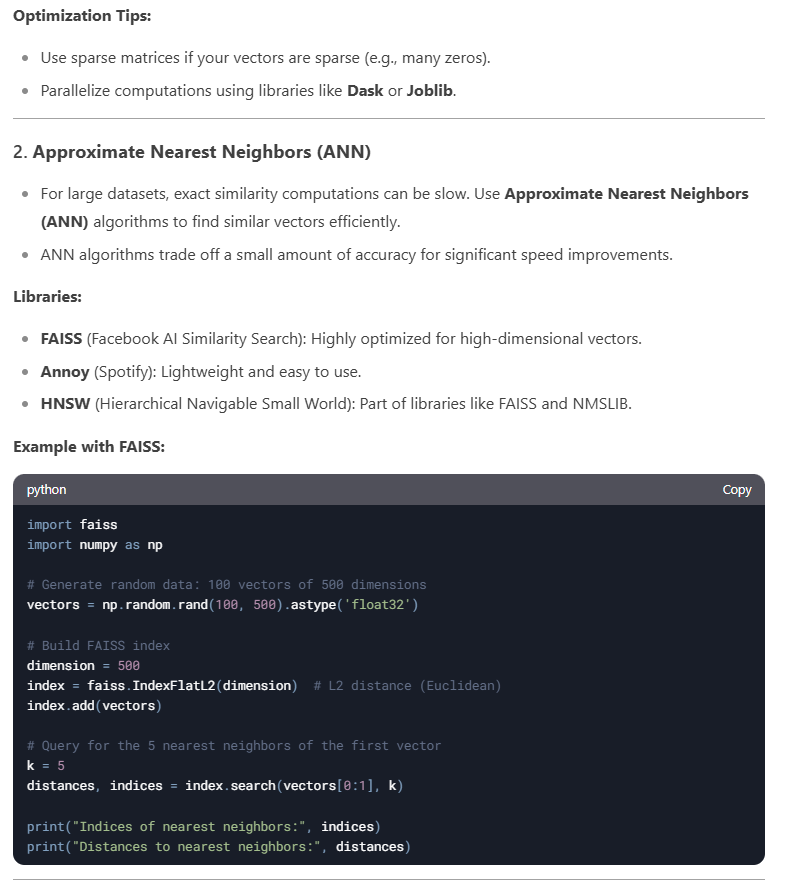

##### NEW measurement evaluation in V2: 
for USMLE, try comparing the latents of those logits and latents which correspond to the tokens that output the answer letter, such as A
Note... very few cases, it didn't output the answer as (A) but said it without the brakets or with asterix (on one side only), instead. ===> just ignore those. Always look for the (). Then focus on whatever token contains the letter. 
It may look like any of the following: "(A", " (A", "A", etc. Important is that you look at that token which contains the actual latent. Then run it through all these evals, yet again!




#### THOUGHTS and TODO after another round of evals with all the answers so far

- TODO: save the evaluations on manhattan distance, cosine sim, & perhaps also [top activations & 'evaluation matrix']  in a seperate (low MB file size) file. Then you can combine more results later without running out of SSD/RAM space during eval. Just too much data like this (max 40-ish answers at a time parseable)
- For manhattan distance and dot product: Make sure you save and compare on a per-layer basis. The cosine similarity probably shows such a huge difference, because it is between 1&0. For the other measures, the min-max scale may be hugely different in each layer!!

AFTER THAT -- CONTINUE WITH V3 TO KEEP THESE PRELIMINARY RESULTS IN THE OUTPUTS!

- need more prompts/answers to tell if the cosine similarity is actually a good estimator of model drift. 
    -> would then also need to build a classifier that auto-classifies answers.
    -> 'Interesting' about it: The cosine-similarity measure seems to work better on SAE latents than on the actiatio

- The very last evaluation, showing the 20 top latents across all layers, is indicative of the steered answer's activations being quite similar. Which is fair enough, but it leads me to think that steering induces too many ripple effects in the neural network, effectively changing how it thinks.
    -> Very interesting would be to try and reformulate the actual prompts like a pirate or with an accent or appending 'consider you're in the middle of a pandemic and need to answer this question without talking about '....' - something like that. 

- TODO: The eval inside of the Looped LetsDriftGemma2 experiment script, which shows that latents across several forward passes don't change much.  --> interesting for paper and why only the last forward pass was taken for eval, here.

- TODO, if time... FAIISS

##### folder paths, so far evaluated:

folder_paths = [

    "77to82Hotpot_negative_v2_fixed",

    "77to82USMLE_negative_v2_fixed",

    #-"60to75USMLE_negative_v2_fixed", --> Junk. See eval texts at the end of EVAL_steered_jsonl_v2 script

    "60to75Hotpot_pirate_v2_fixed",

    "60to75USMLE_pirate_v2_fixed"
    
]

## Manhattan distance
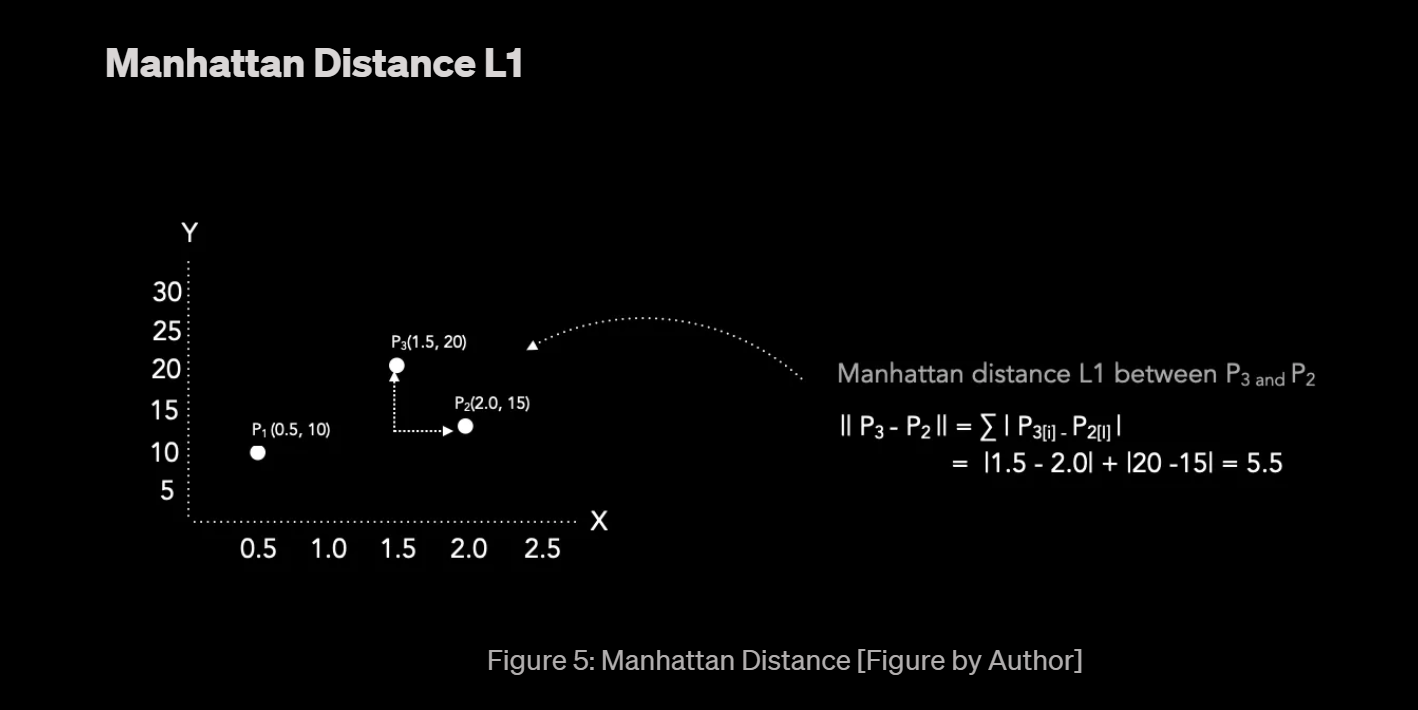

- Calculate the Manhattan distance between unsteered (correct) answer and all steered (correct or uncorrect) answers
- Compare the results for those that are correct and those that arent - Scatter plot

Note there are two normalization methods here. Method 1:
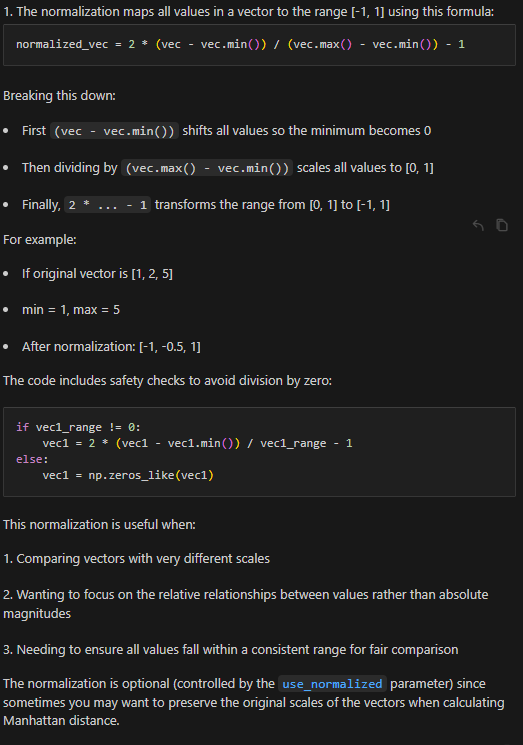

In [24]:
def calculate_manhattan_distance_V1(vec1, vec2, bNormalize=False):
    """
    Calculate Manhattan distance between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating distance
    
    Returns:
        float: Manhattan distance between the vectors
    """
    # Convert to numpy arrays
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        # Avoid division by zero for vec1
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        # Avoid division by zero for vec2  
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    return np.sum(np.abs(vec1 - vec2))




Method 2 then uses a 'global min and max' of the two vectors. This allows a better OVERALL comparison, in the later plots, I think.

In [33]:
def calculate_manhattan_distance(vec1, vec2, bNormalize=False): # calculate_manhattan_distance_shared_norm
    """
    Calculate Manhattan distance between two vectors, with optional normalization
    using a shared scale derived from both vectors.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] using shared min/max
    
    Returns:
        float: Manhattan distance between the vectors
    """
    # Convert to numpy arrays
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    if bNormalize:
        # Find global min and max across both vectors
        global_min = min(vec1.min(), vec2.min())
        global_max = max(vec1.max(), vec2.max())
        
        # Calculate shared range
        global_range = global_max - global_min
        
        # Normalize both vectors using shared scale
        if global_range != 0:
            vec1 = 2 * (vec1 - global_min) / global_range - 1
            vec2 = 2 * (vec2 - global_min) / global_range - 1
        else:
            # If range is 0, both vectors have same constant value
            vec1 = np.zeros_like(vec1)
            vec2 = np.zeros_like(vec2)
    
    return np.sum(np.abs(vec1 - vec2))

In [27]:
# Extract evaluation results for steered answers
def get_steered_evaluations(eval_list):
    """Extract evaluation results from the evaluation list"""
    # Return steered results (positions 1 and 2) as integers
    return [int(eval_list[1]), int(eval_list[2])]

# Create lists for plotting
x_values = []  # Will contain 0s and 1s from evaluations
y_values = []  # Will contain corresponding normalized distances


In [28]:
def calculate_and_store_manhattan_distances(df, use_normalized=False):
    """
    Calculate Manhattan distances between unsteered and steered answers and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized distances
    
    Returns:
        pandas DataFrame containing all Manhattan distances
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    # Initialize lists to store data
    data = []
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate distances for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names
                unsteered_col = f'{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                steered1_col = f'{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                steered2_col = f'{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get vectors
                    unsteered_vec = df[unsteered_col].iloc[prompt_id]
                    steered1_vec = df[steered1_col].iloc[prompt_id]
                    steered2_vec = df[steered2_col].iloc[prompt_id]
                    
                    # Calculate Manhattan distances
                    steered1_dist = calculate_manhattan_distance(unsteered_vec, steered1_vec, use_normalized)
                    steered2_dist = calculate_manhattan_distance(unsteered_vec, steered2_vec, use_normalized)
                    
                    # Store distances in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dist'] = steered1_dist
                    row_data[f'{col_prefix}_layer{layer}_steered2_dist'] = steered2_dist
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dist'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_dist'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    distances_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        distances_df['source_folder'] = df['source_folder']
    
    return distances_df




##### Calculate all distance and plot distribution, stats

In [29]:
distances_df = calculate_and_store_manhattan_distances(correct_df, use_normalized=False)
print(distances_df.head())

   prompt_id evaluation  SAE_layer9_steered1_dist  SAE_layer9_steered2_dist  \
0          0  [1, 1, 1]               2057.090201               2171.634578   
1          1  [1, 1, 1]                496.542269                496.542269   
2          2  [1, 1, 1]                490.534396                490.534396   
3          3  [1, 1, 1]                659.474583                659.474583   
4          4  [1, 0, 1]               1386.299301               1356.853274   

   Regular_layer9_steered1_dist  Regular_layer9_steered2_dist  \
0                   4854.408653                   4720.905158   
1                   1224.479473                   1224.479473   
2                   1151.051130                   1151.051130   
3                   2585.661508                   2585.661508   
4                   1468.253115                   2003.131911   

   SAE_layer20_steered1_dist  SAE_layer20_steered2_dist  \
0                1228.037957                1192.713737   
1               

In [30]:
def analyze_manhattan_distances(distances_df):
    """
    Analyze and visualize the distribution of Manhattan distances.
    
    Args:
        distances_df: DataFrame containing Manhattan distances
        
    Returns:
        DataFrame with statistical summary
    """

    
    # Get all distance columns (excluding prompt_id, evaluation, source_folder)
    distance_cols = [col for col in distances_df.columns 
                    if col.endswith('_dist')]
    
    # Initialize dictionary to store statistics
    stats_data = []
    
    # Create subplots for each layer
    layers = [9, 20, 31]
    types = ['SAE', 'Regular']
    
    fig, axes = plt.subplots(len(layers), len(types), figsize=(15, 4*len(layers)))
    fig.suptitle('Distribution of Manhattan Distances by Layer and Type', fontsize=16, y=1.02)
    
    for i, layer in enumerate(layers):
        for j, type_name in enumerate(types):
            # Get columns for this layer and type
            cols = [col for col in distance_cols 
                   if f'{type_name}_layer{layer}' in col]
            
            if not cols:
                continue
                
            # Get data for plotting
            data = distances_df[cols].melt()
            
            # Calculate statistics
            for col in cols:
                values = distances_df[col].dropna()
                mean = values.mean()
                std = values.std()
                
                # Store statistics
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Steered': 'Steered1' if 'steered1' in col else 'Steered2',
                    'Mean': mean,
                    'Std': std,
                    'Min': values.min(),
                    'Max': values.max()
                })
                
                # Plot distribution
                sns.histplot(data=values, kde=True, ax=axes[i,j])
                
                # Add vertical lines for mean and std
                axes[i,j].axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
                axes[i,j].axvline(mean + std, color='g', linestyle=':', 
                                label=f'Std: +{std:.2f}')
                axes[i,j].axvline(mean - std,    color='g', linestyle=':')
                
            axes[i,j].set_title(f'{type_name} Layer {layer}')
            axes[i,j].set_xlabel('Manhattan Distance')
            axes[i,j].set_ylabel('Count')
            axes[i,j].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create summary DataFrame
    stats_df = pd.DataFrame(stats_data)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(stats_df.to_string(index=False))
    
    return stats_df



###### Plot distributions

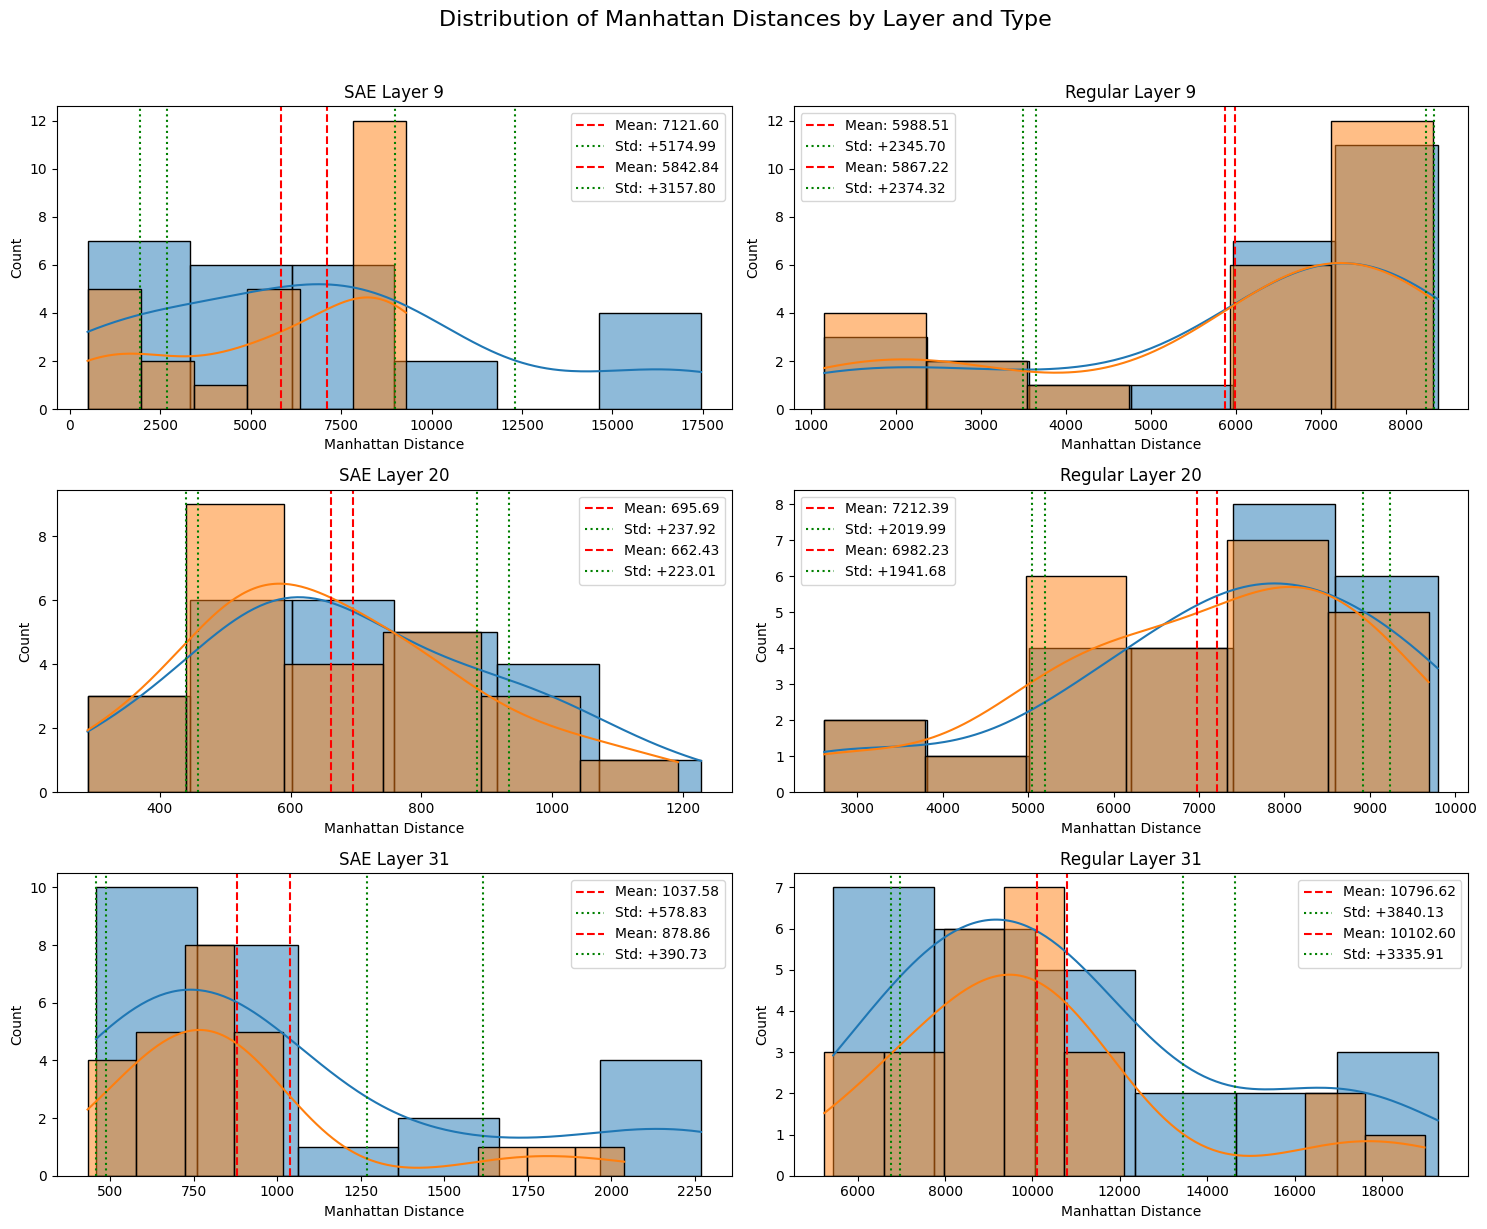


Summary Statistics:
 Layer    Type  Steered         Mean         Std         Min          Max
     9     SAE Steered1  7121.597105 5174.986866  490.534396 17450.112123
     9     SAE Steered2  5842.838346 3157.799999  490.534396  9291.645376
     9 Regular Steered1  5988.514107 2345.702016 1151.051130  8374.722352
     9 Regular Steered2  5867.217111 2374.323022 1151.051130  8316.183503
    20     SAE Steered1   695.686303  237.917698  289.438647  1228.037957
    20     SAE Steered2   662.430049  223.006004  289.438647  1192.713737
    20 Regular Steered1  7212.385538 2019.986426 2612.661192  9795.324621
    20 Regular Steered2  6982.227146 1941.683265 2612.661192  9687.987349
    31     SAE Steered1  1037.577139  578.827299  457.488134  2268.614562
    31     SAE Steered2   878.862331  390.726251  432.442693  2038.851983
    31 Regular Steered1 10796.621034 3840.127550 5438.703793 19276.293887
    31 Regular Steered2 10102.603898 3335.906170 5234.212114 18975.331996

SAE Statistics:


In [32]:
# Then analyze and visualize the distributions
stats_df = analyze_manhattan_distances(distances_df)

# You can further analyze specific combinations
sae_stats = stats_df[stats_df['Type'] == 'SAE']
print("\nSAE Statistics:")
print(sae_stats.to_string(index=False))

###### Normalized version

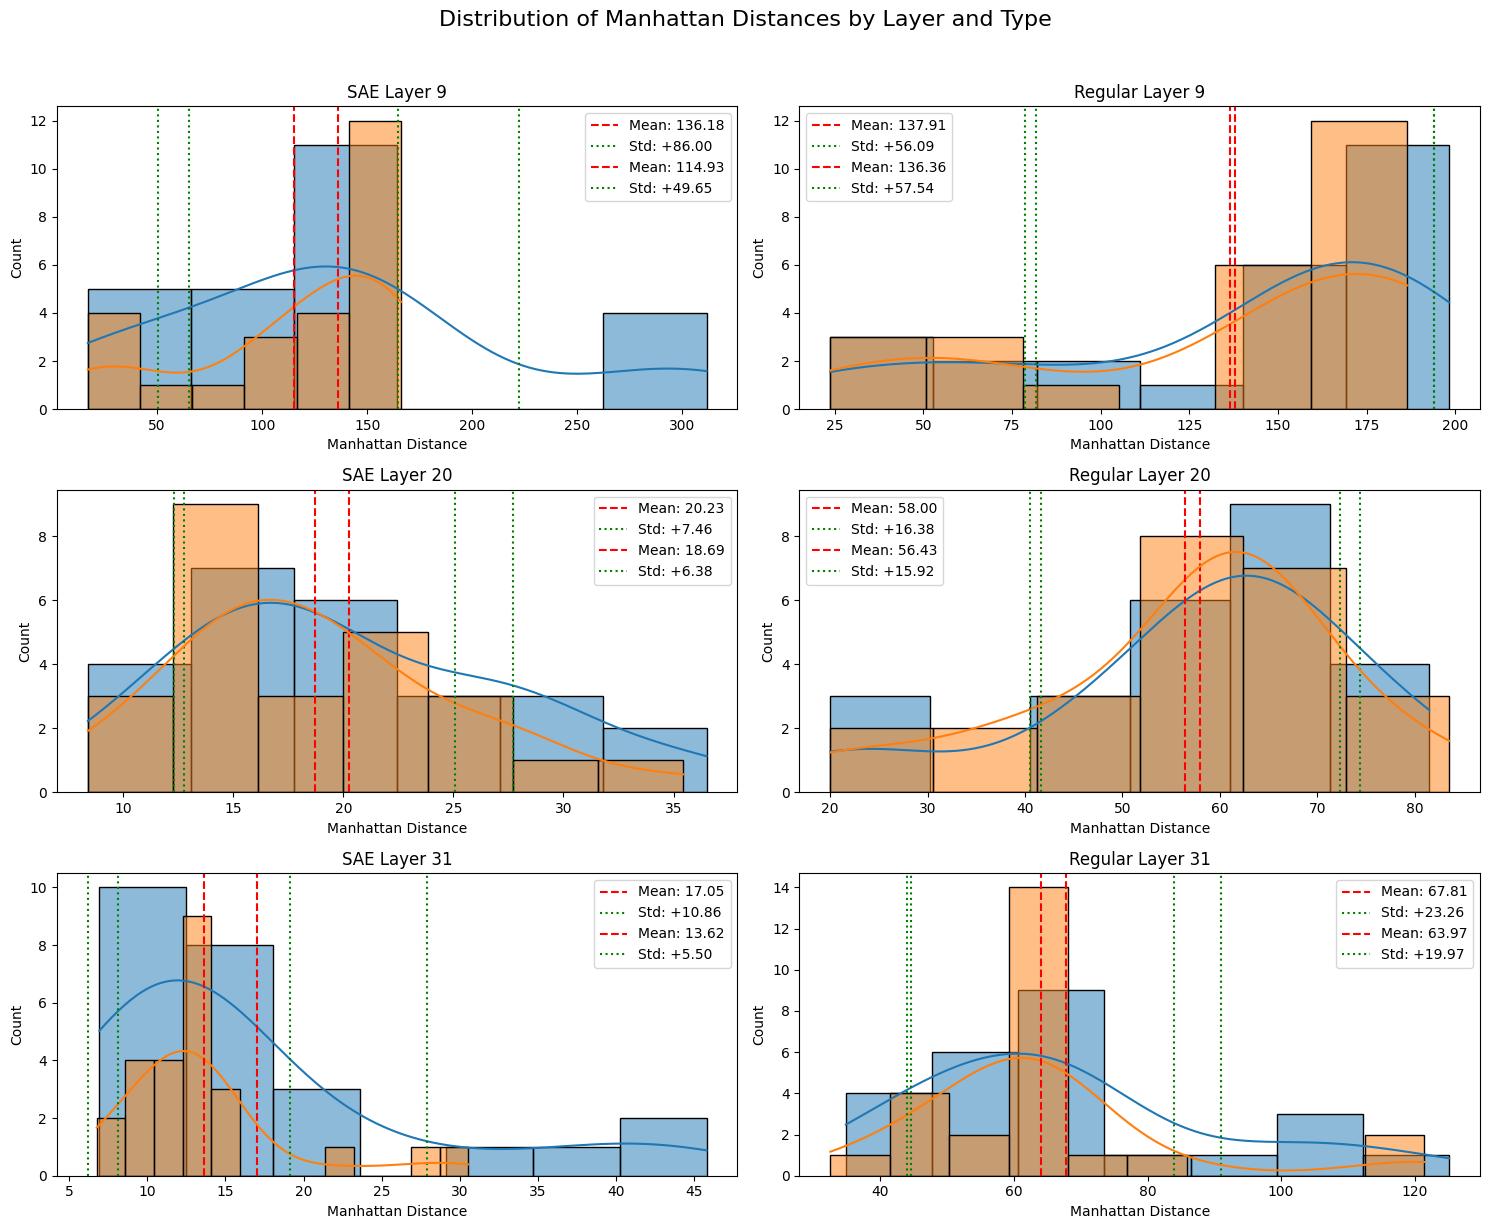


Summary Statistics:
 Layer    Type  Steered       Mean       Std       Min        Max
     9     SAE Steered1 136.177072 85.999950 16.998660 311.464807
     9     SAE Steered2 114.933848 49.652388 16.998660 166.103968
     9 Regular Steered1 137.912674 56.091505 23.791365 198.265974
     9 Regular Steered2 136.357159 57.537455 23.791365 186.438205
    20     SAE Steered1  20.233948  7.456854  8.391411  36.499595
    20     SAE Steered2  18.694011  6.383252  8.391411  35.449693
    20 Regular Steered1  58.003668 16.384189 20.027354  81.507133
    20 Regular Steered2  56.426077 15.923522 20.027354  83.528853
    31     SAE Steered1  17.050059 10.858328  6.928263  45.805732
    31     SAE Steered2  13.621884  5.498828  6.765705  30.550168
    31 Regular Steered1  67.811414 23.262584 34.826610 125.158224
    31 Regular Steered2  63.971954 19.967698 32.498279 121.477296


In [35]:
# Get both normalized  distances
distances_df_norm = calculate_and_store_manhattan_distances(correct_df, use_normalized=True)

# Analyze both
stats_df_norm = analyze_manhattan_distances(distances_df_norm)

###### RESULTS: Using the V1 version of normalization (non-global min max)
Normalization yields a different gaussian plot compared to the non-normalized version, see below a comparison of both: 
Not sure how useful this is, as we're changing the distances completely. 
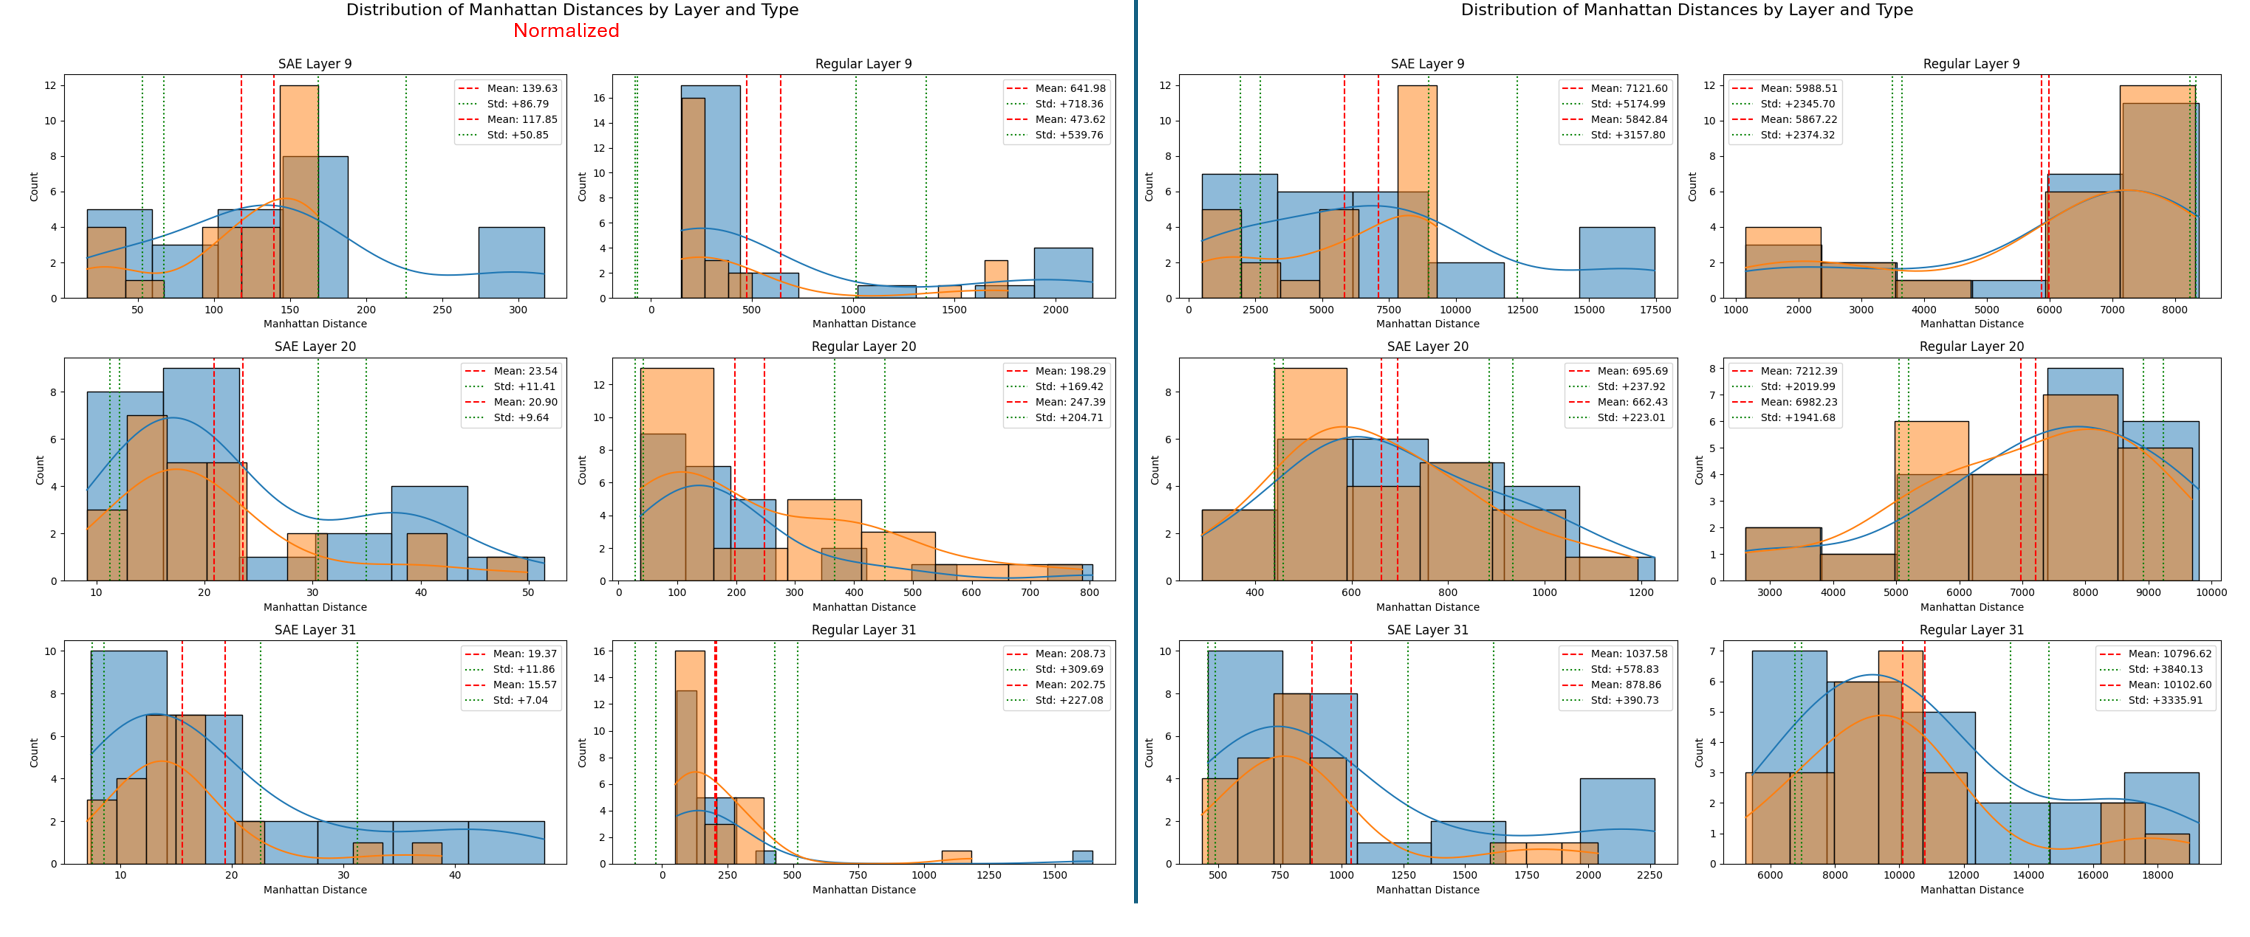

###### Distributions, calculated and plotted by Evaluation Results 
The above distributions show that the comparison between steered1 and steered 2 is somewhat similar. However, it is more interesting to plot the distributions according to whether answers are correct or not. Also: There seems to be some issue with the normalization in the above code.
V2 because V1 didn't work - had to re-write the code 

In [37]:
def analyze_manhattan_distancesv2(distances_df):
    """
    Analyze and visualize the distribution of Manhattan distances between unsteered and steered answers,
    combining both steered1 and steered2 into a single distribution.
    """

    # Create subplots for each layer
    layers = [9, 20, 31]
    types = ['SAE', 'Regular']
    
    fig, axes = plt.subplots(len(layers), len(types), figsize=(15, 4*len(layers)))
    fig.suptitle('Distribution of Manhattan Distances by Layer and Evaluation Result', fontsize=16, y=1.02)
    
    # Initialize list for statistics
    stats_data = []
    
    for i, layer in enumerate(layers):
        for j, type_name in enumerate(types):
            # Get columns for this layer and type
            prefix = type_name
            steered1_col = f'{prefix}_layer{layer}_steered1_dist'
            steered2_col = f'{prefix}_layer{layer}_steered2_dist'
            
            # Combine data from both steered versions
            all_distances = []
            all_correctness = []
            
            # Process steered1 data
            if steered1_col in distances_df.columns:
                correctness1 = distances_df['evaluation'].apply(lambda x: int(x[1]))
                distances1 = distances_df[steered1_col]
                all_distances.extend(distances1)
                all_correctness.extend(correctness1)
            
            # Process steered2 data
            if steered2_col in distances_df.columns:
                correctness2 = distances_df['evaluation'].apply(lambda x: int(x[2]))
                distances2 = distances_df[steered2_col]
                all_distances.extend(distances2)
                all_correctness.extend(correctness2)
            
            # Convert to numpy arrays for easier processing
            all_distances = np.array(all_distances)
            all_correctness = np.array(all_correctness)
            
            # Separate correct and incorrect
            correct_values = all_distances[all_correctness == 1]
            incorrect_values = all_distances[all_correctness == 0]
            
            # Plot distributions
            if len(correct_values) > 0:
                sns.histplot(data=correct_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='green', 
                           label=f'Correct (n={len(correct_values)})')
                mean_correct = correct_values.mean()
                axes[i,j].axvline(mean_correct, color='green', linestyle='--',
                                label=f'Mean Correct: {mean_correct:.2f}')
            
            if len(incorrect_values) > 0:
                sns.histplot(data=incorrect_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='red',
                           label=f'Incorrect (n={len(incorrect_values)})')
                mean_incorrect = incorrect_values.mean()
                axes[i,j].axvline(mean_incorrect, color='red', linestyle='--',
                                label=f'Mean Incorrect: {mean_incorrect:.2f}')
            
            axes[i,j].set_title(f'{type_name} Layer {layer}')
            axes[i,j].set_xlabel('Manhattan Distance')
            axes[i,j].set_ylabel('Count')
            axes[i,j].legend()
            
            # Store statistics
            if len(correct_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Correct',
                    'Mean': correct_values.mean(),
                    'Std': correct_values.std(),
                    'Count': len(correct_values)
                })
            
            if len(incorrect_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Incorrect',
                    'Mean': incorrect_values.mean(),
                    'Std': incorrect_values.std(),
                    'Count': len(incorrect_values)
                })
    
    plt.tight_layout()
    plt.show()
    
    # Create and return statistics DataFrame
    return pd.DataFrame(stats_data)

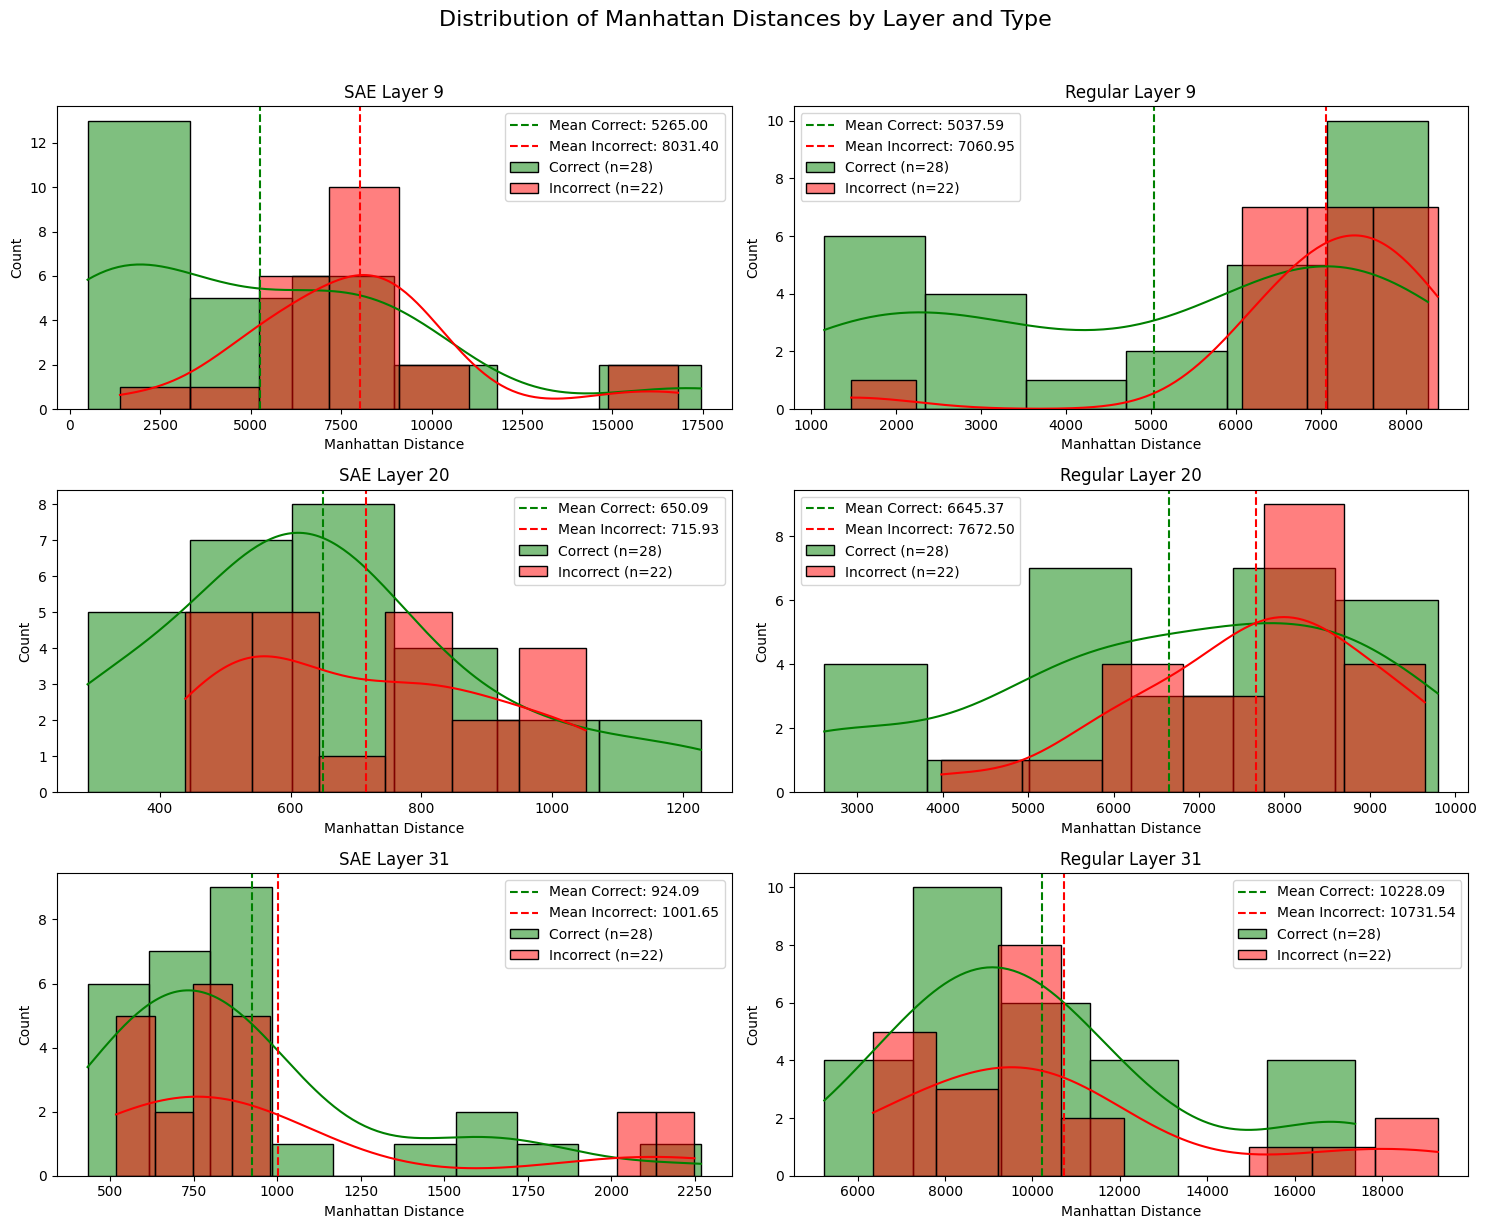


Statistics Summary:
 Layer    Type Correctness         Mean         Std  Count
     9     SAE     Correct  5265.004127 4572.386599     28
     9     SAE   Incorrect  8031.398670 3182.484119     22
     9 Regular     Correct  5037.586229 2495.344971     28
     9 Regular   Incorrect  7060.948458 1393.988077     22
    20     SAE     Correct   650.088793  244.105680     28
    20     SAE   Incorrect   715.928300  195.871407     22
    20 Regular     Correct  6645.371907 2177.739015     28
    20 Regular   Incorrect  7672.495622 1402.675114     22
    31     SAE     Correct   924.092313  437.339873     28
    31     SAE   Incorrect  1001.654636  547.320096     22
    31 Regular     Correct 10228.094782 3328.673750     28
    31 Regular   Incorrect 10731.544064 3775.835639     22


In [38]:
#distances_df = calculate_and_store_manhattan_distances(correct_df, use_normalized=False)
# Then analyze and plot
stats_dfv2 = analyze_manhattan_distancesv2(distances_df)

# Print statistics
print("\nStatistics Summary:")
print(stats_dfv2.to_string(index=False))

PLOT: with seperated steered1 and steered2 (modified code to merge them after making this, see above plot)
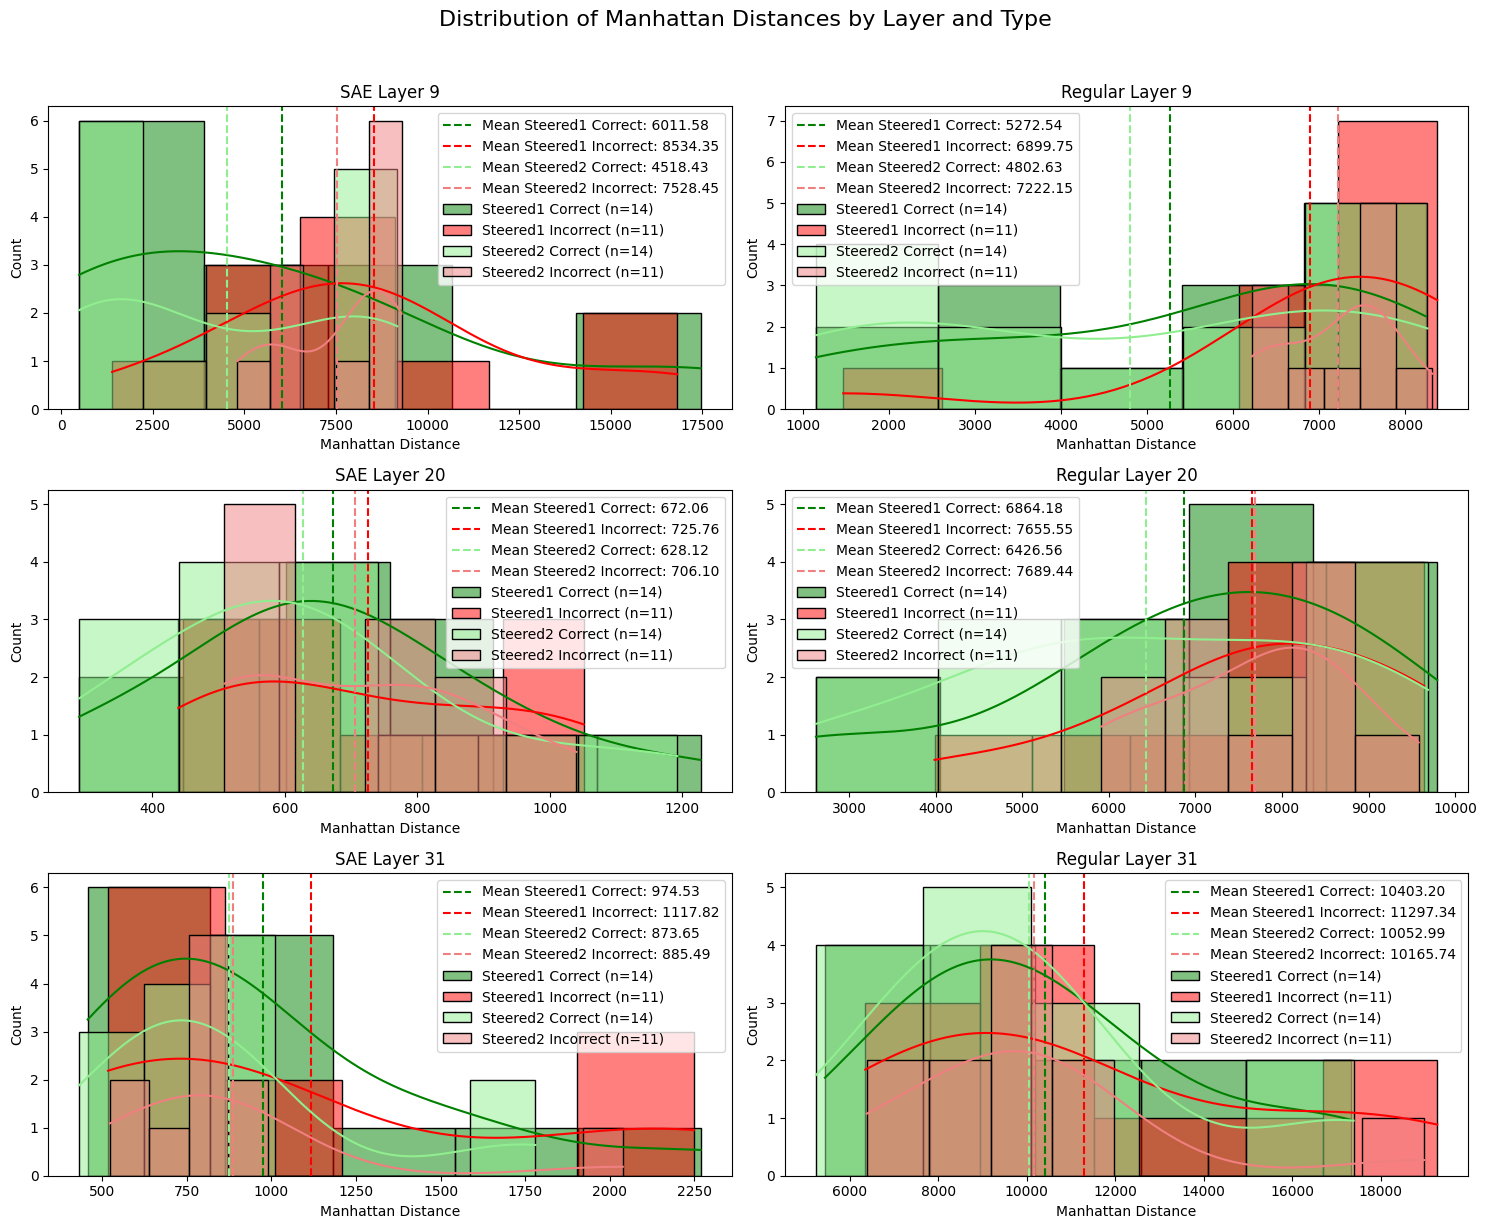


Statistics Summary:
 Layer    Type  Steered Correctness         Mean         Std  Count
     9     SAE Steered1     Correct  6011.580629 5626.815628     14
     9     SAE Steered1   Incorrect  8534.345348 4381.023721     11
     9     SAE Steered2     Correct  4518.427626 3488.308970     14
     9     SAE Steered2   Incorrect  7528.451991 1591.282732     11
     9 Regular Steered1     Correct  5272.541710 2447.871350     14
     9 Regular Steered1   Incorrect  6899.751703 1945.459912     11
     9 Regular Steered2     Correct  4802.630747 2701.939825     14
     9 Regular Steered2   Incorrect  7222.145212  658.077604     11
    20     SAE Steered1     Correct   672.058820  252.515821     14
    20     SAE Steered1   Incorrect   725.757646  226.233966     11
    20     SAE Steered2     Correct   628.118766  252.068689     14
    20     SAE Steered2   Incorrect   706.098954  181.686475     11
    20 Regular Steered1     Correct  6864.183978 2209.893391     14
    20 Regular Steered1   Incorrect  7655.551159 1748.809179     11
    20 Regular Steered2     Correct  6426.559836 2286.474333     14
    20 Regular Steered2   Incorrect  7689.440085 1126.733886     11
    31     SAE Steered1     Correct   974.530448  498.998867     14
    31     SAE Steered1   Incorrect  1117.818383  683.923467     11
    31     SAE Steered2     Correct   873.654178  396.835768     14
    31     SAE Steered2   Incorrect   885.490889  401.985432     11
    31 Regular Steered1     Correct 10403.196318 3426.408349     14
    31 Regular Steered1   Incorrect 11297.343400 4431.359071     11
    31 Regular Steered2     Correct 10052.993246 3472.528126     14
    31 Regular Steered2   Incorrect 10165.744727 3320.245432     11


###### Normalized version 

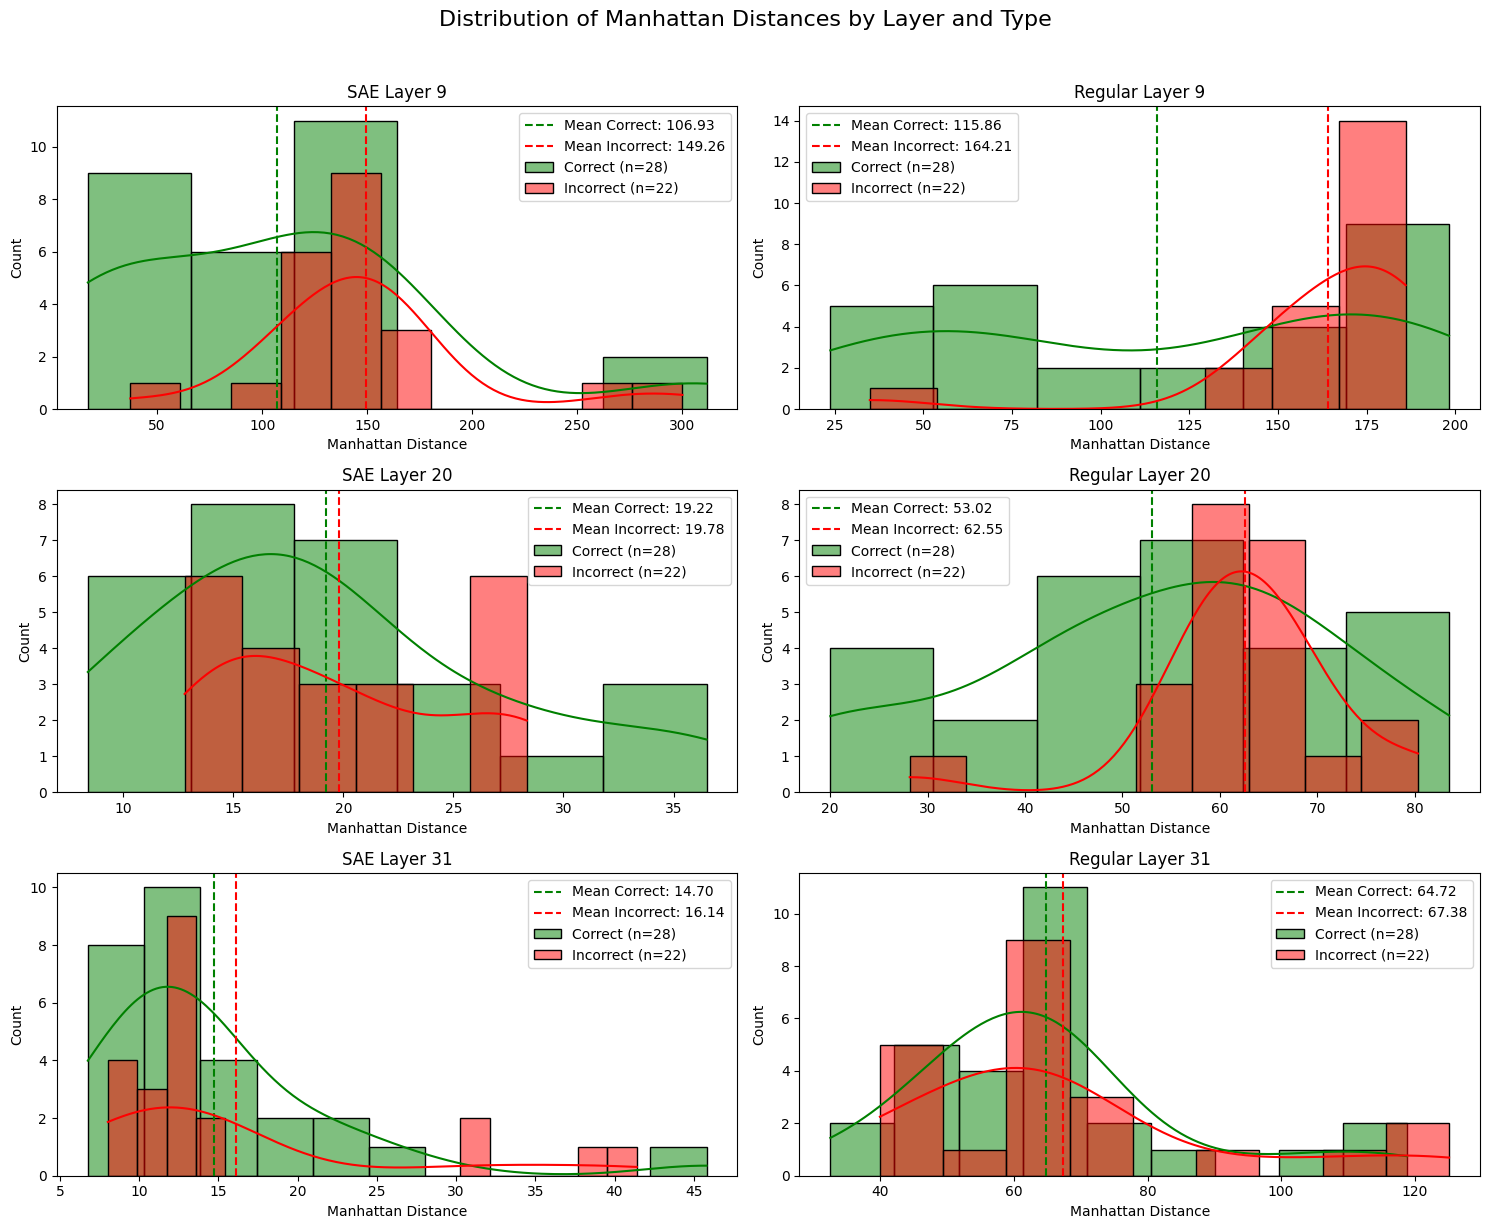


Statistics Summary:
 Layer    Type Correctness       Mean       Std  Count
     9     SAE     Correct 106.932431 75.724365     28
     9     SAE   Incorrect 149.257496 52.086531     22
     9 Regular     Correct 115.859852 61.124611     28
     9 Regular   Incorrect 164.212272 31.316631     22
    20     SAE     Correct  19.215495  7.828541     28
    20     SAE   Incorrect  19.780233  5.317713     22
    20 Regular     Correct  53.024188 18.201240     28
    20 Regular   Incorrect  62.548471  9.921417     22
    31     SAE     Correct  14.703419  7.753485     28
    31     SAE   Incorrect  16.141038  9.519236     22
    31 Regular     Correct  64.723949 19.560674     28
    31 Regular   Incorrect  67.377892 23.297188     22


In [39]:
stats_dfv2_norm = analyze_manhattan_distancesv2(distances_df_norm)

# Print statistics
print("\nStatistics Summary:")
print(stats_dfv2_norm.to_string(index=False))

#### Distance and Token Length comparison
In some cases the manhattan distance is way longer than in others, even in correct answers. In fact, sometimes the largest distances are in the correct answers, even though the average is lower. It might be interesting to check the correlation to token count for these large manhattan distances.

In [41]:
def analyze_token_distance_correlation(distances_df, correct_df):
    """
    Analyze correlation between token counts and Manhattan distances for steered answers.
    Uses pre-calculated distances from distances_df.
    
    Args:
        distances_df: DataFrame containing the pre-calculated Manhattan distances
        correct_df: DataFrame containing the token counts
    """
    layers = [9, 20, 31]
    types = ['SAE', 'Regular']
    
    # Initialize list to store correlation results
    correlation_data = []
    
    for layer in layers:
        for type_name in types:
            # Get distance columns from distances_df
            steered1_dist_col = f'{type_name}_layer{layer}_steered1_dist'
            steered2_dist_col = f'{type_name}_layer{layer}_steered2_dist'
            
            # Get token count columns from correct_df
            steered1_tokens_col = 'Output_Tokens_Answer_Steered1'
            steered2_tokens_col = 'Output_Tokens_Answer_Steered2'
            
            for steered_num, dist_col, tokens_col in [
                (1, steered1_dist_col, steered1_tokens_col),
                (2, steered2_dist_col, steered2_tokens_col)
            ]:
                if dist_col in distances_df.columns and tokens_col in correct_df.columns:
                    # Convert token lists to lengths
                    token_lengths = correct_df[tokens_col].apply(len)
                    
                    # Calculate correlation
                    correlation = pd.DataFrame({
                        'distance': distances_df[dist_col],
                        'tokens': token_lengths
                    }).corr().iloc[0,1]
                    
                    # Get mean values
                    mean_distance = distances_df[dist_col].mean()
                    mean_tokens = token_lengths.mean()
                    
                    # Store results
                    correlation_data.append({
                        'Layer': layer,
                        'Type': type_name,
                        'Steered': f'Steered{steered_num}',
                        'Correlation': correlation,
                        'Mean_Distance': mean_distance,
                        'Mean_Tokens': mean_tokens,
                        'Sample_Size': len(distances_df)
                    })
    
    # Create DataFrame and format display
    results_df = pd.DataFrame(correlation_data)
    
    # Round numeric columns
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['Mean_Distance'] = results_df['Mean_Distance'].round(2)
    results_df['Mean_Tokens'] = results_df['Mean_Tokens'].round(2)
    
    # Print formatted results
    print("\nCorrelation Analysis between Token Count and Manhattan Distance")
    print("=" * 80)
    print(results_df.to_string(index=False))
    
    # Create visualization
    plt.figure(figsize=(15, 6))
    
    # Plot correlations as a heatmap
    pivot_table = results_df.pivot_table(
        values='Correlation',
        index=['Layer', 'Type'],
        columns='Steered'
    )
    
    sns.heatmap(pivot_table, annot=True, cmap='RdYlBu', center=0, 
                vmin=-1, vmax=1, fmt='.3f')
    
    plt.title('Token Count vs Manhattan Distance Correlation')
    plt.tight_layout()
    plt.show()
    
    return results_df



Correlation Analysis between Token Count and Manhattan Distance
 Layer    Type  Steered  Correlation  Mean_Distance  Mean_Tokens  Sample_Size
     9     SAE Steered1        0.524        7121.60       128.72           25
     9     SAE Steered2        0.588        5842.84       137.88           25
     9 Regular Steered1        0.655        5988.51       128.72           25
     9 Regular Steered2        0.428        5867.22       137.88           25
    20     SAE Steered1        0.383         695.69       128.72           25
    20     SAE Steered2        0.221         662.43       137.88           25
    20 Regular Steered1        0.624        7212.39       128.72           25
    20 Regular Steered2        0.490        6982.23       137.88           25
    31     SAE Steered1        0.273        1037.58       128.72           25
    31     SAE Steered2        0.202         878.86       137.88           25
    31 Regular Steered1        0.334       10796.62       128.72           25

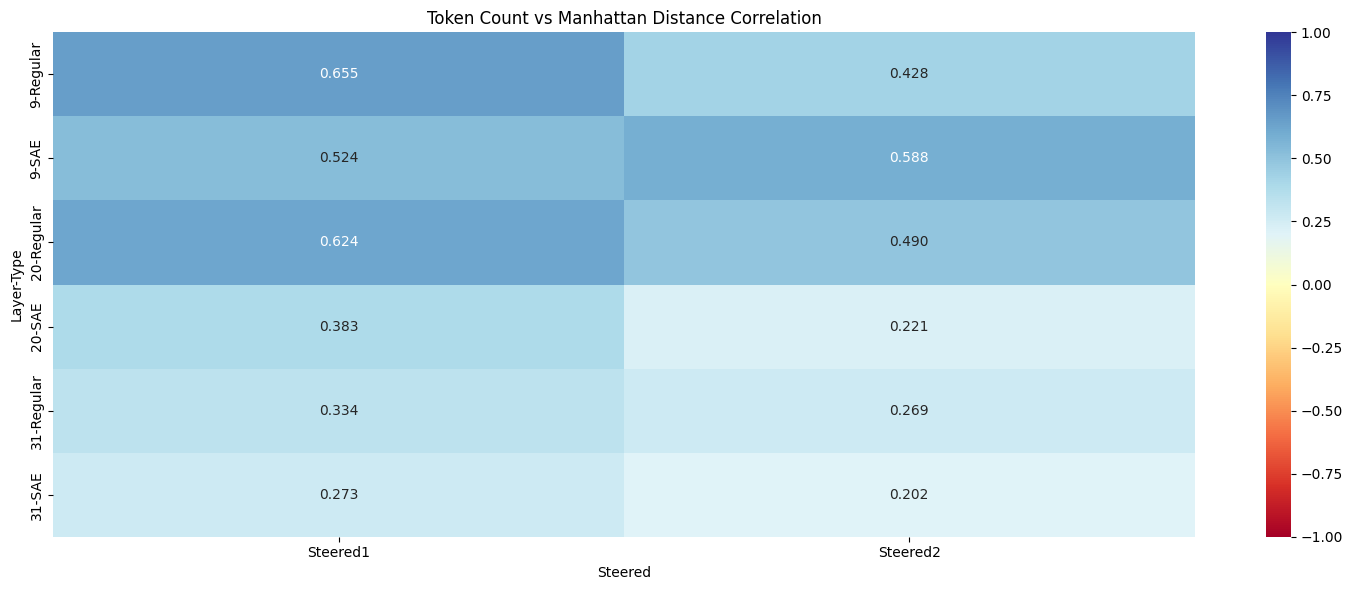

In [42]:
correlation_results = analyze_token_distance_correlation(distances_df, correct_df)

In [49]:
def analyze_token_distance_correlation_single_layer(distances_df, correct_df, layer=9, type_name='SAE'):
    """
    Analyze correlation between token counts and Manhattan distances for a single layer and type.
    Creates a scatter plot of token length vs distance for each prompt.
    
    Args:
        distances_df: DataFrame containing the pre-calculated Manhattan distances
        correct_df: DataFrame containing the token counts
        layer: Layer number to analyze (default: 9)
        type_name: Type of activation to analyze ('SAE' or 'Regular', default: 'SAE')
    """
    # Get distance columns for this layer and type
    steered1_dist_col = f'{type_name}_layer{layer}_steered1_dist'
    steered2_dist_col = f'{type_name}_layer{layer}_steered2_dist'
    
    # Get token count columns
    steered1_tokens_col = 'Output_Tokens_Answer_Steered1'
    steered2_tokens_col = 'Output_Tokens_Answer_Steered2'
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Process steered1
    token_lengths1 = correct_df[steered1_tokens_col].apply(len)
    distances1 = distances_df[steered1_dist_col]
    correctness1 = distances_df['evaluation'].apply(lambda x: int(x[1]))
    
    # Process steered2
    token_lengths2 = correct_df[steered2_tokens_col].apply(len)
    distances2 = distances_df[steered2_dist_col]
    correctness2 = distances_df['evaluation'].apply(lambda x: int(x[2]))
    
    # Plot Steered1
    for correct, color, label in [(1, 'green', 'Correct'), (0, 'red', 'Incorrect')]:
        mask = correctness1 == correct
        ax1.scatter(token_lengths1[mask], distances1[mask], 
                   alpha=0.6, color=color, label=f'{label} (n={sum(mask)})')
    
    # Add trend line for Steered1
    z1 = np.polyfit(token_lengths1, distances1, 1)
    p1 = np.poly1d(z1)
    x_range1 = np.linspace(token_lengths1.min(), token_lengths1.max(), 100)
    ax1.plot(x_range1, p1(x_range1), '--', color='blue', 
             label=f'Trend line (y={z1[0]:.2f}x + {z1[1]:.2f})')
    
    correlation1 = np.corrcoef(token_lengths1, distances1)[0,1]
    ax1.set_title(f'Steered1 (correlation: {correlation1:.3f})')
    ax1.set_xlabel('Token Count')
    ax1.set_ylabel(f'Manhattan Distance (Layer {layer} {type_name})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Steered2
    for correct, color, label in [(1, 'green', 'Correct'), (0, 'red', 'Incorrect')]:
        mask = correctness2 == correct
        ax2.scatter(token_lengths2[mask], distances2[mask], 
                   alpha=0.6, color=color, label=f'{label} (n={sum(mask)})')
    
    # Add trend line for Steered2
    z2 = np.polyfit(token_lengths2, distances2, 1)
    p2 = np.poly1d(z2)
    x_range2 = np.linspace(token_lengths2.min(), token_lengths2.max(), 100)
    ax2.plot(x_range2, p2(x_range2), '--', color='blue', 
             label=f'Trend line (y={z2[0]:.2f}x + {z2[1]:.2f})')
    
    correlation2 = np.corrcoef(token_lengths2, distances2)[0,1]
    ax2.set_title(f'Steered2 (correlation: {correlation2:.3f})')
    ax2.set_xlabel('Token Count')
    ax2.set_ylabel(f'Manhattan Distance (Layer {layer} {type_name})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\nDetailed Statistics for Layer {layer} {type_name}:")
    print("=" * 60)
    
    for steered_num, lengths, distances, correctness in [
        (1, token_lengths1, distances1, correctness1),
        (2, token_lengths2, distances2, correctness2)
    ]:
        print(f"\nSteered{steered_num}:")
        print(f"Overall correlation: {np.corrcoef(lengths, distances)[0,1]:.3f}")
        
        # Separate correct and incorrect
        correct_mask = correctness == 1
        incorrect_mask = correctness == 0
        
        # Calculate correlations for correct and incorrect separately
        if sum(correct_mask) > 1:
            corr_correct = np.corrcoef(lengths[correct_mask], distances[correct_mask])[0,1]
            print(f"Correlation for correct answers: {corr_correct:.3f}")
        
        if sum(incorrect_mask) > 1:
            corr_incorrect = np.corrcoef(lengths[incorrect_mask], distances[incorrect_mask])[0,1]
            print(f"Correlation for incorrect answers: {corr_incorrect:.3f}")

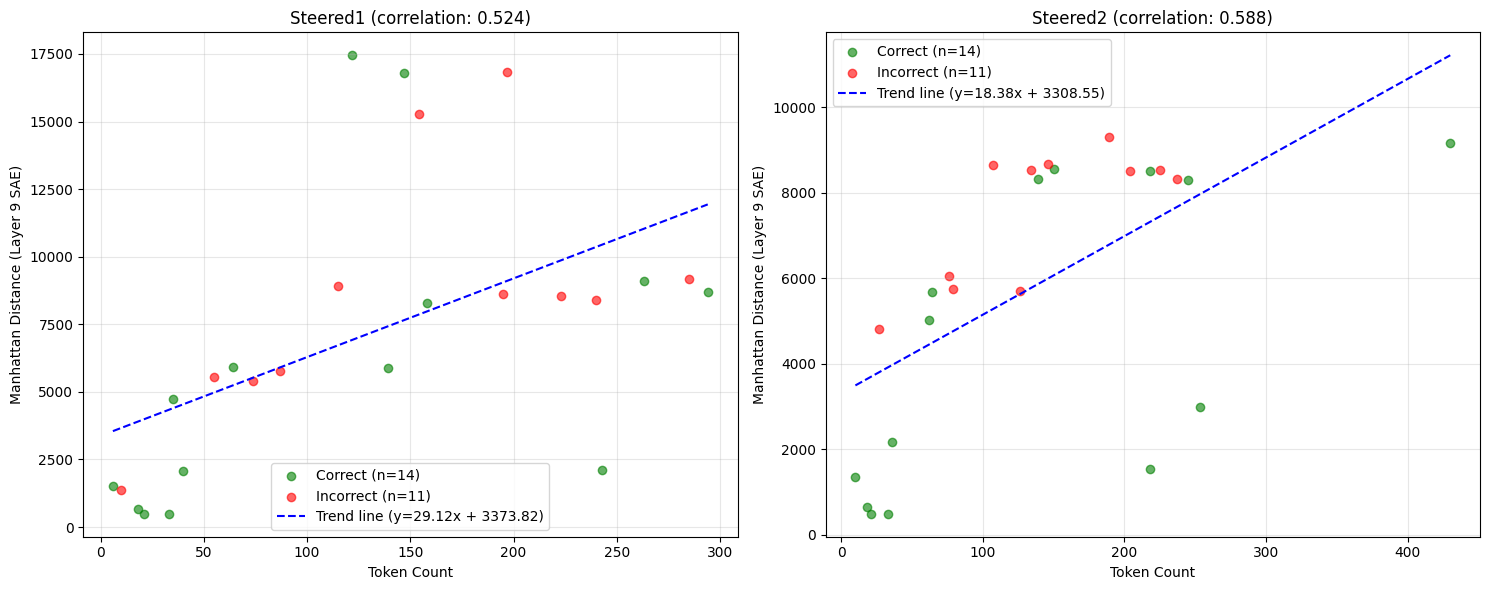


Detailed Statistics for Layer 9 SAE:

Steered1:
Overall correlation: 0.524
Correlation for correct answers: 0.465
Correlation for incorrect answers: 0.573

Steered2:
Overall correlation: 0.588
Correlation for correct answers: 0.639
Correlation for incorrect answers: 0.759


In [50]:
analyze_token_distance_correlation_single_layer(distances_df, correct_df, layer=9, type_name='SAE')

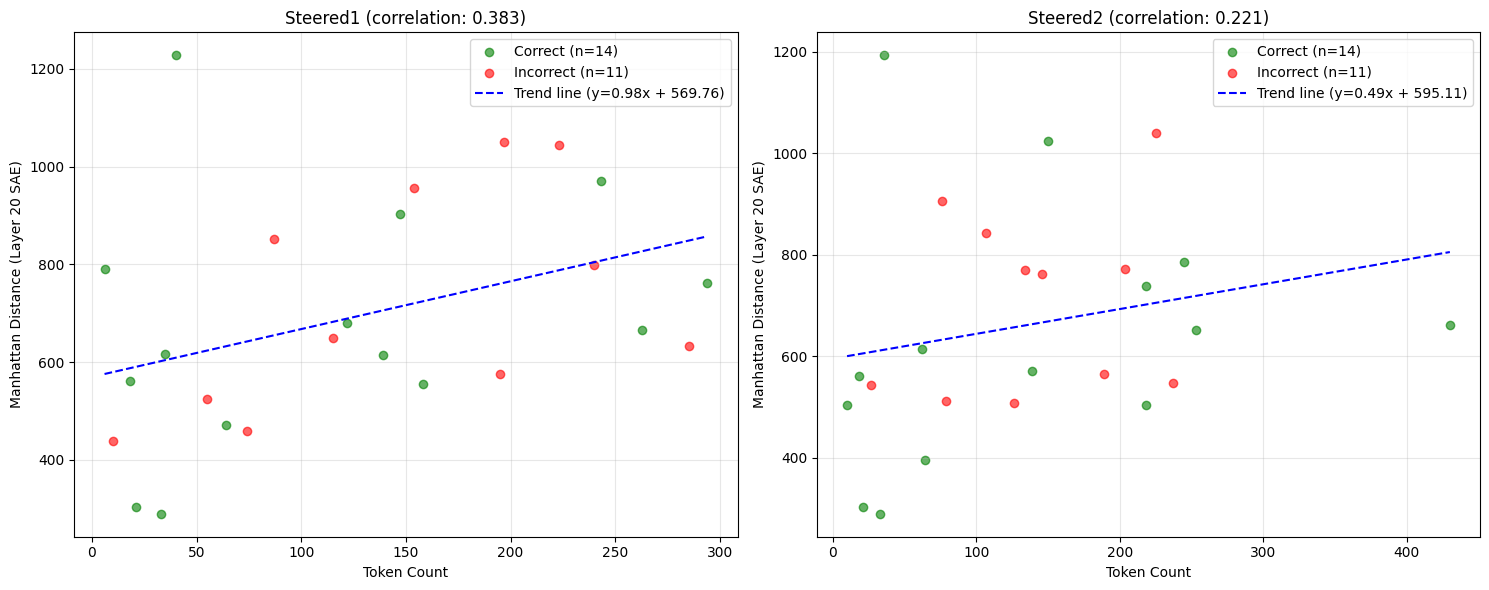


Detailed Statistics for Layer 20 SAE:

Steered1:
Overall correlation: 0.383
Correlation for correct answers: 0.283
Correlation for incorrect answers: 0.514

Steered2:
Overall correlation: 0.221
Correlation for correct answers: 0.224
Correlation for incorrect answers: 0.214


In [51]:
analyze_token_distance_correlation_single_layer(distances_df, correct_df, layer=20, type_name='SAE')


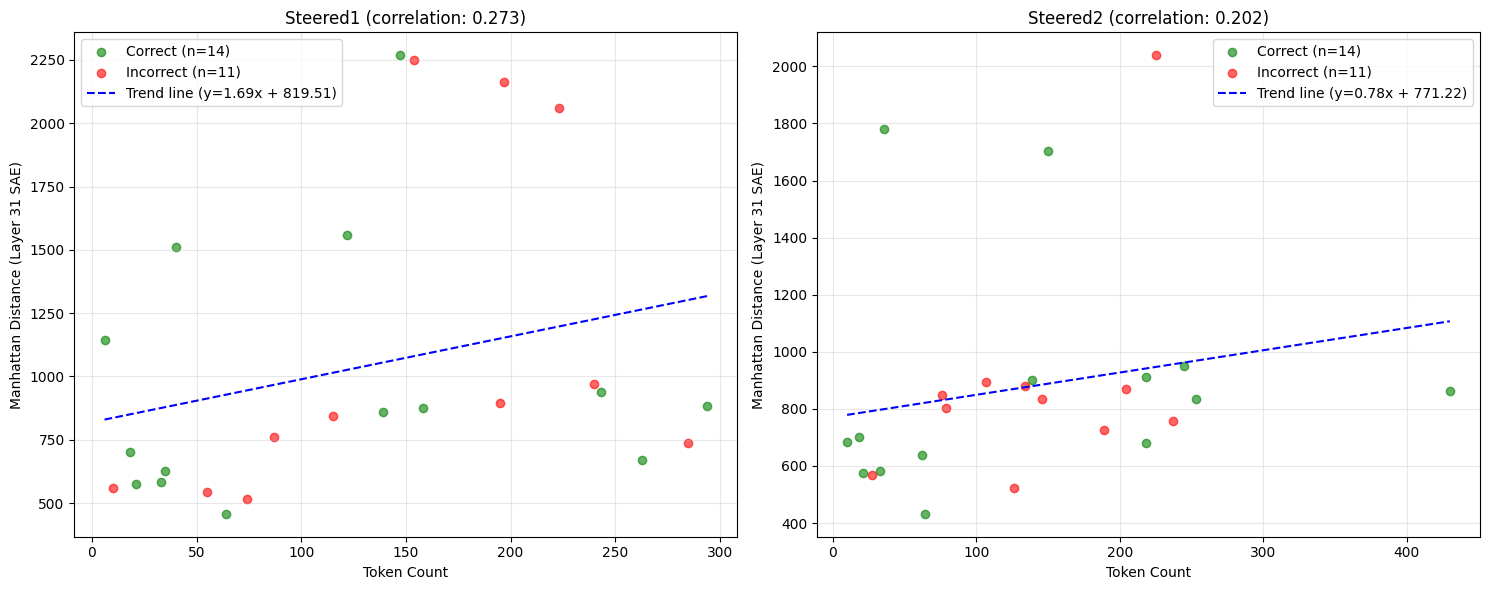


Detailed Statistics for Layer 31 SAE:

Steered1:
Overall correlation: 0.273
Correlation for correct answers: 0.101
Correlation for incorrect answers: 0.434

Steered2:
Overall correlation: 0.202
Correlation for correct answers: 0.104
Correlation for incorrect answers: 0.461


In [52]:
analyze_token_distance_correlation_single_layer(distances_df, correct_df, layer=31, type_name='SAE')

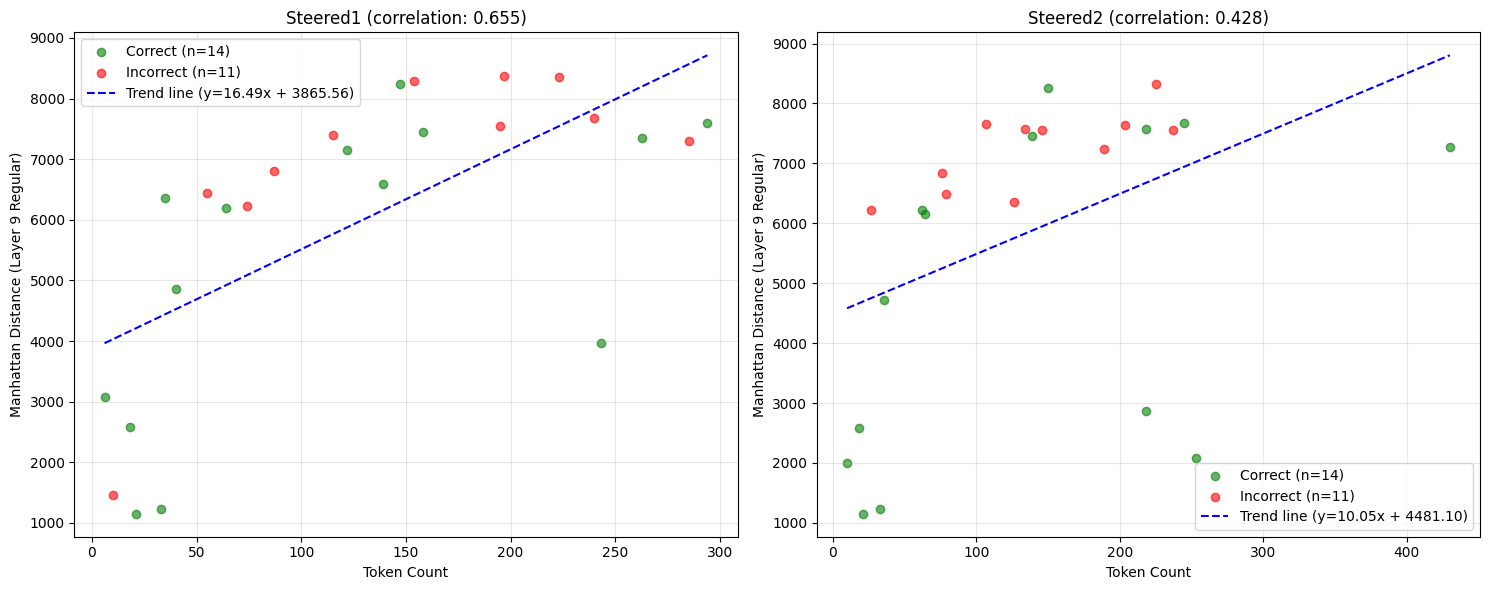


Detailed Statistics for Layer 9 Regular:

Steered1:
Overall correlation: 0.655
Correlation for correct answers: 0.610
Correlation for incorrect answers: 0.696

Steered2:
Overall correlation: 0.428
Correlation for correct answers: 0.471
Correlation for incorrect answers: 0.753


In [53]:
analyze_token_distance_correlation_single_layer(distances_df, correct_df, layer=9, type_name='Regular') #layer=20, #layer=31,

In [57]:
def analyze_token_count_comparison(correct_df):
    """
    Compare token counts between unsteered answers, correct steered answers, and incorrect steered answers.
    
    Args:
        correct_df: DataFrame containing the token counts and evaluation results
    """
    # Get token count columns
    unsteered_tokens_col = 'Output_Tokens_Answer_No_Steering'
    steered1_tokens_col = 'Output_Tokens_Answer_Steered1'
    steered2_tokens_col = 'Output_Tokens_Answer_Steered2'
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Process token lengths
    unsteered_lengths = correct_df[unsteered_tokens_col].apply(len)
    steered1_lengths = correct_df[steered1_tokens_col].apply(len)
    steered2_lengths = correct_df[steered2_tokens_col].apply(len)
    
    # Get correctness
    correctness1 = correct_df['evaluation'].apply(lambda x: int(x[1]))
    correctness2 = correct_df['evaluation'].apply(lambda x: int(x[2]))
    
    # Plot points
    # Correct answers
    plt.scatter(unsteered_lengths[correctness1 == 1], steered1_lengths[correctness1 == 1], 
               alpha=0.6, color='green', label=f'Correct (n={sum(correctness1 == 1) + sum(correctness2 == 1)})')
    plt.scatter(unsteered_lengths[correctness2 == 1], steered2_lengths[correctness2 == 1], 
               alpha=0.6, color='green')
    
    # Incorrect answers
    plt.scatter(unsteered_lengths[correctness1 == 0], steered1_lengths[correctness1 == 0], 
               alpha=0.6, color='red', label=f'Incorrect (n={sum(correctness1 == 0) + sum(correctness2 == 0)})')
    plt.scatter(unsteered_lengths[correctness2 == 0], steered2_lengths[correctness2 == 0], 
               alpha=0.6, color='red')
    
    # Add diagonal line for reference
    max_len = max(max(unsteered_lengths), max(steered1_lengths), max(steered2_lengths))
    plt.plot([0, max_len], [0, max_len], '--', color='gray', alpha=0.5, 
             label='Equal length')
    
    plt.title('Steered vs Unsteered Token Counts')
    plt.xlabel('Unsteered Token Count')
    plt.ylabel('Steered1&2 Token Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nToken Count Statistics:")
    print("=" * 60)
    
    # Calculate average lengths
    print("\nAverage Token Counts:")
    print(f"Unsteered: {unsteered_lengths.mean():.1f}")
    
    for steered_num, lengths, correctness in [
        (1, steered1_lengths, correctness1),
        (2, steered2_lengths, correctness2)
    ]:
        correct_mask = correctness == 1
        incorrect_mask = correctness == 0
        
        print(f"\nSteered{steered_num}:")
        print(f"Overall: {lengths.mean():.1f}")
        print(f"Correct answers: {lengths[correct_mask].mean():.1f}")
        print(f"Incorrect answers: {lengths[incorrect_mask].mean():.1f}")
        
        # Calculate correlations with unsteered
        corr_correct = np.corrcoef(unsteered_lengths[correct_mask], 
                                 lengths[correct_mask])[0,1]
        corr_incorrect = np.corrcoef(unsteered_lengths[incorrect_mask], 
                                   lengths[incorrect_mask])[0,1]
        
        print(f"\nCorrelations with unsteered:")
        print(f"Correct answers: {corr_correct:.3f}")
        print(f"Incorrect answers: {corr_incorrect:.3f}")



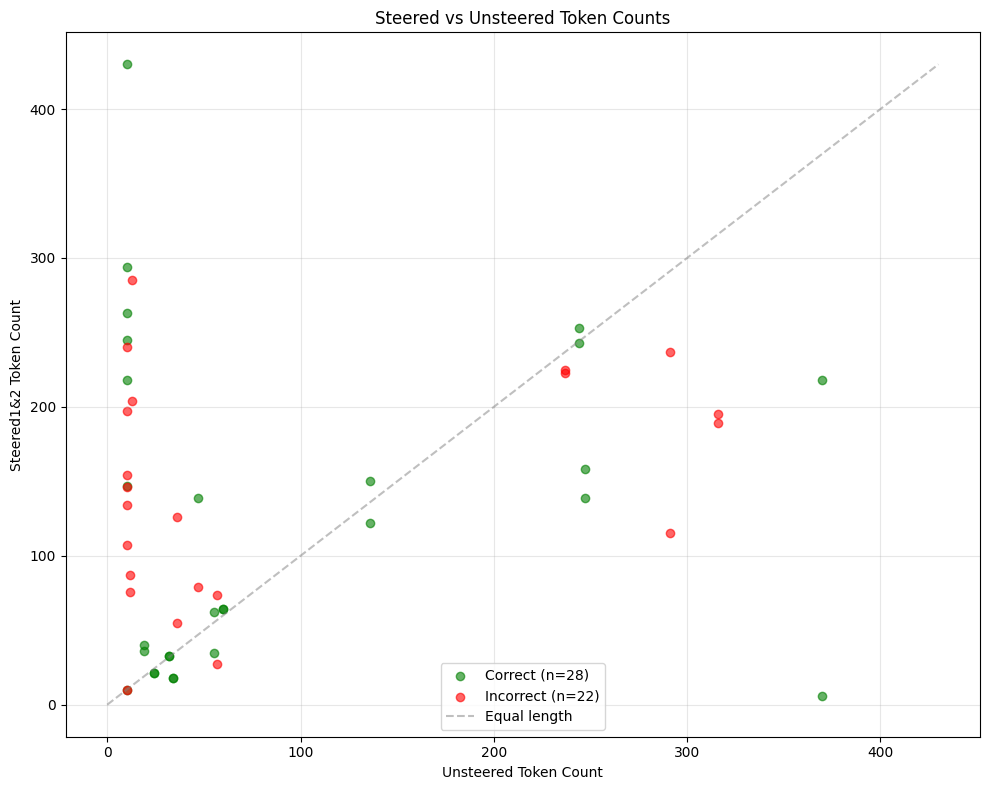


Token Count Statistics:

Average Token Counts:
Unsteered: 92.0

Steered1:
Overall: 128.7
Correct answers: 113.1
Incorrect answers: 148.6

Correlations with unsteered:
Correct answers: -0.051
Incorrect answers: 0.148

Steered2:
Overall: 137.9
Correct answers: 135.5
Incorrect answers: 140.9

Correlations with unsteered:
Correct answers: 0.244
Incorrect answers: 0.643


In [58]:
analyze_token_count_comparison(correct_df)

#### Distance and Scatter-Plot function
this gives an overall average and can also calculate the normalized version. Further down below is a function which only takes the Top-k activations

In [27]:
def calculate_all_manhattan_distances_and_plot(df, use_normalized=False, use_masked=False, show_plots=True):
    """
    Calculate Manhattan distances for all prompts and create visualization.
    Shows relationship between distances and correctness for each steered answer.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized distances
        use_masked: Boolean to use masked activations instead of regular ones
        show_plots: Boolean to control whether to display plots
        
    Returns:
        pandas DataFrame containing statistics for each layer/type combination
    """
    layers = [9, 20, 31]
    activation_types = ['Masked_'] if use_masked else ['SAE_', '']
    
    # Initialize list to store results for DataFrame
    results_data = []
    
    if show_plots:
        print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize dictionaries to store results
    results = {}
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            results[key] = {
                'x_values': [],  # Will store evaluation results (0 or 1)
                'y_values': [],  # Will store manhattan distances
                'steered_version': []  # Will store which steered version (1 or 2)
            }
    
    # Process each prompt
    for prompt_id in range(len(df)):
        # Get evaluation results for steered answers separately
        eval_list = df['evaluation'].iloc[prompt_id]
        steered1_eval = int(eval_list[1])  # Evaluation for steered1
        steered2_eval = int(eval_list[2])  # Evaluation for steered2
        
        # Calculate distances for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names based on whether we're using masked activations
                if use_masked:
                    unsteered_col = f'Masked_Unsteered_layer{layer}'
                    steered1_col = f'Masked_Steered1_layer{layer}'
                    steered2_col = f'Masked_Steered2_layer{layer}'
                else:
                    unsteered_col = f'{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get vectors
                    unsteered_vec = df[unsteered_col].iloc[prompt_id]
                    steered1_vec = df[steered1_col].iloc[prompt_id]
                    steered2_vec = df[steered2_col].iloc[prompt_id]
                    
                    # Calculate Manhattan distances
                    steered1_dist = calculate_manhattan_distance(unsteered_vec, steered1_vec, use_normalized)
                    steered2_dist = calculate_manhattan_distance(unsteered_vec, steered2_vec, use_normalized)
                    
                    key = f"{act_type}layer{layer}"
                    
                    # Store results separately for each steered version with its corresponding evaluation
                    results[key]['x_values'].extend([steered1_eval, steered2_eval])
                    results[key]['y_values'].extend([steered1_dist, steered2_dist])
                    results[key]['steered_version'].extend([1, 2])
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    continue
    
    # Process results and create plots
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            
            # Get values for analysis
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            if show_plots:
                # Create scatter plot
                plt.figure(figsize=(10, 6))
                
                # Add jitter to x-axis
                x_jitter = np.random.normal(0, 0.05, len(x_values))
                
                # Plot points with different colors for steered versions
                for steered_num in [1, 2]:
                    mask = steered_versions == steered_num
                    plt.scatter(x_values[mask] + x_jitter[mask], 
                              y_values[mask], 
                              alpha=0.5,
                              label=f'Steered {steered_num}')
                
                # Set labels and title
                activation_name = "Masked" if use_masked else ("SAE" if act_type == 'SAE_' else "Regular")
                plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
                plt.ylabel(f'Manhattan Distance for Layer {layer} {activation_name}' + 
                          (' (Normalized)' if use_normalized else ''))
                plt.title(f'Manhattan Distance vs. Evaluation Results for Layer {layer} {activation_name}' +
                          (' (Normalized)' if use_normalized else ''))
                
                plt.xticks([0, 1])
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.show()
            
            # Calculate statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_distances = [d for i, d in enumerate(steered_y_values) 
                                   if steered_x_values[i] == 1]
                incorrect_distances = [d for i, d in enumerate(steered_y_values) 
                                    if steered_x_values[i] == 0]
                
                # Store results in list
                results_data.append({
                    'Layer': layer,
                    'Type': "Masked" if use_masked else ("SAE" if act_type == 'SAE_' else "Regular"),
                    'Steered_Version': steered_num,
                    'Correct_Avg': np.mean(correct_distances) if correct_distances else np.nan,
                    'Incorrect_Avg': np.mean(incorrect_distances) if incorrect_distances else np.nan,
                    'N_Correct': len(correct_distances),
                    'N_Incorrect': len(incorrect_distances)
                })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results_data)
    
    return results_df

In [28]:
"""def calculate_all_manhattan_distances_and_plot(df, use_normalized=False, use_masked=False):
""""""
    Calculate Manhattan distances for all prompts and create visualization.
    Shows relationship between distances and correctness for each steered answer.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized distances
        use_masked: Boolean to use masked activations instead of regular ones
""""""
    layers = [9, 20, 31]
    activation_types = ['Masked_'] if use_masked else ['SAE_', '']
    
    print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize dictionaries to store results
    results = {}
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            results[key] = {
                'x_values': [],  # Will store evaluation results (0 or 1)
                'y_values': [],  # Will store manhattan distances
                'steered_version': []  # Will store which steered version (1 or 2)
            }
    
    # Process each prompt
    for prompt_id in range(len(df)):
        # Get evaluation results for steered answers separately
        eval_list = df['evaluation'].iloc[prompt_id]
        steered1_eval = int(eval_list[1])  # Evaluation for steered1
        steered2_eval = int(eval_list[2])  # Evaluation for steered2
        
        # Calculate distances for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names based on whether we're using masked activations
                if use_masked:
                    unsteered_col = f'Masked_Unsteered_layer{layer}'
                    steered1_col = f'Masked_Steered1_layer{layer}'
                    steered2_col = f'Masked_Steered2_layer{layer}'
                else:
                    unsteered_col = f'{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                # Get vectors
                unsteered_vec = df[unsteered_col].iloc[prompt_id]
                steered1_vec = df[steered1_col].iloc[prompt_id]
                steered2_vec = df[steered2_col].iloc[prompt_id]
                
                # Calculate Manhattan distances
                steered1_dist = calculate_manhattan_distance(unsteered_vec, steered1_vec, use_normalized)
                steered2_dist = calculate_manhattan_distance(unsteered_vec, steered2_vec, use_normalized)
                
                key = f"{act_type}layer{layer}"
                
                # Store results separately for each steered version with its corresponding evaluation
                results[key]['x_values'].extend([steered1_eval, steered2_eval])
                results[key]['y_values'].extend([steered1_dist, steered2_dist])
                results[key]['steered_version'].extend([1, 2])
    
    # Create plots for each layer and activation type
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            
            # Create scatter plot
            plt.figure(figsize=(10, 6))
            
            # Get values for plotting
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            # Add jitter to x-axis
            x_jitter = np.random.normal(0, 0.05, len(x_values))
            
            # Plot points with different colors for steered versions
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                plt.scatter(x_values[mask] + x_jitter[mask], 
                          y_values[mask], 
                          alpha=0.5,
                          label=f'Steered {steered_num}')
            
            # Set labels and title
            activation_name = "Masked" if use_masked else ("SAE" if act_type == 'SAE_' else "Regular")
            plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
            plt.ylabel(f'Manhattan Distance for Layer {layer} {activation_name}' + 
                      (' (Normalized)' if use_normalized else ''))
            plt.title(f'Manhattan Distance vs. Evaluation Results for Layer {layer} {activation_name}' +
                      (' (Normalized)' if use_normalized else ''))
            
            plt.xticks([0, 1])
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
            
            # Print statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_distances = [d for i, d in enumerate(steered_y_values) 
                                   if steered_x_values[i] == 1]
                incorrect_distances = [d for i, d in enumerate(steered_y_values) 
                                    if steered_x_values[i] == 0]
                
                print(f"\nStatistics for Layer {layer} {activation_name} - Steered {steered_num}:")
                if correct_distances:
                    print(f"Average distance for correct answers: {np.mean(correct_distances):.4f}")
                if incorrect_distances:
                    print(f"Average distance for incorrect answers: {np.mean(incorrect_distances):.4f}")
                print(f"Number of correct answers: {len(correct_distances)}")
                print(f"Number of incorrect answers: {len(incorrect_distances)}")"""

'def calculate_all_manhattan_distances_and_plot(df, use_normalized=False, use_masked=False):\n\n    Calculate Manhattan distances for all prompts and create visualization.\n    Shows relationship between distances and correctness for each steered answer.\n    \n    Args:\n        df: DataFrame containing the activation data\n        use_normalized: Boolean to toggle between normalized and non-normalized distances\n        use_masked: Boolean to use masked activations instead of regular ones\n\n    layers = [9, 20, 31]\n    activation_types = [\'Masked_\'] if use_masked else [\'SAE_\', \'\']\n    \n    print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")\n    \n    # Initialize dictionaries to store results\n    results = {}\n    for layer in layers:\n        for act_type in activation_types:\n            key = f"{act_type}layer{layer}"\n            results[key] = {\n                \'x_values\': [],  # Will store evaluation results (0 or 1)\n   

### Using all activations
#### Average value comparison

In [29]:
# Get results DataFrame
manhattan_results_df = calculate_all_manhattan_distances_and_plot(correct_df, use_normalized=False, show_plots=False)

# Display detailed results
print("\nDetailed Results Summary:")
print(manhattan_results_df.to_string(index=False))

# Calculate and display overall averages
print("\nOverall Averages:")
print("Correct answers average distance:", manhattan_results_df['Correct_Avg'].mean())
print("Incorrect answers average distance:", manhattan_results_df['Incorrect_Avg'].mean())

# Calculate averages by layer and type
print("\nAverages by Layer and Type:")
layer_type_averages = manhattan_results_df.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Layer and Type:")
print(layer_type_averages)
print("\nUnstacked view:")
print(layer_type_averages.unstack('Type'))

# Calculate averages by steered version and type
print("\nAverages by Steered Version and Type:")
version_type_averages = manhattan_results_df.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Version and Type:")
print(version_type_averages)
print("\nUnstacked view:")
print(version_type_averages.unstack('Type'))


Detailed Results Summary:
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1  6011.580629    8534.345348         14           11
     9     SAE                2  4518.427626    7528.451991         14           11
     9 Regular                1  5272.541710    6899.751703         14           11
     9 Regular                2  4802.630747    7222.145212         14           11
    20     SAE                1   672.058820     725.757646         14           11
    20     SAE                2   628.118766     706.098954         14           11
    20 Regular                1  6864.183978    7655.551159         14           11
    20 Regular                2  6426.559836    7689.440085         14           11
    31     SAE                1   974.530448    1117.818383         14           11
    31     SAE                2   873.654178     885.490889         14           11
    31 Regular                1 10403.196318   11

##### normalized stats

In [31]:
# Get results DataFrame
manhattan_results_df_norm = calculate_all_manhattan_distances_and_plot(correct_df, use_normalized=True, show_plots=False)

# Display detailed results
print("\nDetailed Results Summary:")
print(manhattan_results_df_norm.to_string(index=False))

# Calculate and display overall averages
print("\nOverall Averages:")
print("Correct answers average distance:", manhattan_results_df_norm['Correct_Avg'].mean())
print("Incorrect answers average distance:", manhattan_results_df_norm['Incorrect_Avg'].mean())

# Calculate averages by layer and type
print("\nAverages by Layer and Type:")
layer_type_averages = manhattan_results_df_norm.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Layer and Type:")
print(layer_type_averages)
print("\nUnstacked view:")
print(layer_type_averages.unstack('Type'))

# Calculate averages by steered version and type
print("\nAverages by Steered Version and Type:")
version_type_averages = manhattan_results_df_norm.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Version and Type:")
print(version_type_averages)
print("\nUnstacked view:")
print(version_type_averages.unstack('Type'))


Detailed Results Summary:
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1   122.500507     161.425470         14           11
     9     SAE                2    97.265758     144.049169         14           11
     9 Regular                1   581.557885     718.884083         14           11
     9 Regular                2   536.412340     393.713658         14           11
    20     SAE                1    23.489253      23.597212         14           11
    20     SAE                2    20.718811      21.125958         14           11
    20 Regular                1   147.186365     263.334716         14           11
    20 Regular                2   225.356909     275.435810         14           11
    31     SAE                1    18.533612      20.444466         14           11
    31     SAE                2    15.571401      15.574634         14           11
    31 Regular                1   236.616632     

#### plots

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


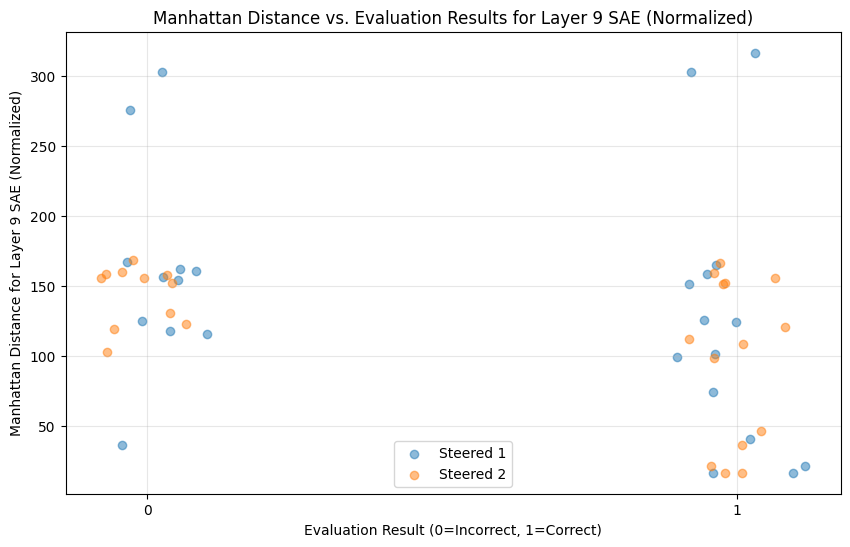

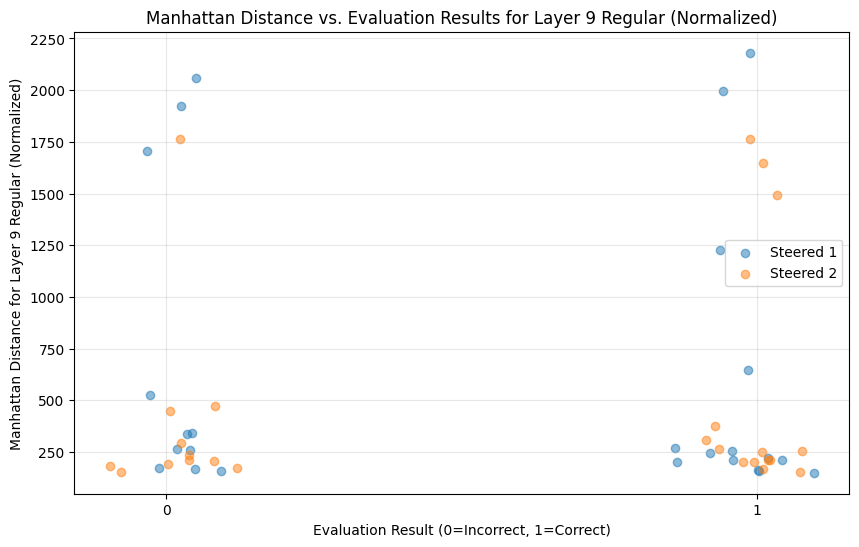

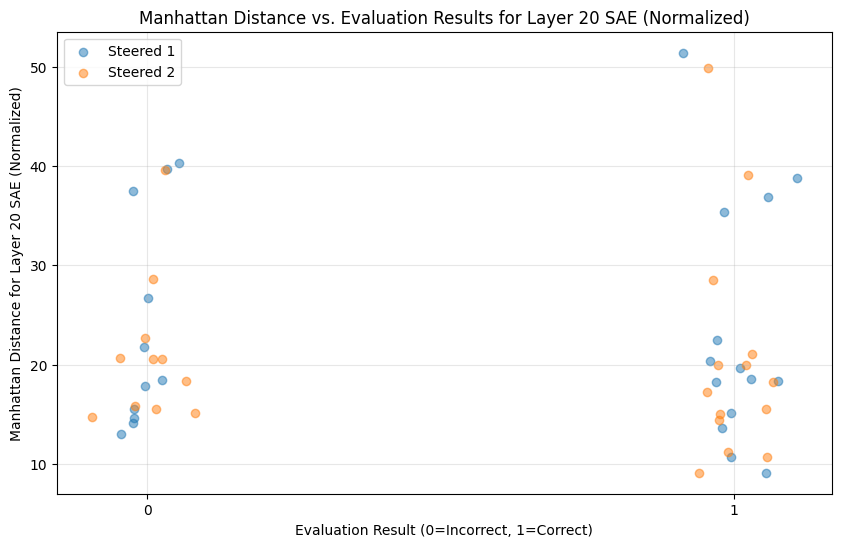

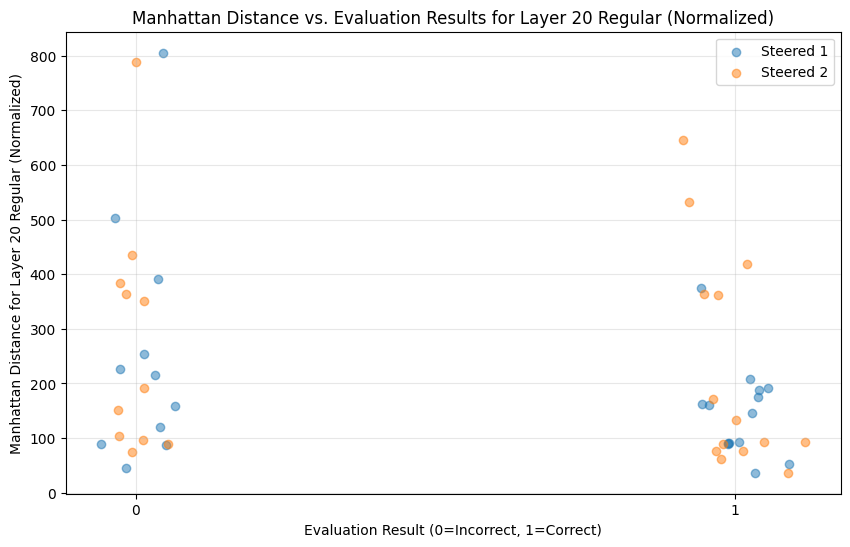

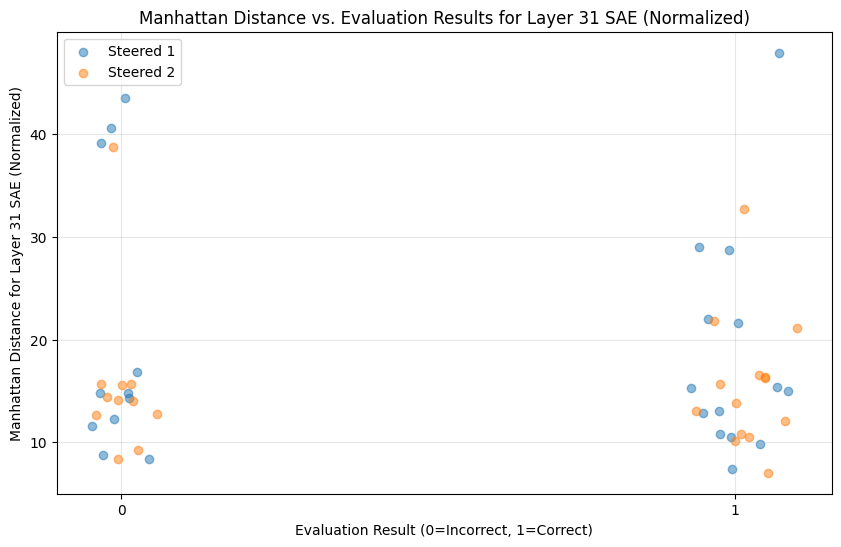

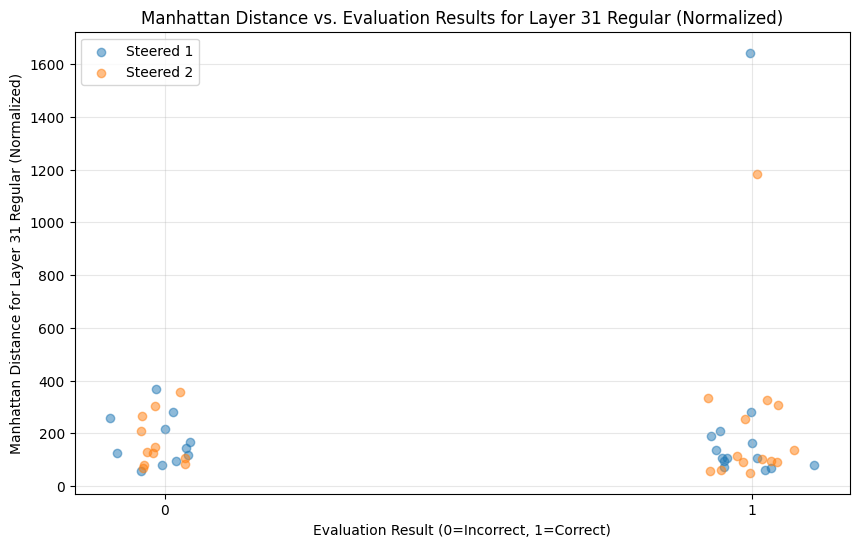

Layer     Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  \
0       9      SAE                1   122.500507     161.425470         14   
1       9      SAE                2    97.265758     144.049169         14   
2       9  Regular                1   581.557885     718.884083         14   
3       9  Regular                2   536.412340     393.713658         14   
4      20      SAE                1    23.489253      23.597212         14   
5      20      SAE                2    20.718811      21.125958         14   
6      20  Regular                1   147.186365     263.334716         14   
7      20  Regular                2   225.356909     275.435810         14   
8      31      SAE                1    18.533612      20.444466         14   
9      31      SAE                2    15.571401      15.574634         14   
10     31  Regular                1   236.616632     173.237293         14   
11     31  Regular                2   228.329371     170.187548         14   

    N_Incorrect  
0            11  
1            11  
2            11  
3            11  
4            11  
5            11  
6            11  
7            11  
8            11  
9            11  
10           11  
11           11

In [32]:
# For normalized distances:
#print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")

# Then run the analysis with masked activations
calculate_all_manhattan_distances_and_plot(correct_df, use_normalized=True, show_plots=True) #, use_masked=True)

# Compare with regular activations
#calculate_all_manhattan_distances_and_plot(correct_df, use_normalized=True, use_masked=False)

### Using only the top activations (of unsteered answers)   (Manhattan Distance)

In [98]:
def calculate_manhattan_distance_masked(df, use_normalized=False, show_plots=True):
    """
    Calculate Manhattan distances using only the extracted steered activations,
    treating all other activations as 0.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized distances
        show_plots: Boolean to control whether to display plots
        
    Returns:
        pandas DataFrame containing statistics for each layer/type combination
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    # Initialize list to store results for DataFrame
    results_data = []
    
    if show_plots:
        print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize results dictionary
    results = {}
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            results[key] = {
                'x_values': [],  # Will store evaluation results (0 or 1)
                'y_values': [],  # Will store manhattan distances
                'steered_version': []  # Will store which steered version (1 or 2)
            }
    
    def calculate_masked_distance(unsteered_data, steered_data, vector_length=131072, normalize=False):
        """
        Calculate Manhattan distance using only the extracted activations.
        All other positions are treated as 0.
        """
        # Initialize vectors with zeros
        unsteered_vec = np.zeros(vector_length)
        steered_vec = np.zeros(vector_length)
        
        # Fill in the extracted activations
        for idx, val in unsteered_data:
            unsteered_vec[idx] = val
        for idx, val in steered_data:
            steered_vec[idx] = val
            
        if normalize:
            # Normalize vectors to [-1, 1]
            unsteered_range = unsteered_vec.max() - unsteered_vec.min()
            if unsteered_range != 0:
                unsteered_vec = 2 * (unsteered_vec - unsteered_vec.min()) / unsteered_range - 1
                
            steered_range = steered_vec.max() - steered_vec.min()
            if steered_range != 0:
                steered_vec = 2 * (steered_vec - steered_vec.min()) / steered_range - 1
        
        return np.sum(np.abs(unsteered_vec - steered_vec))
    
    # Process each prompt
    for prompt_id in range(len(df)):
        # Get evaluation results for steered answers separately
        eval_list = df['evaluation'].iloc[prompt_id]
        steered1_eval = int(eval_list[1])  # Evaluation for steered1
        steered2_eval = int(eval_list[2])  # Evaluation for steered2
        
        # Calculate distances for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Get column names for top activations
                unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                steered1_col = f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                steered2_col = f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get activation data
                    unsteered_data = df[unsteered_col].iloc[prompt_id]
                    steered1_data = df[steered1_col].iloc[prompt_id]
                    steered2_data = df[steered2_col].iloc[prompt_id]
                    
                    if all(data is not None for data in [unsteered_data, steered1_data, steered2_data]):
                        # Calculate distances
                        dist1 = calculate_masked_distance(unsteered_data, steered1_data, normalize=use_normalized)
                        dist2 = calculate_masked_distance(unsteered_data, steered2_data, normalize=use_normalized)
                        
                        key = f"{act_type}layer{layer}"
                        
                        # Store results separately for each steered version with its corresponding evaluation
                        results[key]['x_values'].extend([steered1_eval, steered2_eval])
                        results[key]['y_values'].extend([dist1, dist2])
                        results[key]['steered_version'].extend([1, 2])
                        
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    continue
    
    # Process results and create plots
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            
            if not results[key]['x_values']:  # Skip if no data
                continue
                
            # Get values for analysis
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            if show_plots:
                # Create scatter plot
                plt.figure(figsize=(10, 6))
                
                # Add jitter to x-axis
                x_jitter = np.random.normal(0, 0.05, len(x_values))
                
                # Plot points with different colors for steered versions
                for steered_num in [1, 2]:
                    mask = steered_versions == steered_num
                    plt.scatter(x_values[mask] + x_jitter[mask], 
                              y_values[mask], 
                              alpha=0.5,
                              label=f'Steered {steered_num}')
                
                # Set labels and title
                activation_name = "SAE" if act_type == 'SAE_' else "Regular"
                plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
                plt.ylabel(f'Masked Manhattan Distance for Layer {layer} {activation_name}' + 
                          (' (Normalized)' if use_normalized else ''))
                plt.title(f'Masked Manhattan Distance vs. Evaluation Results for Layer {layer} {activation_name}' +
                          (' (Normalized)' if use_normalized else ''))
                
                plt.xticks([0, 1])
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.show()
            
            # Calculate statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_distances = [d for i, d in enumerate(steered_y_values) 
                                   if steered_x_values[i] == 1]
                incorrect_distances = [d for i, d in enumerate(steered_y_values) 
                                    if steered_x_values[i] == 0]
                
                # Store results in list
                results_data.append({
                    'Layer': layer,
                    'Type': 'SAE' if act_type == 'SAE_' else 'Regular',
                    'Steered_Version': steered_num,
                    'Correct_Avg': np.mean(correct_distances) if correct_distances else np.nan,
                    'Incorrect_Avg': np.mean(incorrect_distances) if incorrect_distances else np.nan,
                    'N_Correct': len(correct_distances),
                    'N_Incorrect': len(incorrect_distances)
                })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results_data)
    
    return results_df

#### Average value comparison

In [79]:
# Get results DataFrame
masked_manhattan_results_df = calculate_manhattan_distance_masked(correct_df, use_normalized=False, show_plots=False)

# Display detailed results
print("\nDetailed Results Summary:")
print(masked_manhattan_results_df.to_string(index=False))

# Calculate and display overall averages
print("\nOverall Averages:")
print("Correct answers average distance:", masked_manhattan_results_df['Correct_Avg'].mean())
print("Incorrect answers average distance:", masked_manhattan_results_df['Incorrect_Avg'].mean())

# Calculate averages by layer and type
print("\nAverages by Layer and Type:")
layer_type_averages = masked_manhattan_results_df.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Layer and Type:")
print(layer_type_averages)
print("\nUnstacked view:")
print(layer_type_averages.unstack('Type'))

# Calculate averages by steered version and type
print("\nAverages by Steered Version and Type:")
version_type_averages = masked_manhattan_results_df.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Version and Type:")
print(version_type_averages)
print("\nUnstacked view:")
print(version_type_averages.unstack('Type'))


Detailed Results Summary:
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1    91.741281     106.202222         14           11
     9     SAE                2    78.751964      93.355545         14           11
     9 Regular                1    54.527959      59.989274         14           11
     9 Regular                2    50.730764      44.301362         14           11
    20     SAE                1   210.070040     244.759037         14           11
    20     SAE                2   186.558045     225.736497         14           11
    20 Regular                1   104.442605     116.897565         14           11
    20 Regular                2    93.041372     104.254925         14           11
    31     SAE                1   356.840749     391.411733         14           11
    31     SAE                2   346.099101     326.897994         14           11
    31 Regular                1   160.995550     

##### normalized stats

In [80]:
# Get results DataFrame
masked_manhattan_results_df = calculate_manhattan_distance_masked(correct_df, use_normalized=True, show_plots=False)

# Display detailed results
print("\nDetailed Results Summary:")
print(masked_manhattan_results_df.to_string(index=False))

# Calculate and display overall averages
print("\nOverall Averages:")
print("Correct answers average distance:", masked_manhattan_results_df['Correct_Avg'].mean())
print("Incorrect answers average distance:", masked_manhattan_results_df['Incorrect_Avg'].mean())

# Calculate averages by layer and type
print("\nAverages by Layer and Type:")
layer_type_averages = masked_manhattan_results_df.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Layer and Type:")
print(layer_type_averages)
print("\nUnstacked view:")
print(layer_type_averages.unstack('Type'))

# Calculate averages by steered version and type
print("\nAverages by Steered Version and Type:")
version_type_averages = masked_manhattan_results_df.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print("\nDetailed by Version and Type:")
print(version_type_averages)
print("\nUnstacked view:")
print(version_type_averages.unstack('Type'))


Detailed Results Summary:
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1     3.568828       4.357336         14           11
     9     SAE                2     2.998018       3.524720         14           11
     9 Regular                1 11169.589142   13038.561237         14           11
     9 Regular                2  6353.817067    6404.019302         14           11
    20     SAE                1     6.511371       7.080469         14           11
    20     SAE                2     5.884983       6.782689         14           11
    20 Regular                1  8912.095254    8577.671714         14           11
    20 Regular                2  6439.771252    3758.509496         14           11
    31     SAE                1     6.406342       7.542679         14           11
    31     SAE                2     5.827914       6.121160         14           11
    31 Regular                1  4477.817838   10

#### Plots

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


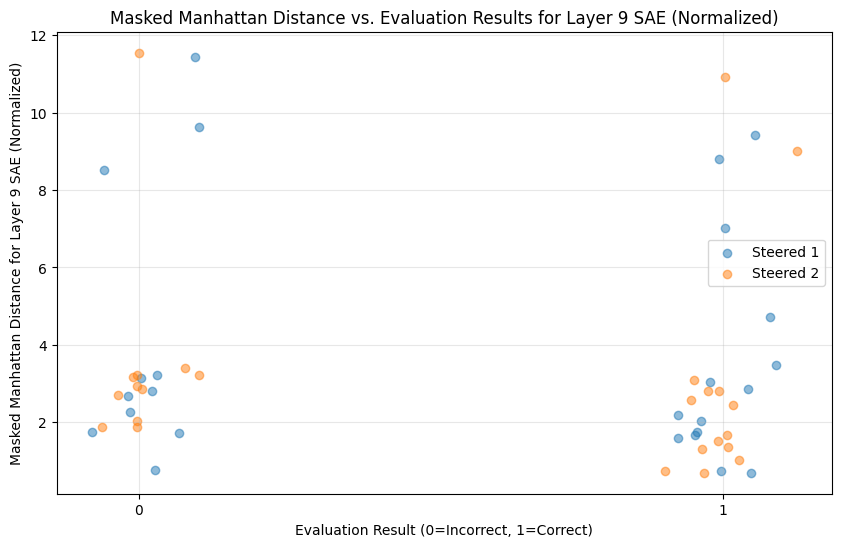

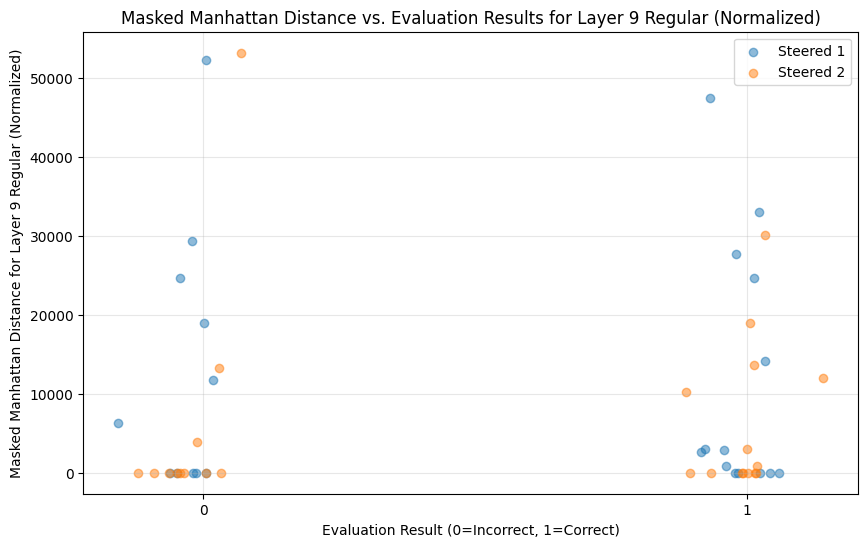

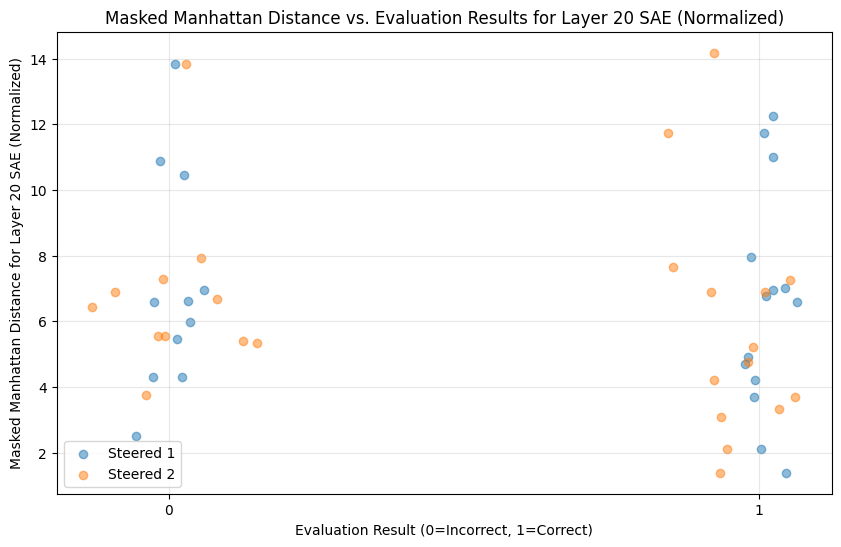

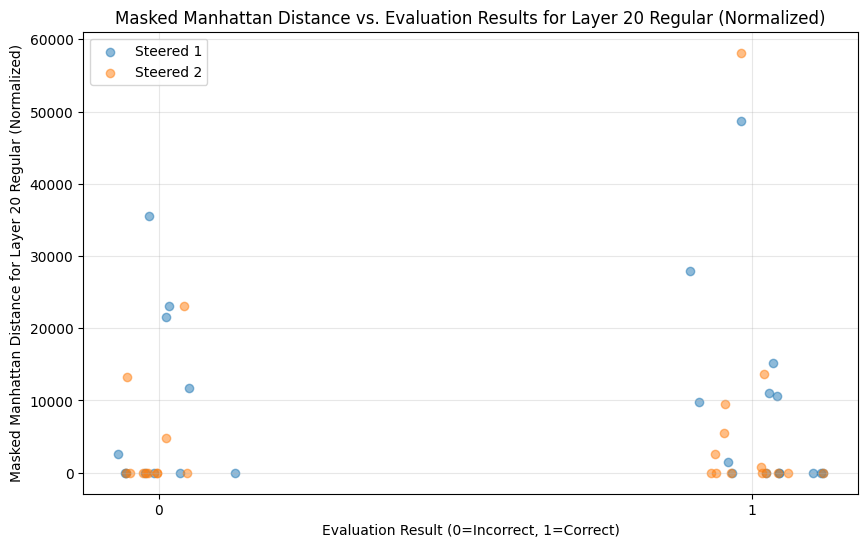

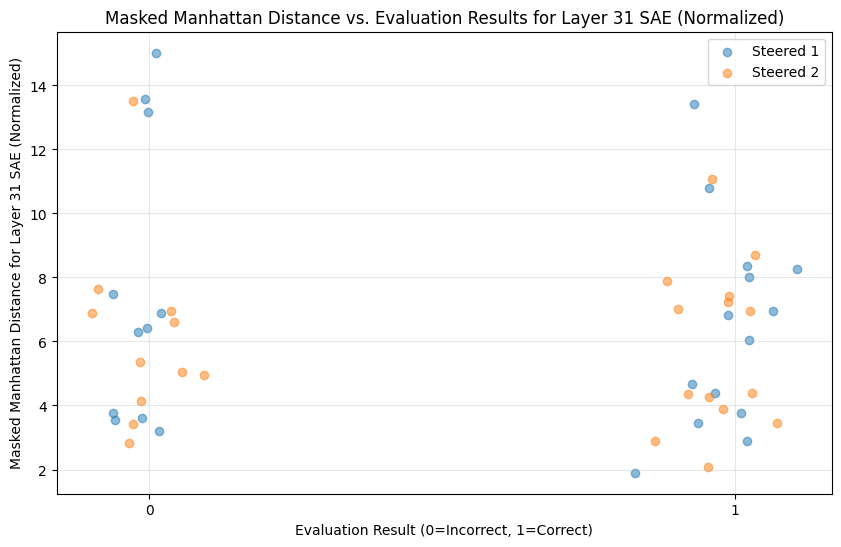

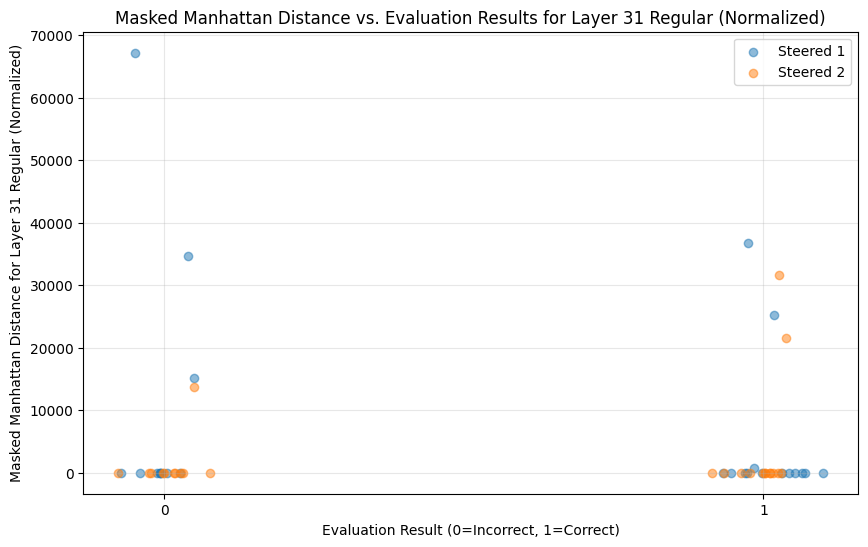

Layer     Type  Steered_Version   Correct_Avg  Incorrect_Avg  N_Correct  \
0       9      SAE                1      3.568828       4.357336         14   
1       9      SAE                2      2.998018       3.524720         14   
2       9  Regular                1  11169.589142   13038.561237         14   
3       9  Regular                2   6353.817067    6404.019302         14   
4      20      SAE                1      6.511371       7.080469         14   
5      20      SAE                2      5.884983       6.782689         14   
6      20  Regular                1   8912.095254    8577.671714         14   
7      20  Regular                2   6439.771252    3758.509496         14   
8      31      SAE                1      6.406342       7.542679         14   
9      31      SAE                2      5.827914       6.121160         14   
10     31  Regular                1   4477.817838   10633.037741         14   
11     31  Regular                2   3793.152602    1246.013740         14   

    N_Incorrect  
0            11  
1            11  
2            11  
3            11  
4            11  
5            11  
6            11  
7            11  
8            11  
9            11  
10           11  
11           11

In [81]:
# For normalized distances:
calculate_manhattan_distance_masked(correct_df, use_normalized=True, show_plots=True)


NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


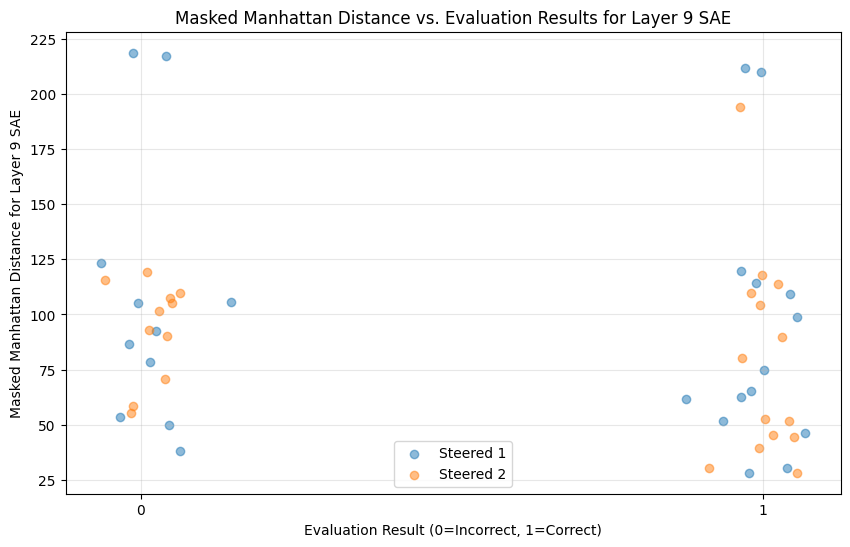


Statistics for Layer 9 SAE - Steered 1:
Average distance for correct answers: 91.7413
Average distance for incorrect answers: 106.2022
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average distance for correct answers: 78.7520
Average distance for incorrect answers: 93.3555
Number of correct answers: 14
Number of incorrect answers: 11


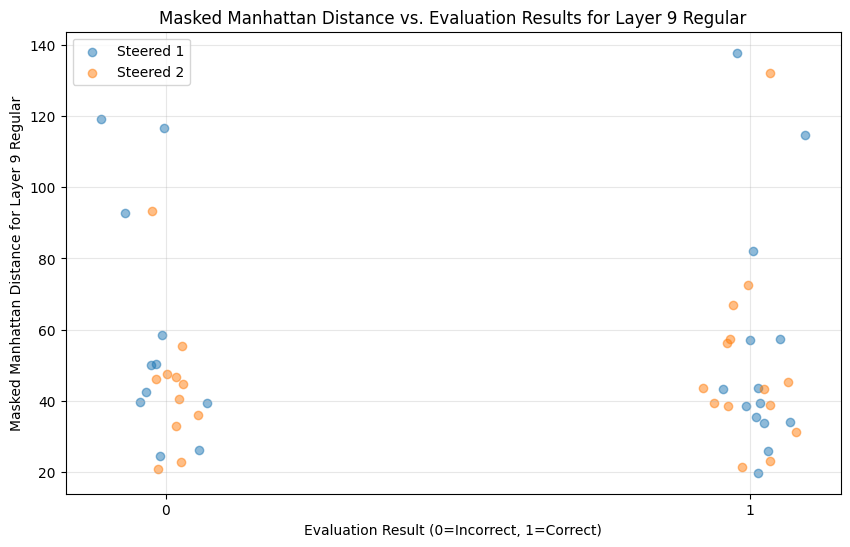


Statistics for Layer 9 Regular - Steered 1:
Average distance for correct answers: 54.5280
Average distance for incorrect answers: 59.9893
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average distance for correct answers: 50.7308
Average distance for incorrect answers: 44.3014
Number of correct answers: 14
Number of incorrect answers: 11


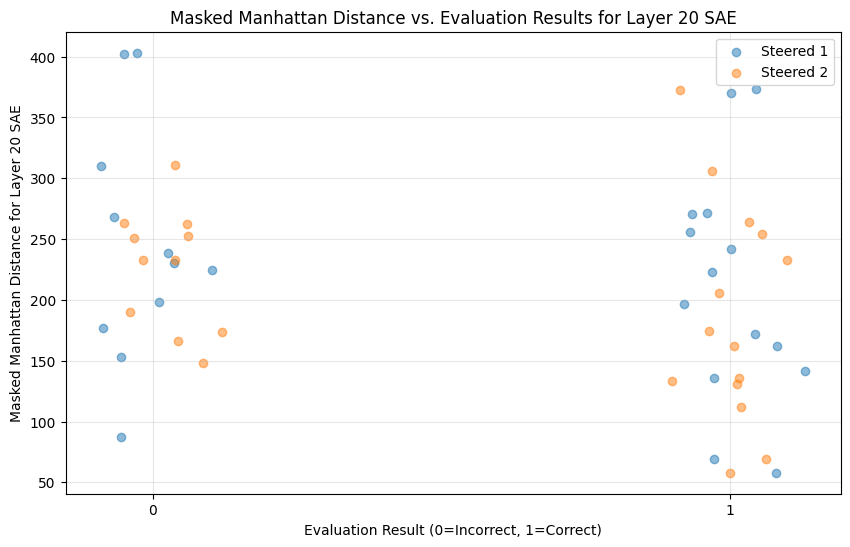


Statistics for Layer 20 SAE - Steered 1:
Average distance for correct answers: 210.0700
Average distance for incorrect answers: 244.7590
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average distance for correct answers: 186.5580
Average distance for incorrect answers: 225.7365
Number of correct answers: 14
Number of incorrect answers: 11


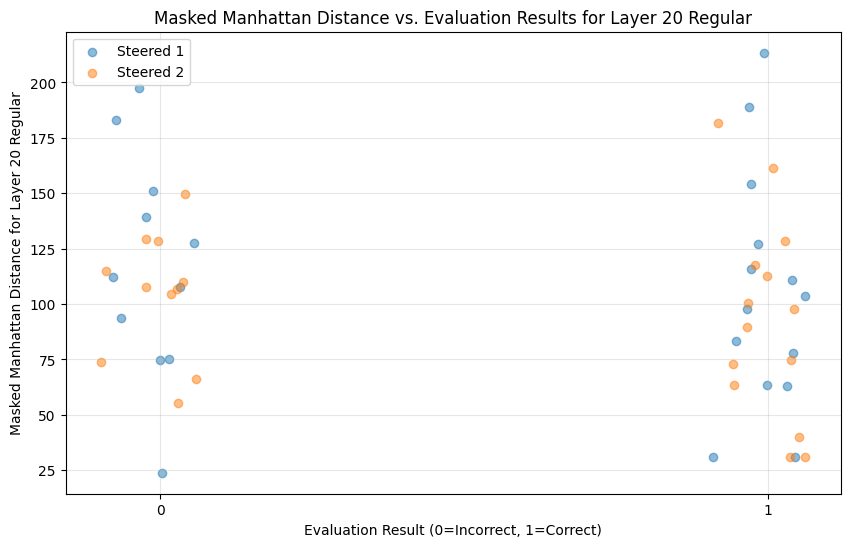


Statistics for Layer 20 Regular - Steered 1:
Average distance for correct answers: 104.4426
Average distance for incorrect answers: 116.8976
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average distance for correct answers: 93.0414
Average distance for incorrect answers: 104.2549
Number of correct answers: 14
Number of incorrect answers: 11


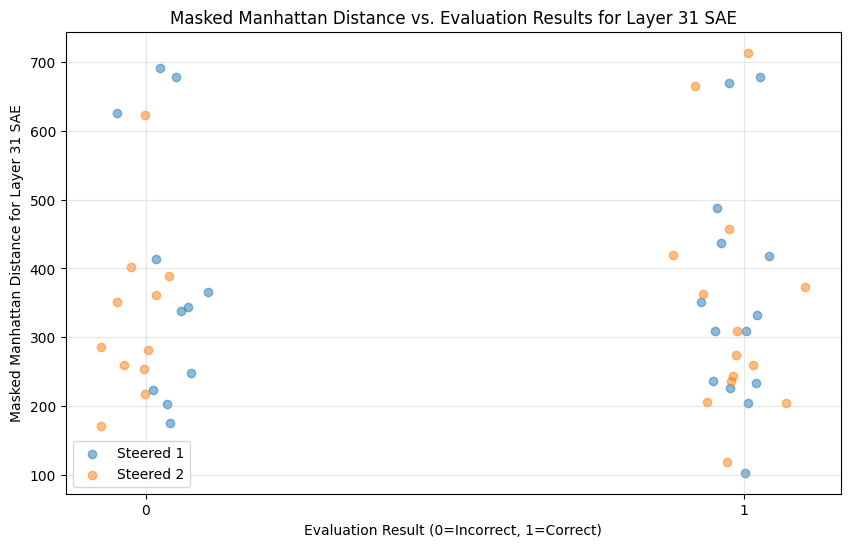


Statistics for Layer 31 SAE - Steered 1:
Average distance for correct answers: 356.8407
Average distance for incorrect answers: 391.4117
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average distance for correct answers: 346.0991
Average distance for incorrect answers: 326.8980
Number of correct answers: 14
Number of incorrect answers: 11


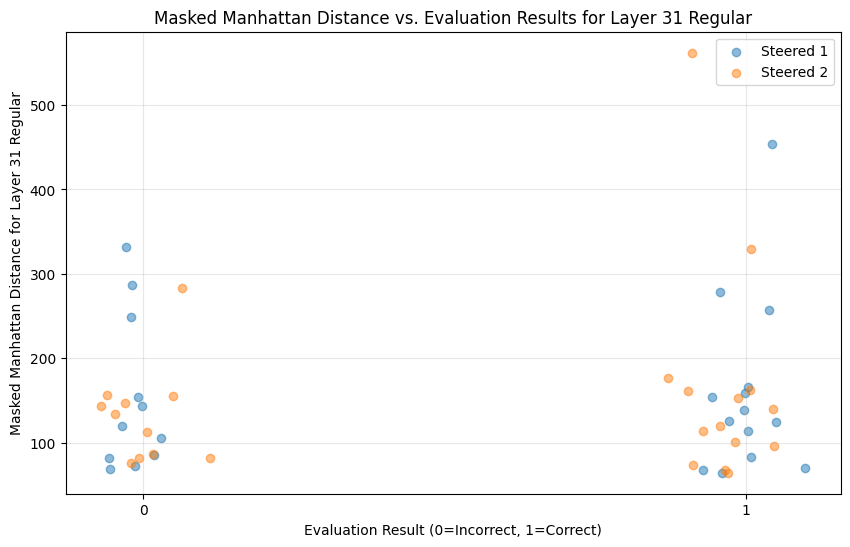


Statistics for Layer 31 Regular - Steered 1:
Average distance for correct answers: 160.9955
Average distance for incorrect answers: 154.1358
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average distance for correct answers: 165.5089
Average distance for incorrect answers: 132.4030
Number of correct answers: 14
Number of incorrect answers: 11


In [30]:
# For regular distances:
calculate_manhattan_distance_masked(correct_df, use_normalized=False)

#### Distributions of top activation distances

##### Adapted function calculate_and_store_manhattan_distances_masked()

In [ ]:
def calculate_and_store_manhattan_distances_masked(df, use_normalized=False, use_individual_tops=False):
    """
    Calculate Manhattan distances between unsteered and steered answers for top activations and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized distances
        use_individual_tops: Boolean to toggle between using masked (False) or individual (True) top activations
    
    Returns:
        pandas DataFrame containing all Manhattan distances for top activations
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    vector_length = 131072  # Full vector length for masked calculation
    
    # Initialize lists to store data
    data = []
    
    def calculate_masked_distance(unsteered_data, steered_data, normalize=False):
        """Calculate Manhattan distance using only the extracted activations"""
        # Initialize vectors with zeros
        unsteered_vec = np.zeros(vector_length)
        steered_vec = np.zeros(vector_length)
        
        # Fill in the extracted activations
        for idx, val in unsteered_data:
            unsteered_vec[idx] = val
        for idx, val in steered_data:
            steered_vec[idx] = val
            
        if normalize:
            # Normalize vectors to [-1, 1]
            unsteered_range = unsteered_vec.max() - unsteered_vec.min()
            if unsteered_range != 0:
                unsteered_vec = 2 * (unsteered_vec - unsteered_vec.min()) / unsteered_range - 1
                
            steered_range = steered_vec.max() - steered_vec.min()
            if steered_range != 0:
                steered_vec = 2 * (steered_vec - steered_vec.min()) / steered_range - 1
        
        return np.sum(np.abs(unsteered_vec - steered_vec))
    
    def calculate_individual_distance(unsteered_data, steered_data, normalize=False):
        """Calculate Manhattan distance using individual top activations"""
        # Convert data to dictionaries for easier lookup
        unsteered_dict = dict(unsteered_data)
        steered_dict = dict(steered_data)
        
        # Get all unique indices
        all_indices = set(unsteered_dict.keys()) | set(steered_dict.keys())
        
        # Calculate differences
        total_distance = 0
        for idx in all_indices:
            unsteered_val = unsteered_dict.get(idx, 0)
            steered_val = steered_dict.get(idx, 0)
            
            if normalize:
                # Normalize individual values (optional, might want to adjust this normalization strategy)
                max_val = max(abs(unsteered_val), abs(steered_val))
                if max_val != 0:
                    unsteered_val = unsteered_val / max_val
                    steered_val = steered_val / max_val
            
            total_distance += abs(unsteered_val - steered_val)
        
        return total_distance
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate distances for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names for top activations
                if use_individual_tops:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Top_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Top_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                else:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get activation data
                    unsteered_data = df[unsteered_col].iloc[prompt_id]
                    steered1_data = df[steered1_col].iloc[prompt_id]
                    steered2_data = df[steered2_col].iloc[prompt_id]
                    
                    if any(data is None for data in [unsteered_data, steered1_data, steered2_data]):
                        continue
                    
                    # Calculate distances using selected method
                    if use_individual_tops:
                        steered1_dist = calculate_individual_distance(unsteered_data, steered1_data, use_normalized)
                        steered2_dist = calculate_individual_distance(unsteered_data, steered2_data, use_normalized)
                    else:
                        steered1_dist = calculate_masked_distance(unsteered_data, steered1_data, use_normalized)
                        steered2_dist = calculate_masked_distance(unsteered_data, steered2_data, use_normalized)
                    
                    # Store distances in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dist'] = steered1_dist
                    row_data[f'{col_prefix}_layer{layer}_steered2_dist'] = steered2_dist
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dist'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_dist'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    distances_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        distances_df['source_folder'] = df['source_folder']
    
    return distances_df

###### Output

C:\Users\Maximus\AppData\Local\Temp\ipykernel_39356\1655117768.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i,j].legend()


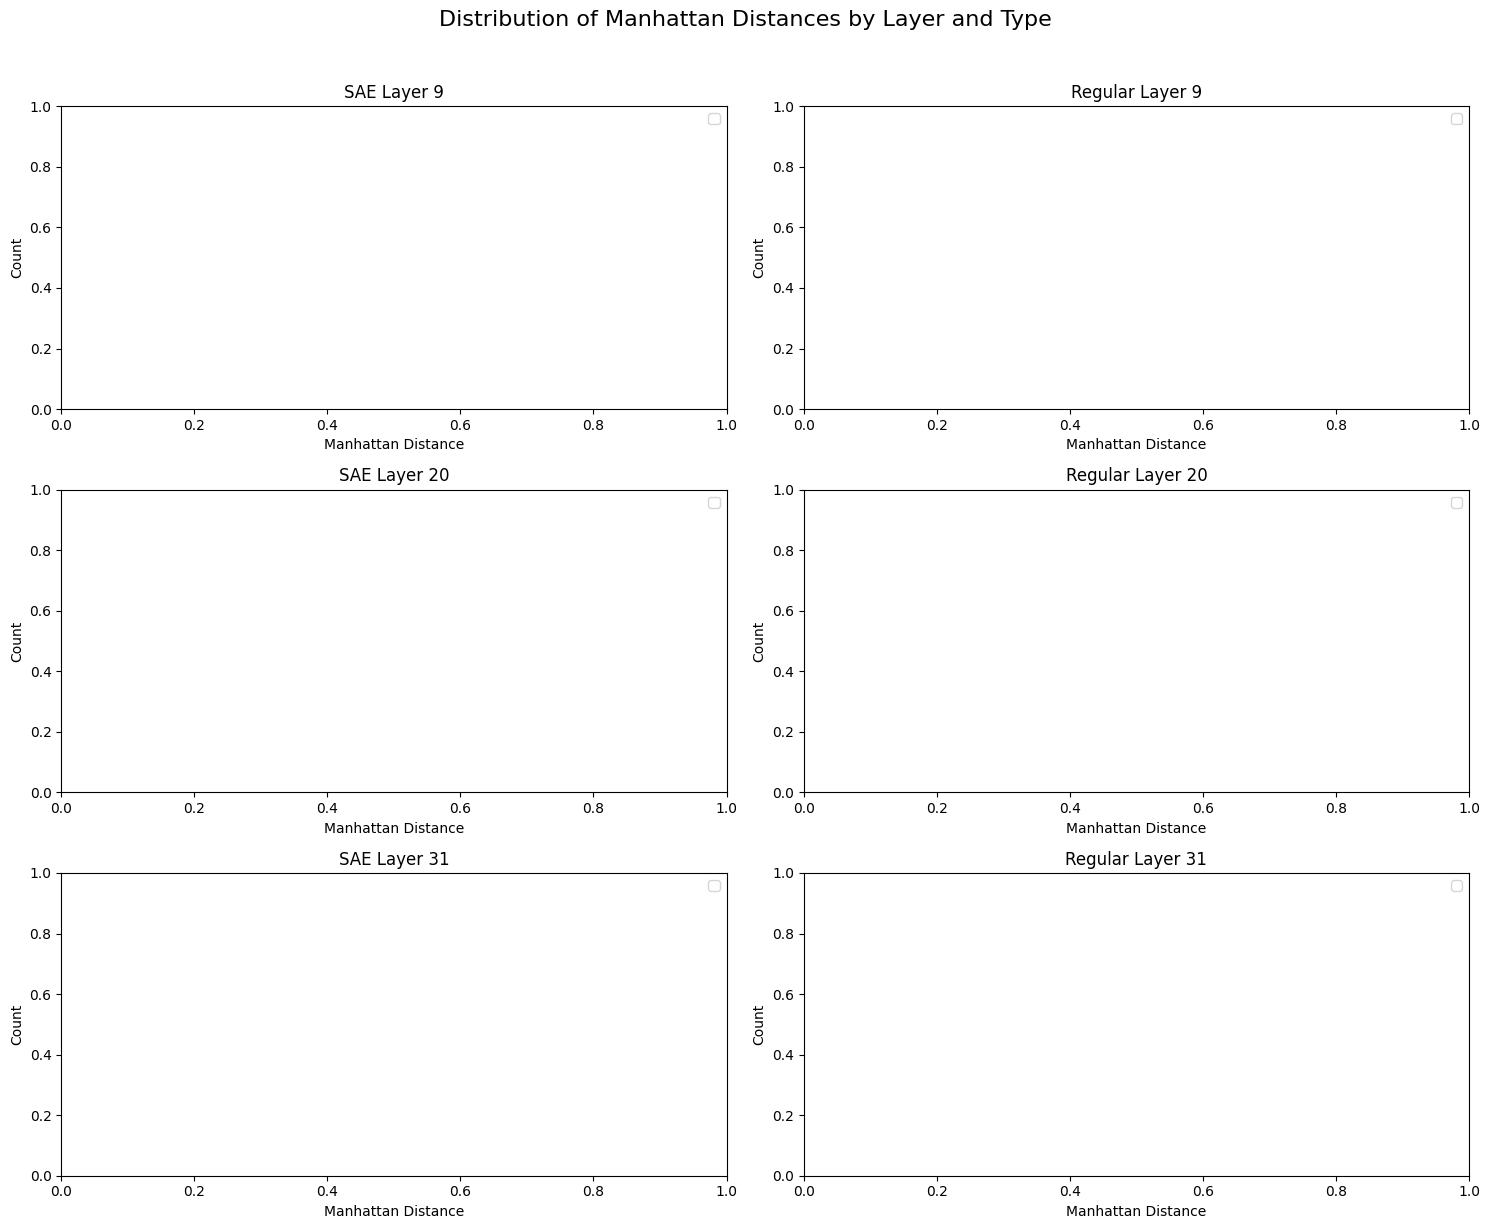


Statistics Summary:
Empty DataFrame
Columns: []
Index: []


In [82]:
# Calculate distances for masked data
distances_df_masked = calculate_and_store_manhattan_distances_masked(correct_df, use_normalized=False, use_individual_tops=False)

# Analyze and visualize the results
stats_manhattan_masked_df = analyze_manhattan_distancesv2(distances_df_masked)

In [ ]:
# Calculate distances for individual tops data
distances_df_tops = calculate_and_store_manhattan_distances_masked(correct_df, use_normalized=False, use_individual_tops=True)

# Analyze and visualize the results
stats_manhattan_tops_df = analyze_manhattan_distancesv2(distances_df_tops)

##### Distance to Length Comparison with only top activations (using unsteered output tops)
Note that the top activation neuron or latent indeces correspond to the top_k activations of the *unsteered* answer, which is then applied as a mask to the other answer's activation vectors. It's NOT the top 20 activations of each individual answer. (!)

In [ ]:
analyze_token_distance_correlation_single_layer(distances_df_masked, correct_df, layer=9, type_name='SAE')

In [ ]:
analyze_token_distance_correlation_single_layer(distances_df_masked, correct_df, layer=31, type_name='SAE')

## Cosine similarity between SAE activations

In [93]:
def calculate_cosine_similarity(vec1, vec2, bNormalize=False):
    """
    Calculate cosine similarity between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating similarity
    
    Returns:
        float: Cosine similarity between the vectors
    """
    # Convert to numpy arrays and flatten
    vec1 = np.array(vec1).flatten()
    vec2 = np.array(vec2).flatten()
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    # Calculate cosine similarity
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Avoid division by zero
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
        
    return dot_product / (norm_vec1 * norm_vec2)

In [72]:
#import matplotlib.pyplot as plt
use_normalized = False  # USE THE NORMALIZED OR NORMAL COSINE SIM FOR PLOT
use_top_activations = False  # Whether to use top 10 SAE activations instead of all SAE activations

In [71]:
def calculate_all_cosine_similarities_and_plot(df, use_normalized=False, show_plots=True):
    """
    Calculate cosine similarities for all prompts and create visualization.
    Shows relationship between similarities and correctness for each steered answer.
    Returns results in a pandas DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized similarities
        show_plots: Boolean to control whether to display plots
    
    Returns:
        pandas DataFrame containing statistics for each layer/type combination
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    if show_plots:
        print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize lists to store results for DataFrame
    results_data = []
    
    # Initialize dictionaries to store results for each layer and activation type
    results = {}
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            results[key] = {
                'x_values': [],  # Will store evaluation results (0 or 1)
                'y_values': [],  # Will store cosine similarities
                'steered_version': []  # Will store which steered version (1 or 2)
            }
    
    # Process each prompt
    for prompt_id in range(len(df)):
        # Get evaluation results for steered answers
        steered_evals = get_steered_evaluations(df['evaluation'].iloc[prompt_id])
        
        # Calculate similarities for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Get column names
                unsteered_col = f"{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass"
                steered1_col = f"{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass"
                steered2_col = f"{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass"
                
                # Get vectors
                unsteered_vec = df[unsteered_col].iloc[prompt_id]
                steered1_vec = df[steered1_col].iloc[prompt_id]
                steered2_vec = df[steered2_col].iloc[prompt_id]
                
                # Calculate similarities
                sim1 = calculate_cosine_similarity(unsteered_vec, steered1_vec, use_normalized)
                sim2 = calculate_cosine_similarity(unsteered_vec, steered2_vec, use_normalized)
                
                key = f"{act_type}layer{layer}"
                
                # Store results
                results[key]['x_values'].extend([steered_evals[0], steered_evals[1]])
                results[key]['y_values'].extend([sim1, sim2])
                results[key]['steered_version'].extend([1, 2])
    
    # Process results and create plots
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            
            # Get values for analysis
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            if show_plots:
                # Create scatter plot
                plt.figure(figsize=(10, 6))
                
                # Add jitter to x-axis
                x_jitter = np.random.normal(0, 0.05, len(x_values))
                
                # Plot points with different colors for steered versions
                for steered_num in [1, 2]:
                    mask = steered_versions == steered_num
                    plt.scatter(x_values[mask] + x_jitter[mask], 
                              y_values[mask], 
                              alpha=0.5,
                              label=f'Steered {steered_num}')
                
                # Set labels and title
                activation_name = "SAE" if act_type == 'SAE_' else "Regular"
                plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
                plt.ylabel(f'Cosine Similarity for Layer {layer} {activation_name}' + 
                          (' (Normalized)' if use_normalized else ''))
                plt.title(f'Cosine Similarity vs. Evaluation Results for Layer {layer} {activation_name}' +
                          (' (Normalized)' if use_normalized else ''))
                
                # Set x-axis ticks and add grid
                plt.xticks([0, 1])
                plt.grid(True, alpha=0.3)
                plt.legend()
                
                plt.show()
            
            # Calculate statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_similarities = [s for i, s in enumerate(steered_y_values) 
                                     if steered_x_values[i] == 1]
                incorrect_similarities = [s for i, s in enumerate(steered_y_values) 
                                       if steered_x_values[i] == 0]
                
                # Store results in list
                results_data.append({
                    'Layer': layer,
                    'Type': 'SAE' if act_type == 'SAE_' else 'Regular',
                    'Steered_Version': steered_num,
                    'Correct_Avg': np.mean(correct_similarities) if correct_similarities else np.nan,
                    'Incorrect_Avg': np.mean(incorrect_similarities) if incorrect_similarities else np.nan,
                    'N_Correct': len(correct_similarities),
                    'N_Incorrect': len(incorrect_similarities)
                })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results_data)
    
    return results_df

In [78]:
results_cosineSM_df = calculate_all_cosine_similarities_and_plot(correct_df, use_normalized=False, show_plots=False)


In [79]:

# Display results
print("\nResults Summary:")
print(results_cosineSM_df.to_string(index=False))


Results Summary:
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1     0.420633       0.312771         14           11
     9     SAE                2     0.492855       0.341272         14           11
     9 Regular                1     0.645687       0.551598         14           11
     9 Regular                2     0.705955       0.574230         14           11
    20     SAE                1     0.653139       0.625465         14           11
    20     SAE                2     0.700559       0.692641         14           11
    20 Regular                1     0.815113       0.790633         14           11
    20 Regular                2     0.841480       0.796110         14           11
    31     SAE                1     0.763857       0.709416         14           11
    31     SAE                2     0.793967       0.831757         14           11
    31 Regular                1     0.812224       0.78754

In [80]:
# Calculate and display overall averages
print("\nOverall Averages:")
print("Correct answers average similarity:", results_cosineSM_df['Correct_Avg'].mean())
print("Incorrect answers average similarity:", results_cosineSM_df['Incorrect_Avg'].mean())

# Calculate averages by layer
print("\nAverages by Layer and Type:")
layer_type_averages = results_cosineSM_df.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(layer_type_averages)

# For easier reading, unstack the results to show SAE and Regular in separate columns
print("\nAverages by Layer and Type (Unstacked):")
print(layer_type_averages.unstack('Type'))

# Calculate averages by type (SAE vs Regular)
print("\nAverages by Type:")
type_averages = results_cosineSM_df.groupby('Type').agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(type_averages)

# Calculate averages by steered version
print("\nAverages by Steered Version and Type:")
version_averages = results_cosineSM_df.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(version_type_averages)


# For easier reading, you can also unstack the results
print("\nAverages by Steered Version and Type (Unstacked):")
print(version_type_averages.unstack('Type'))


Overall Averages:
Correct answers average similarity: 0.7062186381086798
Incorrect answers average similarity: 0.6549933657439748

Averages by Layer and Type:
               Correct_Avg  Incorrect_Avg
Layer Type                               
9     Regular       0.6758         0.5629
      SAE           0.4567         0.3270
20    Regular       0.8283         0.7934
      SAE           0.6768         0.6591
31    Regular       0.8207         0.8170
      SAE           0.7789         0.7706

Averages by Layer and Type (Unstacked):
      Correct_Avg         Incorrect_Avg        
Type      Regular     SAE       Regular     SAE
Layer                                          
9          0.6758  0.4567        0.5629  0.3270
20         0.8283  0.6768        0.7934  0.6591
31         0.8207  0.7789        0.8170  0.7706

Averages by Type:
         Correct_Avg  Incorrect_Avg
Type                               
Regular       0.7749         0.7244
SAE           0.6375         0.5856

Averages by

In [69]:
# For normalized similarities:
# calculate_all_cosine_similarities_and_plot(correct_df, use_normalized=True) 


In [4]:
#Average distance manual calc
#((0.457-0.327)+(0.677-0.660)+(0.779-0.771))/3

((0.676-0.563)+(0.828-0.793)+(0.82-0.817))/3

0.05033333333333334

##### Don't use: normalized cosine similarity
--> confusing because it takes the normalization across all answers' layers.
This then results in rounding issues and almost everything ends up being 0.9999 similar (probably due to some outliers and massive differences between the answer's latents activations). There may be ways to make this more useful, but for now it seems a bit fruitless.

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


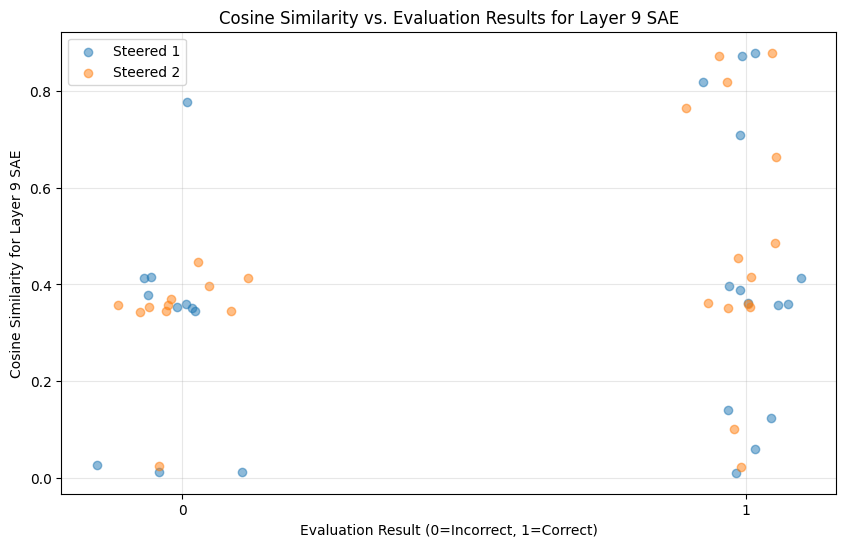

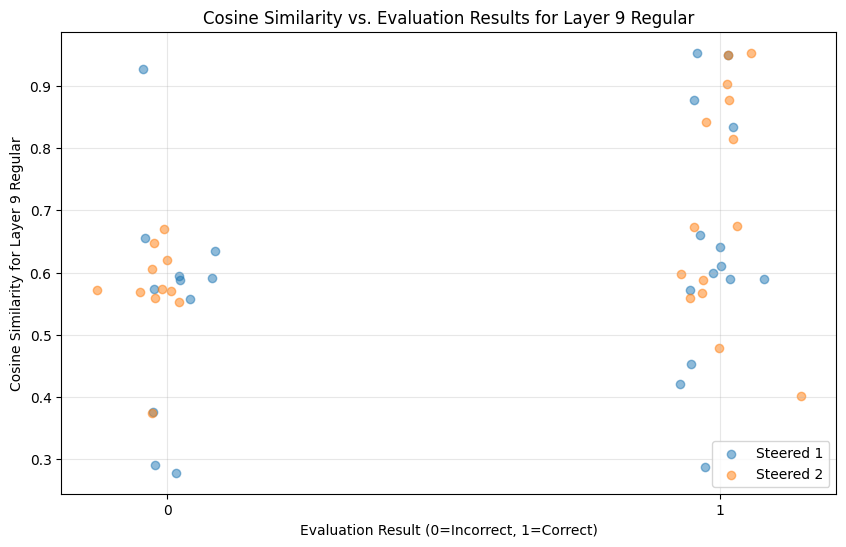

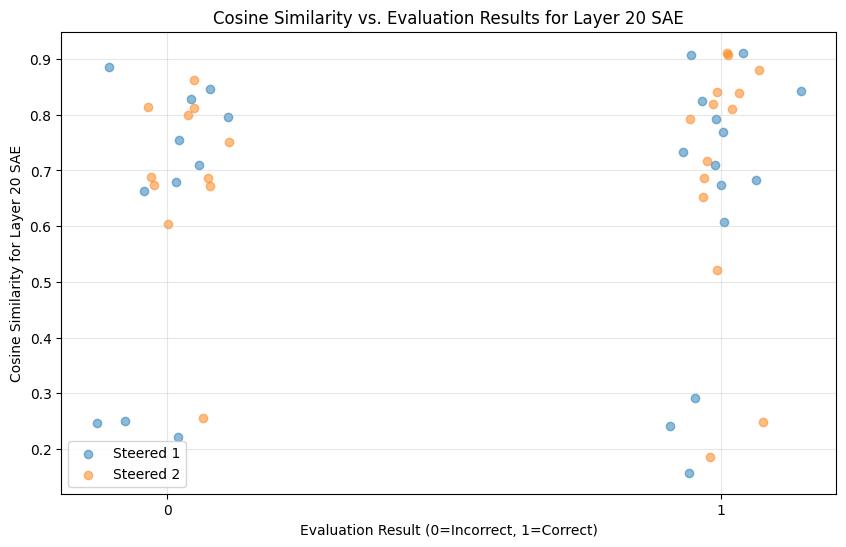

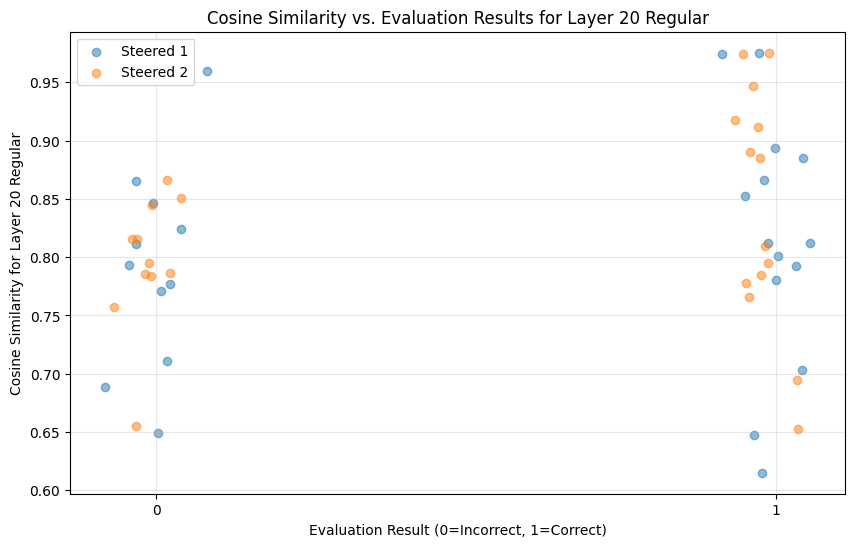

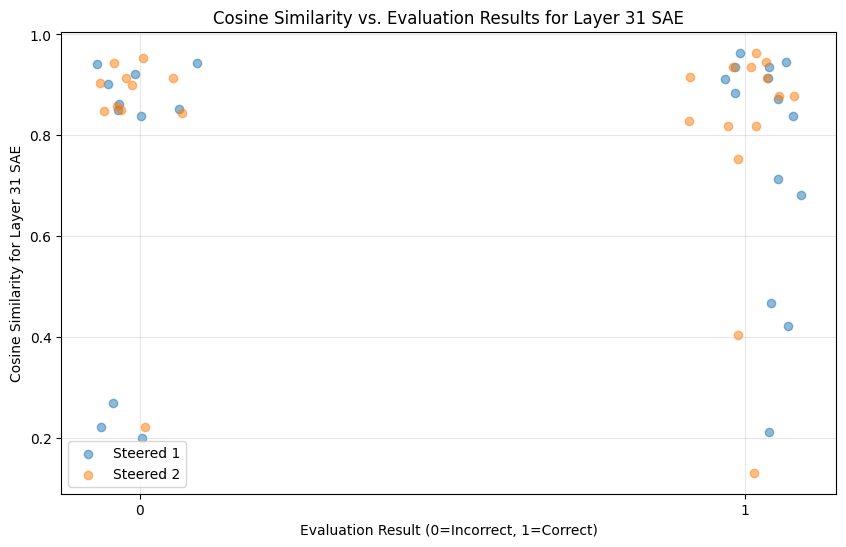

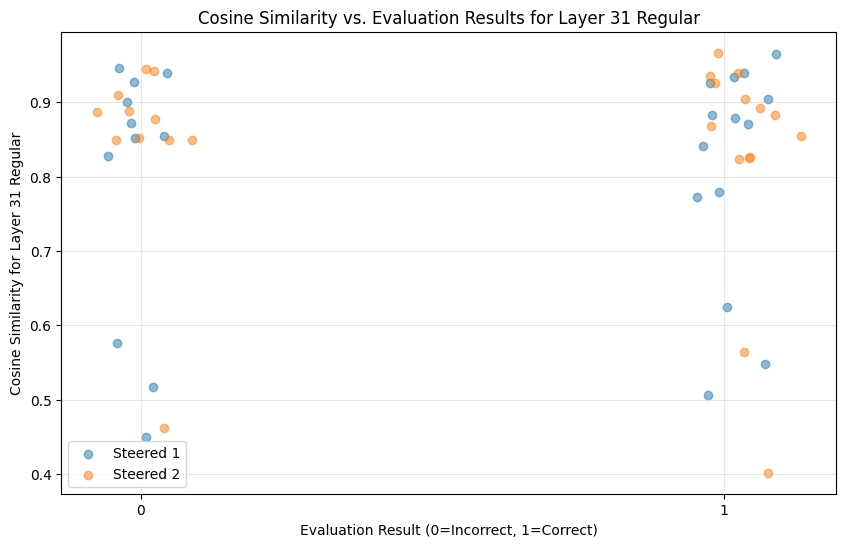

Layer     Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  \
0       9      SAE                1     0.420633       0.312771         14   
1       9      SAE                2     0.492855       0.341272         14   
2       9  Regular                1     0.645687       0.551598         14   
3       9  Regular                2     0.705955       0.574230         14   
4      20      SAE                1     0.653139       0.625465         14   
5      20      SAE                2     0.700559       0.692641         14   
6      20  Regular                1     0.815113       0.790633         14   
7      20  Regular                2     0.841480       0.796110         14   
8      31      SAE                1     0.763857       0.709416         14   
9      31      SAE                2     0.793967       0.831757         14   
10     31  Regular                1     0.812224       0.787540         14   
11     31  Regular                2     0.829155       0.846489         14   

    N_Incorrect  
0            11  
1            11  
2            11  
3            11  
4            11  
5            11  
6            11  
7            11  
8            11  
9            11  
10           11  
11           11

In [70]:
# For non-normalized similarities:
calculate_all_cosine_similarities_and_plot(correct_df, use_normalized=False)

#### RESULTS:  Dataset V2:
**Impressively, the general average similarity for incorrect answers is lower than for the correct answers!!**

CAREFUL: Normalized vectors are clearly wrong. Should be the same as non-normalized. Some rounding error is likely. Look at all activations across the entire dataset to normalize doesn't make sense, especially for cosine sim!

Stastical analysis, comparing the average cosine similarities per layer seems to actually show consistent results!! **Exciting**

### Cosine Similarity: Using only top actvns

##### calculate_cosine_similarity_masekd

In [87]:
def calculate_cosine_similarity_masked(df, use_normalized=False, show_plots=True):
    """
    Calculate cosine similarities using only the extracted steered activations.
    Returns results in a pandas DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized similarities
        show_plots: Boolean to control whether to display plots
    
    Returns:
        pandas DataFrame containing statistics for each layer/type combination
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    vector_length = 131072
    
    # Initialize list to store results for DataFrame
    results_data = []
    
    if show_plots:
        print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize results dictionary
    results = {f"{act_type}layer{layer}": {'x_values': [], 'y_values': [], 'steered_version': []} 
              for layer in layers for act_type in activation_types}
    
    def calculate_cosine_sim(vec1_data, vec2_data):
        """Calculate cosine similarity between two sets of (index, value) pairs"""
        # Create dictionaries for easy lookup
        dict1 = dict(vec1_data)
        dict2 = dict(vec2_data)
        
        # Get all unique indices
        all_indices = set(dict1.keys()) | set(dict2.keys())
        
        # Create vectors only for the relevant indices
        vec1 = np.array([dict1.get(idx, 0.0) for idx in all_indices])
        vec2 = np.array([dict2.get(idx, 0.0) for idx in all_indices])
        
        # Normalize if requested
        if use_normalized and len(vec1) > 0:
            vec1_range = vec1.max() - vec1.min()
            vec2_range = vec2.max() - vec2.min()
            
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate cosine similarity
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        
        if norm1 == 0 or norm2 == 0:
            return 0
        return dot_product / (norm1 * norm2)
    
    # Process each prompt
    for prompt_id in range(len(df)):
        steered_evals = get_steered_evaluations(df['evaluation'].iloc[prompt_id])
        
        for layer in layers:
            for act_type in activation_types:
                try:
                    # Get column names
                    cols = [
                        f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass',
                        f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass',
                        f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                    ]
                    
                    # Get activation data
                    vectors = [df[col].iloc[prompt_id] for col in cols]
                    if any(v is None for v in vectors):
                        continue
                    
                    # Calculate similarities
                    sim1 = calculate_cosine_sim(vectors[0], vectors[1])
                    sim2 = calculate_cosine_sim(vectors[0], vectors[2])
                    
                    # Store results
                    key = f"{act_type}layer{layer}"
                    results[key]['x_values'].extend([steered_evals[0], steered_evals[1]])
                    results[key]['y_values'].extend([sim1, sim2])
                    results[key]['steered_version'].extend([1, 2])
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    continue
    
    # Process results and create plots
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            if not results[key]['x_values']:
                continue
            
            # Get values for analysis
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            if show_plots:
                plt.figure(figsize=(10, 6))
                
                # Add jitter and plot
                x_jitter = np.random.normal(0, 0.05, len(x_values))
                for steered_num in [1, 2]:
                    mask = steered_versions == steered_num
                    plt.scatter(x_values[mask] + x_jitter[mask], 
                              y_values[mask], 
                              alpha=0.5,
                              label=f'Steered {steered_num}')
                
                # Set labels and title
                activation_name = "SAE" if act_type == 'SAE_' else "Regular"
                plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
                plt.ylabel(f'Masked Cosine Similarity for Layer {layer} {activation_name}' + 
                          (' (Normalized)' if use_normalized else ''))
                plt.title(f'Masked Cosine Similarity vs. Evaluation Results for Layer {layer} {activation_name}' +
                          (' (Normalized)' if use_normalized else ''))
                
                plt.xticks([0, 1])
                plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
                
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show()
            
            # Calculate statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_similarities = steered_y_values[steered_x_values == 1]
                incorrect_similarities = steered_y_values[steered_x_values == 0]
                
                # Store results in list
                results_data.append({
                    'Layer': layer,
                    'Type': 'SAE' if act_type == 'SAE_' else 'Regular',
                    'Steered_Version': steered_num,
                    'Correct_Avg': np.mean(correct_similarities) if len(correct_similarities) > 0 else np.nan,
                    'Incorrect_Avg': np.mean(incorrect_similarities) if len(incorrect_similarities) > 0 else np.nan,
                    'N_Correct': len(correct_similarities),
                    'N_Incorrect': len(incorrect_similarities)
                })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results_data)
    
    return results_df

##### Output

In [88]:
# Get results DataFrame for masked version
masked_cos_simi_results_df = calculate_cosine_similarity_masked(correct_df, use_normalized=False, show_plots=False)

# Display detailed results
print("\nDetailed Results Summary (Masked):")
print(masked_cos_simi_results_df.to_string(index=False))

# Calculate and display overall averages
print("\nOverall Averages (Masked):")
print("Correct answers average similarity:", masked_cos_simi_results_df['Correct_Avg'].mean())
print("Incorrect answers average similarity:", masked_cos_simi_results_df['Incorrect_Avg'].mean())

# Calculate averages by layer and type
print("\nAverages by Layer and Type (Masked):")
layer_type_averages = masked_cos_simi_results_df.groupby(['Layer', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(layer_type_averages)

# For easier reading, unstack the results to show SAE and Regular in separate columns
print("\nAverages by Layer and Type (Unstacked):")
print(layer_type_averages.unstack('Type'))

# Calculate averages by type (SAE vs Regular)
print("\nAverages by Type (Masked):")
type_averages = masked_cos_simi_results_df.groupby('Type').agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(type_averages)

# Calculate averages by steered version and type
print("\nAverages by Steered Version and Type (Masked):")
version_type_averages = masked_cos_simi_results_df.groupby(['Steered_Version', 'Type']).agg({
    'Correct_Avg': 'mean',
    'Incorrect_Avg': 'mean'
}).round(4)
print(version_type_averages)

# For easier reading, you can also unstack the results
print("\nAverages by Steered Version and Type (Unstacked):")
print(version_type_averages.unstack('Type'))


Detailed Results Summary (Masked):
 Layer    Type  Steered_Version  Correct_Avg  Incorrect_Avg  N_Correct  N_Incorrect
     9     SAE                1     0.846360       0.734561         14           11
     9     SAE                2     0.877523       0.878650         14           11
     9 Regular                1     0.933592       0.917305         14           11
     9 Regular                2     0.946713       0.957739         14           11
    20     SAE                1     0.809018       0.780148         14           11
    20     SAE                2     0.844181       0.827875         14           11
    20 Regular                1     0.924279       0.905622         14           11
    20 Regular                2     0.932524       0.932989         14           11
    31     SAE                1     0.842755       0.797727         14           11
    31     SAE                2     0.860002       0.894655         14           11
    31 Regular                1     0.92

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


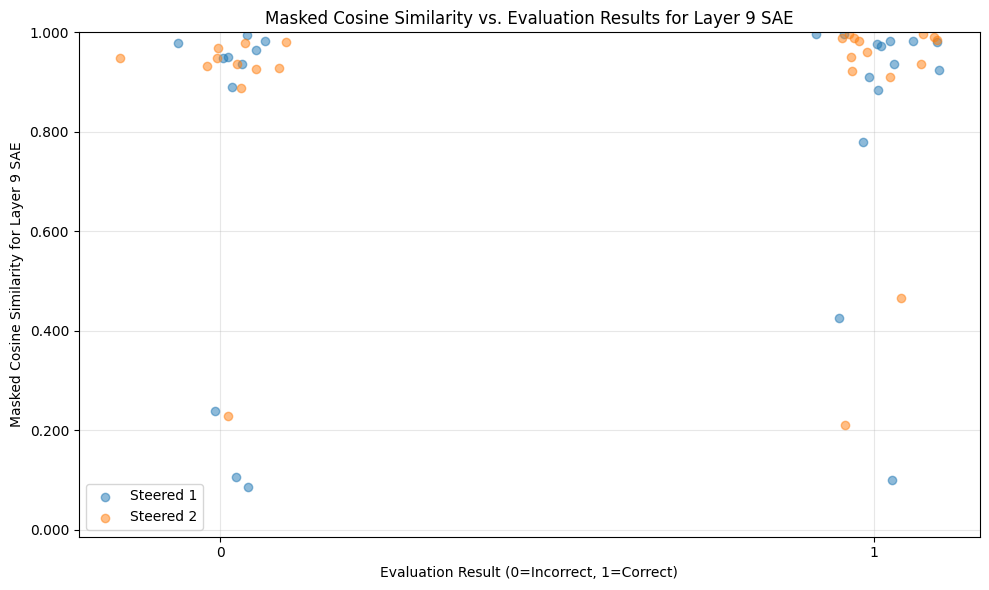


Statistics for Layer 9 SAE - Steered 1:
Average similarity for correct answers: 0.846
Average similarity for incorrect answers: 0.735
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average similarity for correct answers: 0.878
Average similarity for incorrect answers: 0.879
Number of correct answers: 14
Number of incorrect answers: 11


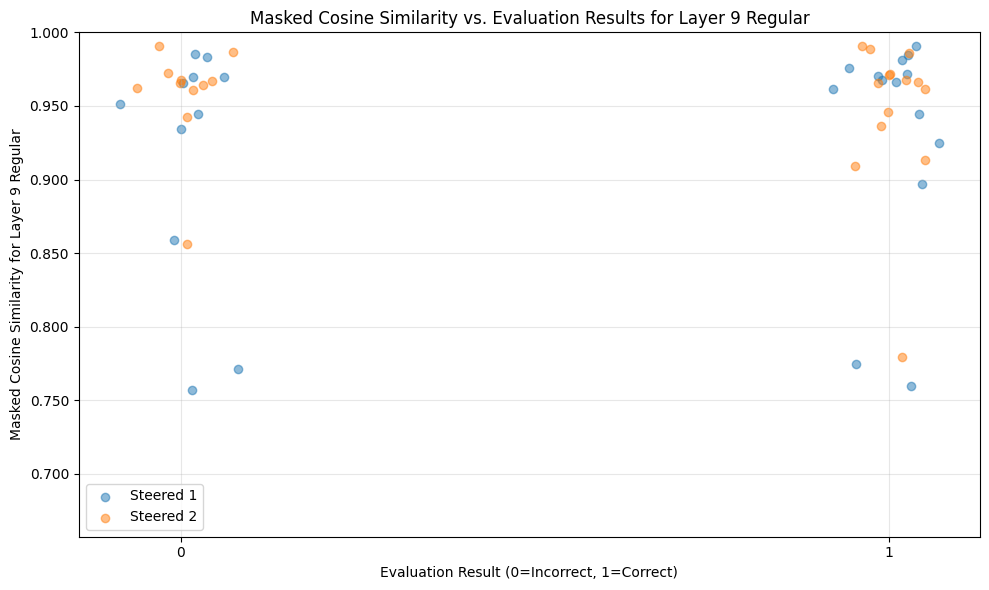


Statistics for Layer 9 Regular - Steered 1:
Average similarity for correct answers: 0.934
Average similarity for incorrect answers: 0.917
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average similarity for correct answers: 0.947
Average similarity for incorrect answers: 0.958
Number of correct answers: 14
Number of incorrect answers: 11


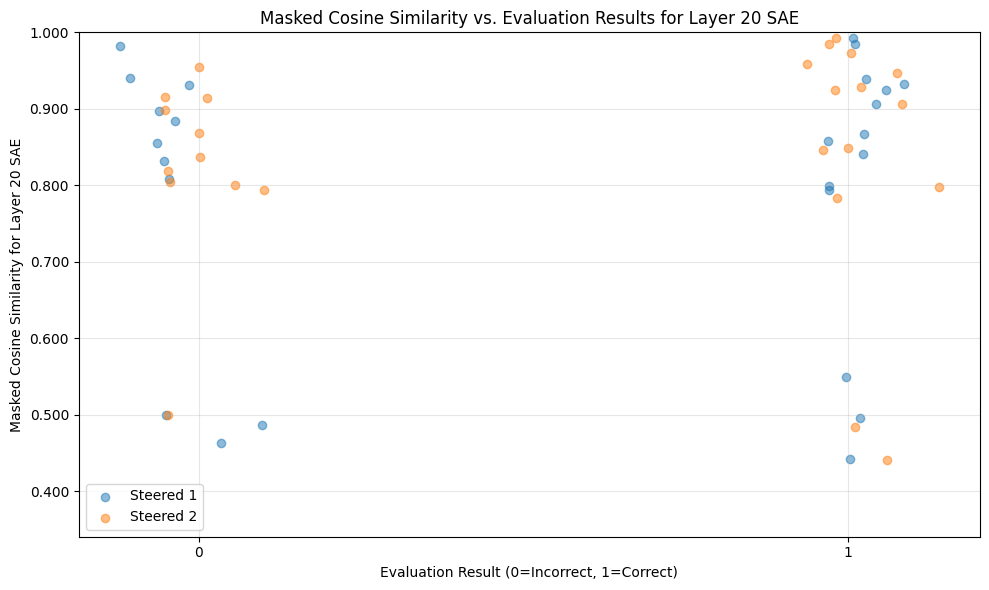


Statistics for Layer 20 SAE - Steered 1:
Average similarity for correct answers: 0.809
Average similarity for incorrect answers: 0.780
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average similarity for correct answers: 0.844
Average similarity for incorrect answers: 0.828
Number of correct answers: 14
Number of incorrect answers: 11


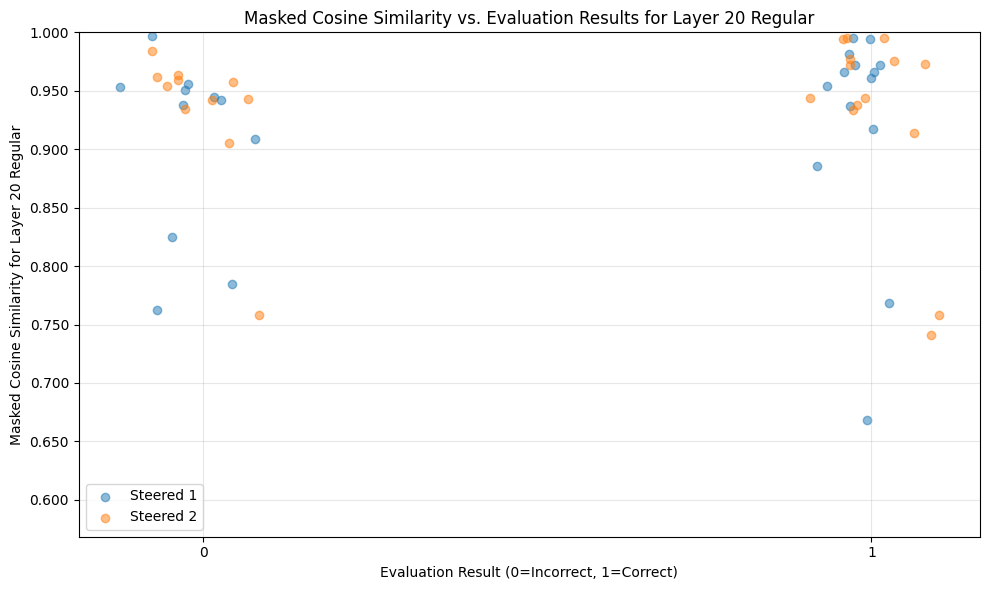


Statistics for Layer 20 Regular - Steered 1:
Average similarity for correct answers: 0.924
Average similarity for incorrect answers: 0.906
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average similarity for correct answers: 0.933
Average similarity for incorrect answers: 0.933
Number of correct answers: 14
Number of incorrect answers: 11


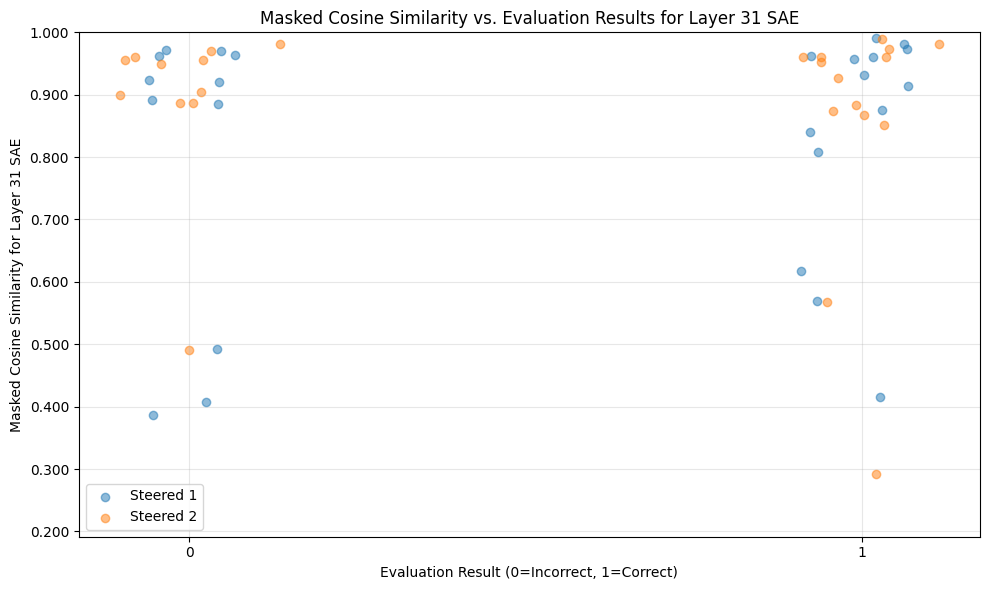


Statistics for Layer 31 SAE - Steered 1:
Average similarity for correct answers: 0.843
Average similarity for incorrect answers: 0.798
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average similarity for correct answers: 0.860
Average similarity for incorrect answers: 0.895
Number of correct answers: 14
Number of incorrect answers: 11


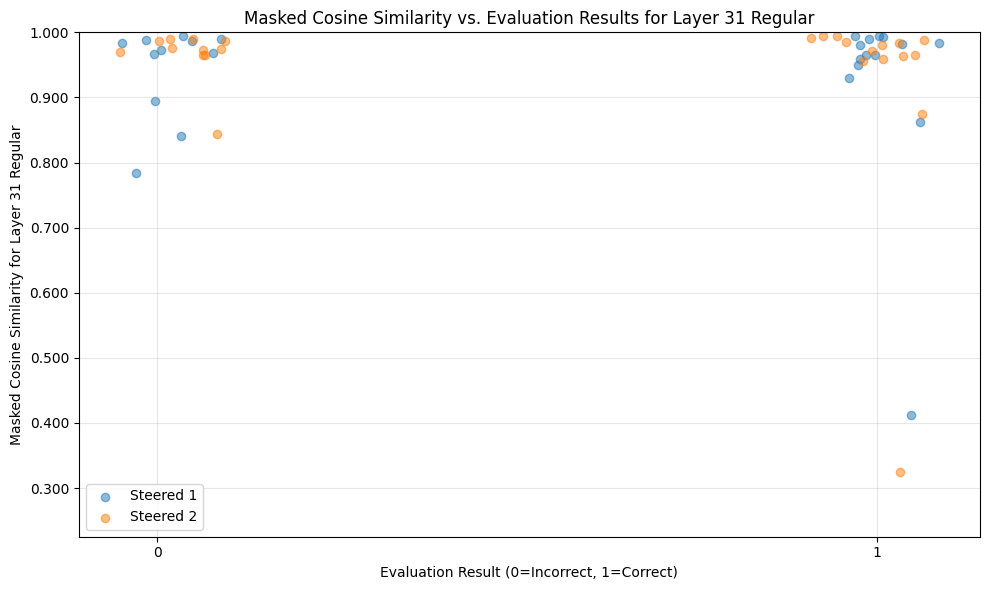


Statistics for Layer 31 Regular - Steered 1:
Average similarity for correct answers: 0.926
Average similarity for incorrect answers: 0.943
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average similarity for correct answers: 0.924
Average similarity for incorrect answers: 0.966
Number of correct answers: 14
Number of incorrect answers: 11


In [61]:
calculate_cosine_similarity_masked(correct_df, use_normalized=False)

### Distribution of Cosine Similarity in Dataset

##### Function Definitions
###### Calculate and Store Similarities (similarities_df)

In [59]:
def calculate_and_store_cosine_similarities(df):
    """
    Calculate cosine similarities between unsteered and steered answers and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
    
    Returns:
        pandas DataFrame containing all cosine similarities
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    # Initialize lists to store data
    data = []
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate similarities for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names
                unsteered_col = f'{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                steered1_col = f'{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                steered2_col = f'{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get vectors
                    unsteered_vec = df[unsteered_col].iloc[prompt_id]
                    steered1_vec = df[steered1_col].iloc[prompt_id]
                    steered2_vec = df[steered2_col].iloc[prompt_id]
                    
                    # Calculate cosine similarities
                    steered1_sim = calculate_cosine_similarity(unsteered_vec, steered1_vec)
                    steered2_sim = calculate_cosine_similarity(unsteered_vec, steered2_vec)
                    
                    # Store similarities in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_sim'] = steered1_sim
                    row_data[f'{col_prefix}_layer{layer}_steered2_sim'] = steered2_sim
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_sim'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_sim'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    similarities_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        similarities_df['source_folder'] = df['source_folder']
    
    return similarities_df

###### Plot: analyze_cosine_similarities

In [67]:
def analyze_cosine_similaritiesv2(similarities_df):
    """
    Analyze and visualize the distribution of cosine similarities between unsteered and steered answers,
    combining both steered1 and steered2 into a single distribution.
    """
    # Create subplots for each layer
    layers = [9, 20, 31]
    types = ['SAE', 'Regular']
    
    fig, axes = plt.subplots(len(layers), len(types), figsize=(15, 4*len(layers)))
    fig.suptitle('Distribution of Cosine Similarities by Layer and Evaluation Result', fontsize=16, y=1.02)
    
    # Initialize list for statistics
    stats_data = []
    
    for i, layer in enumerate(layers):
        for j, type_name in enumerate(types):
            # Get columns for this layer and type
            prefix = type_name
            steered1_col = f'{prefix}_layer{layer}_steered1_sim'
            steered2_col = f'{prefix}_layer{layer}_steered2_sim'
            
            # Combine data from both steered versions
            all_similarities = []
            all_correctness = []
            
            # Process steered1 data
            if steered1_col in similarities_df.columns:
                correctness1 = similarities_df['evaluation'].apply(lambda x: int(x[1]))
                similarities1 = similarities_df[steered1_col]
                all_similarities.extend(similarities1)
                all_correctness.extend(correctness1)
            
            # Process steered2 data
            if steered2_col in similarities_df.columns:
                correctness2 = similarities_df['evaluation'].apply(lambda x: int(x[2]))
                similarities2 = similarities_df[steered2_col]
                all_similarities.extend(similarities2)
                all_correctness.extend(correctness2)
            
            # Convert to numpy arrays for easier processing
            all_similarities = np.array(all_similarities)
            all_correctness = np.array(all_correctness)
            
            # Separate correct and incorrect
            correct_values = all_similarities[all_correctness == 1]
            incorrect_values = all_similarities[all_correctness == 0]
            
            # Initialize flag for plotting
            has_plots = False
            
            # Plot distributions
            if len(correct_values) > 0:
                sns.histplot(data=correct_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='green', 
                           label=f'Correct (n={len(correct_values)})')
                mean_correct = correct_values.mean()
                axes[i,j].axvline(mean_correct, color='green', linestyle='--',
                                label=f'Mean Correct: {mean_correct:.4f}')
                has_plots = True
            
            if len(incorrect_values) > 0:
                sns.histplot(data=incorrect_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='red',
                           label=f'Incorrect (n={len(incorrect_values)})')
                mean_incorrect = incorrect_values.mean()
                axes[i,j].axvline(mean_incorrect, color='red', linestyle='--',
                                label=f'Mean Incorrect: {mean_incorrect:.4f}')
                has_plots = True
            
            axes[i,j].set_title(f'{type_name} Layer {layer}')
            axes[i,j].set_xlabel('Cosine Similarity')
            axes[i,j].set_ylabel('Count')
            
            # Only add legend if we actually plotted something
            if has_plots:
                axes[i,j].legend()
            
            # Store statistics
            if len(correct_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Correct',
                    'Mean': correct_values.mean(),
                    'Std': correct_values.std(),
                    'Count': len(correct_values)
                })
            
            if len(incorrect_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Incorrect',
                    'Mean': incorrect_values.mean(),
                    'Std': incorrect_values.std(),
                    'Count': len(incorrect_values)
                })
    
    plt.tight_layout()
    plt.show()
    
    # Create and return statistics DataFrame
    return pd.DataFrame(stats_data)

##### Output - All Activations

In [74]:
similarities_df = calculate_and_store_cosine_similarities(correct_df)
print(similarities_df.head())

   prompt_id evaluation  SAE_layer9_steered1_sim  SAE_layer9_steered2_sim  \
0          0  [1, 1, 1]                 0.060018                 0.100508   
1          1  [1, 1, 1]                 0.871613                 0.871613   
2          2  [1, 1, 1]                 0.878949                 0.878949   
3          3  [1, 1, 1]                 0.817516                 0.817516   
4          4  [1, 0, 1]                 0.776164                 0.764291   

   Regular_layer9_steered1_sim  Regular_layer9_steered2_sim  \
0                     0.420904                     0.479341   
1                     0.949937                     0.949937   
2                     0.953219                     0.953219   
3                     0.878028                     0.878028   
4                     0.927708                     0.903126   

   SAE_layer20_steered1_sim  SAE_layer20_steered2_sim  \
0                  0.157509                  0.185381   
1                  0.911331                 

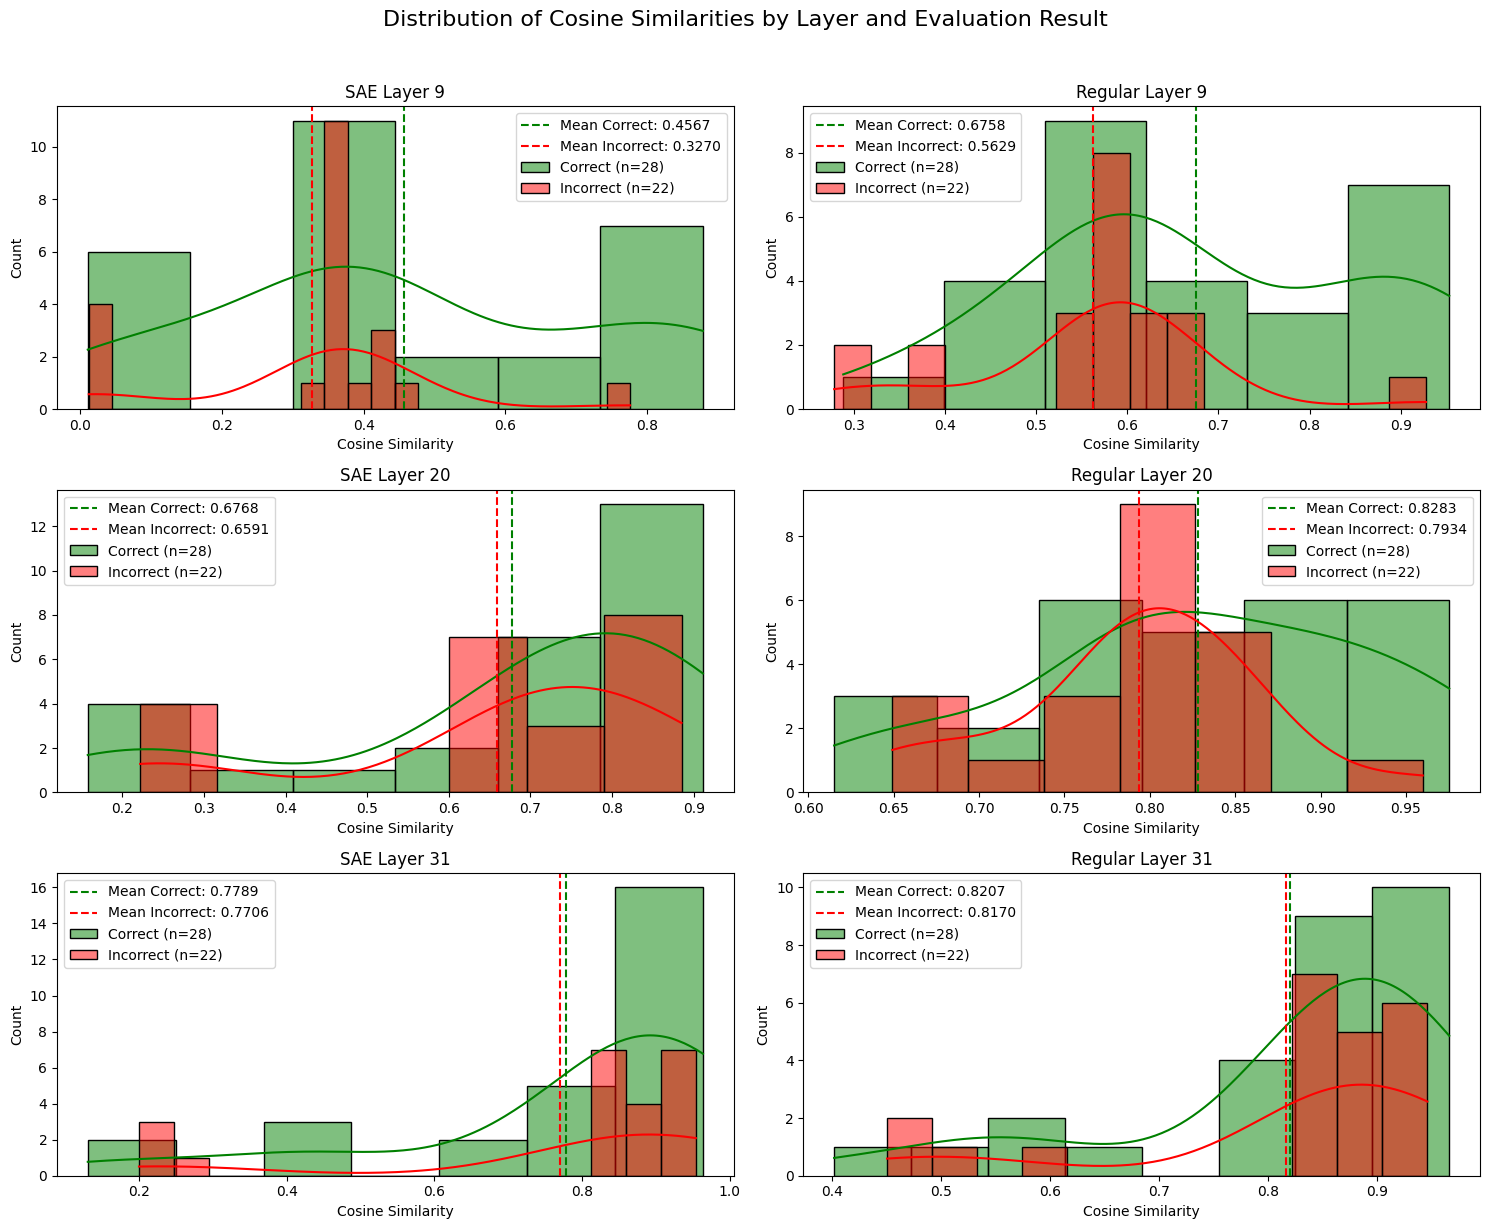

In [102]:
stats_cos_df = analyze_cosine_similaritiesv2(similarities_df)

# To further analyze specific combinations
#stats_cos_df = stats_df[stats_df['Type'] == 'SAE']
#print("\nSAE Statistics:")
#print(stats_cos_df.to_string(index=False))

##### Output: Distributions of top activations

In [103]:
def calculate_and_store_cosine_similarities_masked(df, use_normalized=False, use_individual_tops=False):
    """
    Calculate cosine similarities between unsteered and steered answers for top activations and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized similarities
        use_individual_tops: Boolean to toggle between using masked (False) or individual (True) top activations
    
    Returns:
        pandas DataFrame containing all cosine similarities for top activations
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    vector_length = 131072  # Full vector length for masked calculation
    
    # Initialize lists to store data
    data = []
    
    def calculate_masked_similarity(vec1_data, vec2_data):
        """Calculate cosine similarity using masked approach"""
        # Initialize vectors with zeros
        vec1 = np.zeros(vector_length)
        vec2 = np.zeros(vector_length)
        
        # Fill in the extracted activations
        for idx, val in vec1_data:
            vec1[idx] = val
        for idx, val in vec2_data:
            vec2[idx] = val
            
        if use_normalized:
            # Normalize vectors to [-1, 1]
            vec1_range = vec1.max() - vec1.min()
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            
            vec2_range = vec2.max() - vec2.min()
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate cosine similarity
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        
        if norm1 == 0 or norm2 == 0:
            return 0
        return dot_product / (norm1 * norm2)
    
    def calculate_individual_similarity(vec1_data, vec2_data):
        """Calculate cosine similarity using individual top activations"""
        # Create dictionaries for easy lookup
        dict1 = dict(vec1_data)
        dict2 = dict(vec2_data)
        
        # Get all unique indices
        all_indices = set(dict1.keys()) | set(dict2.keys())
        
        # Create vectors only for the relevant indices
        vec1 = np.array([dict1.get(idx, 0.0) for idx in all_indices])
        vec2 = np.array([dict2.get(idx, 0.0) for idx in all_indices])
        
        if use_normalized and len(vec1) > 0:
            # Normalize vectors to [-1, 1]
            vec1_range = vec1.max() - vec1.min()
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            
            vec2_range = vec2.max() - vec2.min()
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate cosine similarity
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        
        if norm1 == 0 or norm2 == 0:
            return 0
        return dot_product / (norm1 * norm2)
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate similarities for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names for top activations
                if use_individual_tops:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Top_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Top_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                else:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get activation data
                    unsteered_data = df[unsteered_col].iloc[prompt_id]
                    steered1_data = df[steered1_col].iloc[prompt_id]
                    steered2_data = df[steered2_col].iloc[prompt_id]
                    
                    if any(data is None for data in [unsteered_data, steered1_data, steered2_data]):
                        continue
                    
                    # Calculate similarities using selected method
                    if use_individual_tops:
                        steered1_sim = calculate_individual_similarity(unsteered_data, steered1_data)
                        steered2_sim = calculate_individual_similarity(unsteered_data, steered2_data)
                    else:
                        steered1_sim = calculate_masked_similarity(unsteered_data, steered1_data)
                        steered2_sim = calculate_masked_similarity(unsteered_data, steered2_data)
                    
                    # Store similarities in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_sim'] = steered1_sim
                    row_data[f'{col_prefix}_layer{layer}_steered2_sim'] = steered2_sim
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_sim'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_sim'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    similarities_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        similarities_df['source_folder'] = df['source_folder']
    
    return similarities_df

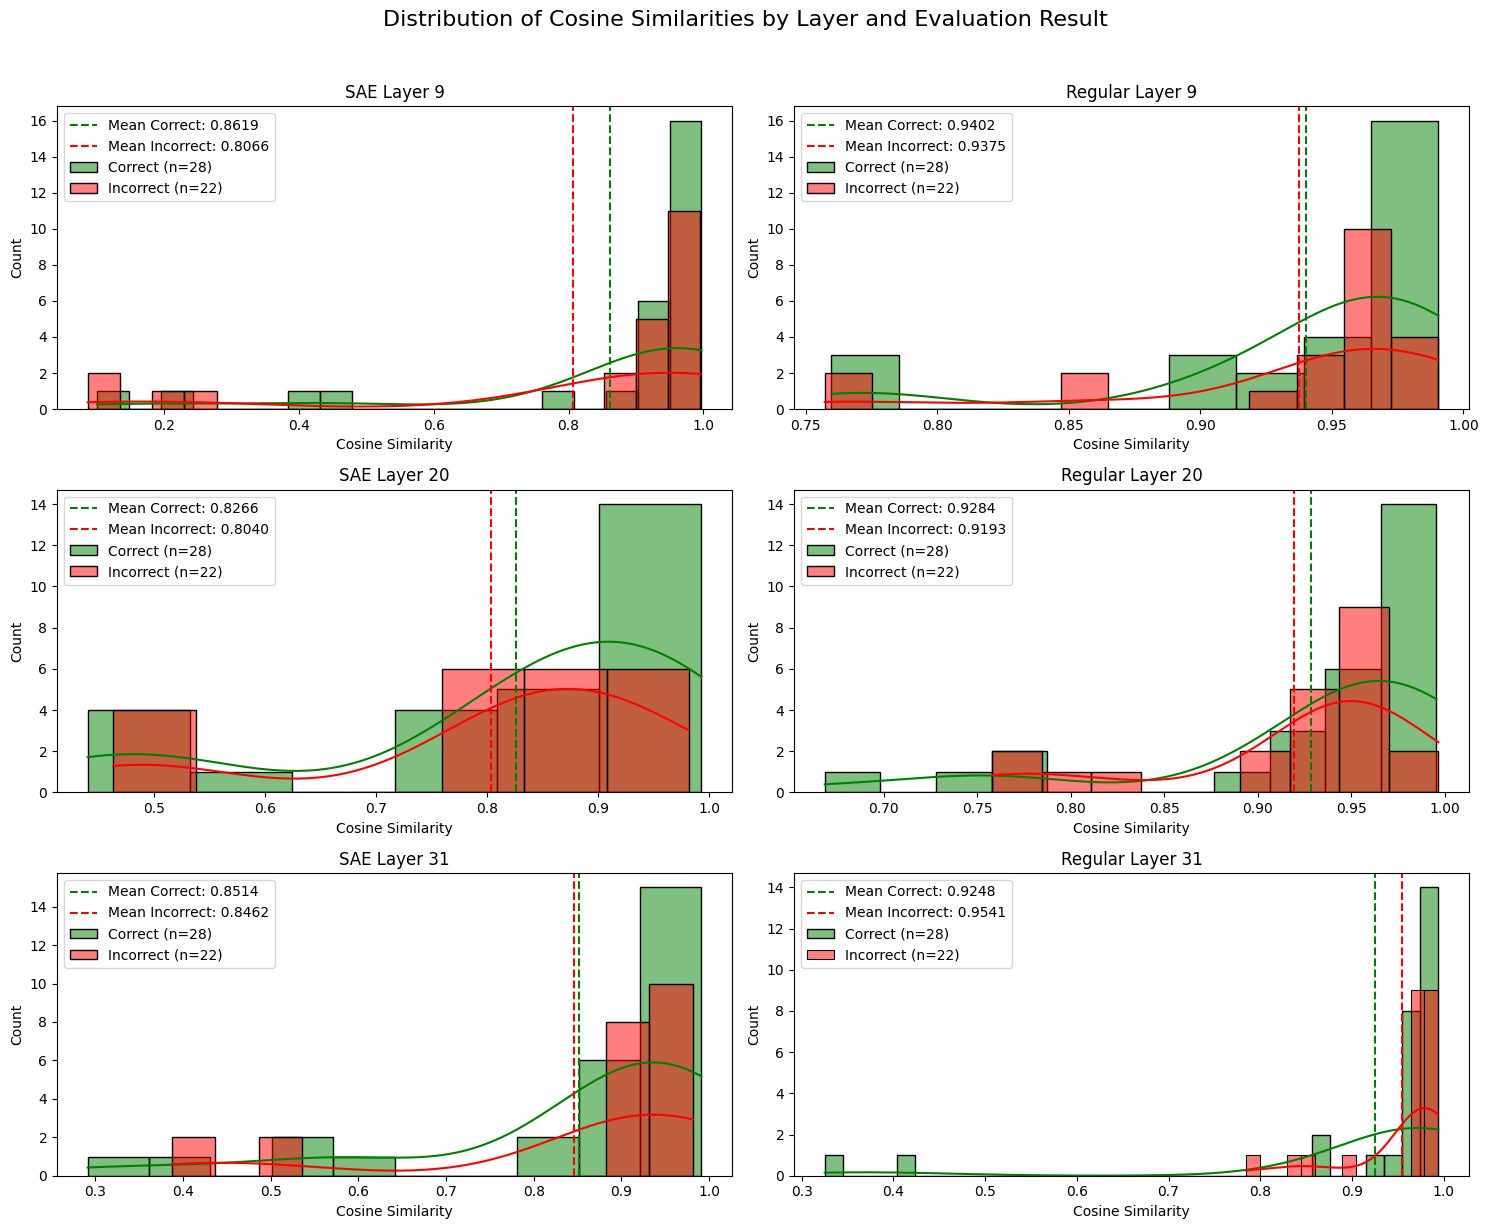

In [104]:
# Calculate similarities for masked data
similarities_df_masked = calculate_and_store_cosine_similarities_masked(correct_df, use_normalized=False, use_individual_tops=False)

# Analyze and visualize the results
stats_cos_masked_df = analyze_cosine_similaritiesv2(similarities_df_masked)

In [ ]:
# Calculate similarities for masked data
similarities_df_tops = calculate_and_store_cosine_similarities_masked(correct_df, use_normalized=False, use_individual_tops=True)

# Analyze and visualize the results
stats_cos_tops_df = analyze_cosine_similaritiesv2(similarities_df_tops)

## Dot Product 

In [39]:
def calculate_dot_product(vec1, vec2, bNormalize=False):
    """
    Calculate dot product between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating
    
    Returns:
        float: Dot product between the vectors
    """
    # Convert to numpy arrays and flatten
    vec1 = np.array(vec1).flatten()
    vec2 = np.array(vec2).flatten()
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    # Calculate dot product
    return np.dot(vec1, vec2)


In [40]:
use_normalized = True  # USE THE NORMALIZED OR NORMAL DOT PRODUCT

In [41]:
def calculate_all_dot_products_and_plot(df, use_normalized=False):
    """
    Calculate dot products for all prompts and create visualization.
    Shows relationship between dot products and correctness for each steered answer.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized dot products
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize dictionaries to store results for each layer and activation type
    results = {}
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            results[key] = {
                'x_values': [],  # Will store evaluation results (0 or 1)
                'y_values': [],  # Will store dot products
                'steered_version': []  # Will store which steered version (1 or 2)
            }
    
    # Process each prompt
    for prompt_id in range(len(df)):
        # Get evaluation results for steered answers and convert to integers
        steered_evals = [int(x) for x in get_steered_evaluations(df['evaluation'].iloc[prompt_id])]
        
        # Calculate dot products for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Get column names
                unsteered_col = f"{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass"
                steered1_col = f"{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass"
                steered2_col = f"{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass"
                
                # Get vectors
                unsteered_vec = df[unsteered_col].iloc[prompt_id]
                steered1_vec = df[steered1_col].iloc[prompt_id]
                steered2_vec = df[steered2_col].iloc[prompt_id]
                
                # Calculate dot products
                dot1 = calculate_dot_product(unsteered_vec, steered1_vec, use_normalized)
                dot2 = calculate_dot_product(unsteered_vec, steered2_vec, use_normalized)
                
                key = f"{act_type}layer{layer}"
                
                # Store results
                results[key]['x_values'].extend([steered_evals[0], steered_evals[1]])
                results[key]['y_values'].extend([dot1, dot2])
                results[key]['steered_version'].extend([1, 2])
    
    # Create plots for each layer and activation type
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            
            # Create scatter plot
            plt.figure(figsize=(10, 6))
            
            # Get values for plotting and ensure they're numeric
            x_values = np.array(results[key]['x_values'], dtype=float)
            y_values = np.array(results[key]['y_values'], dtype=float)
            steered_versions = np.array(results[key]['steered_version'], dtype=int)
            
            # Add jitter to x-axis
            x_jitter = np.random.normal(0, 0.05, len(x_values))
            
            # Plot points with different colors for steered versions
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                plt.scatter(x_values[mask] + x_jitter[mask], 
                          y_values[mask], 
                          alpha=0.5,
                          label=f'Steered {steered_num}')
            
            # Set labels and title
            activation_name = "SAE" if act_type == 'SAE_' else "Regular"
            plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
            plt.ylabel(f'Dot Product for Layer {layer} {activation_name}' + 
                      (' (Normalized)' if use_normalized else ''))
            plt.title(f'Dot Product vs. Evaluation Results for Layer {layer} {activation_name}' +
                      (' (Normalized)' if use_normalized else ''))
            
            # Set x-axis ticks and add grid
            plt.xticks([0, 1])
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            plt.show()
            
            # Print statistics for each steered version
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_dots = [d for i, d in enumerate(steered_y_values) 
                              if steered_x_values[i] == 1]
                incorrect_dots = [d for i, d in enumerate(steered_y_values) 
                                if steered_x_values[i] == 0]
                
                print(f"\nStatistics for Layer {layer} {activation_name} - Steered {steered_num}:")
                if correct_dots:
                    print(f"Average dot product for correct answers: {np.mean(correct_dots):.4f}")
                if incorrect_dots:
                    print(f"Average dot product for incorrect answers: {np.mean(incorrect_dots):.4f}")
                print(f"Number of correct answers: {len(correct_dots)}")
                print(f"Number of incorrect answers: {len(incorrect_dots)}")

#### Normalized dot product plot

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


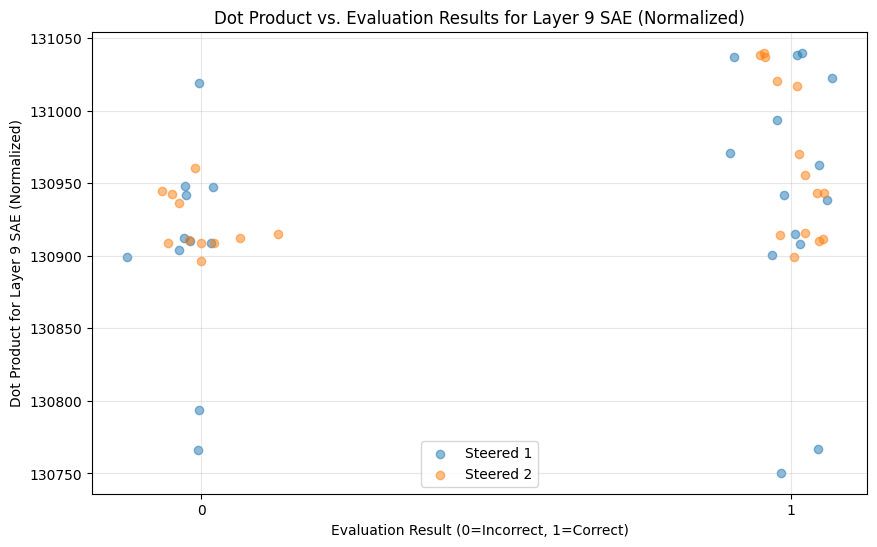


Statistics for Layer 9 SAE - Steered 1:
Average dot product for correct answers: 130941.9551
Average dot product for incorrect answers: 130904.5761
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average dot product for correct answers: 130965.4304
Average dot product for incorrect answers: 130922.3491
Number of correct answers: 14
Number of incorrect answers: 11


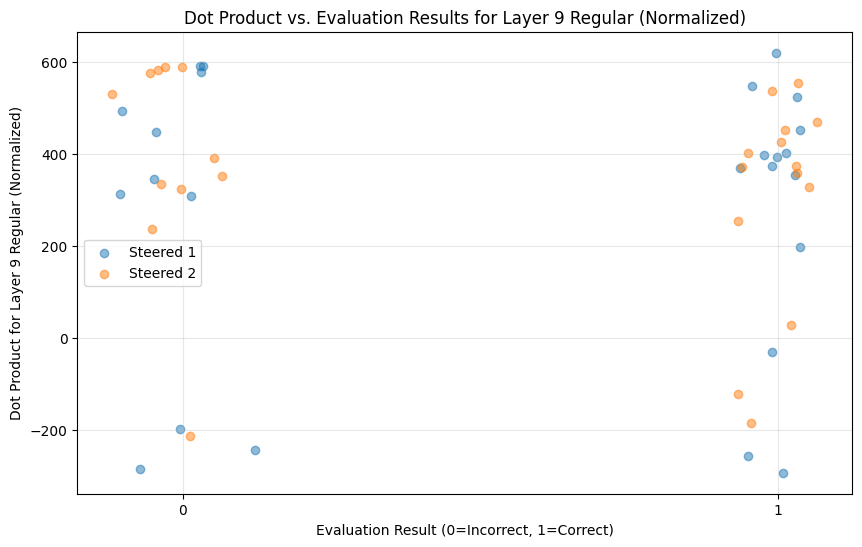


Statistics for Layer 9 Regular - Steered 1:
Average dot product for correct answers: 289.7411
Average dot product for incorrect answers: 267.9476
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average dot product for correct answers: 303.7804
Average dot product for incorrect answers: 390.3942
Number of correct answers: 14
Number of incorrect answers: 11


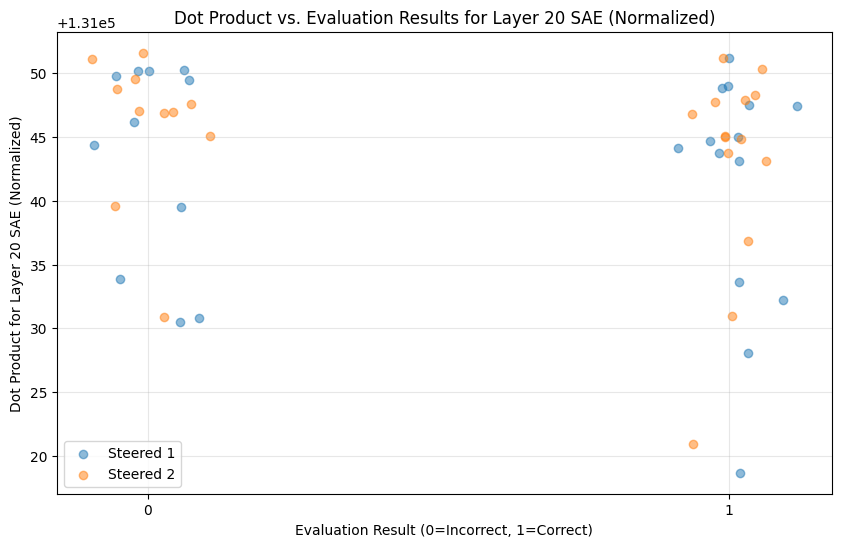


Statistics for Layer 20 SAE - Steered 1:
Average dot product for correct answers: 131041.2411
Average dot product for incorrect answers: 131043.1848
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average dot product for correct answers: 131043.0726
Average dot product for incorrect answers: 131045.9118
Number of correct answers: 14
Number of incorrect answers: 11


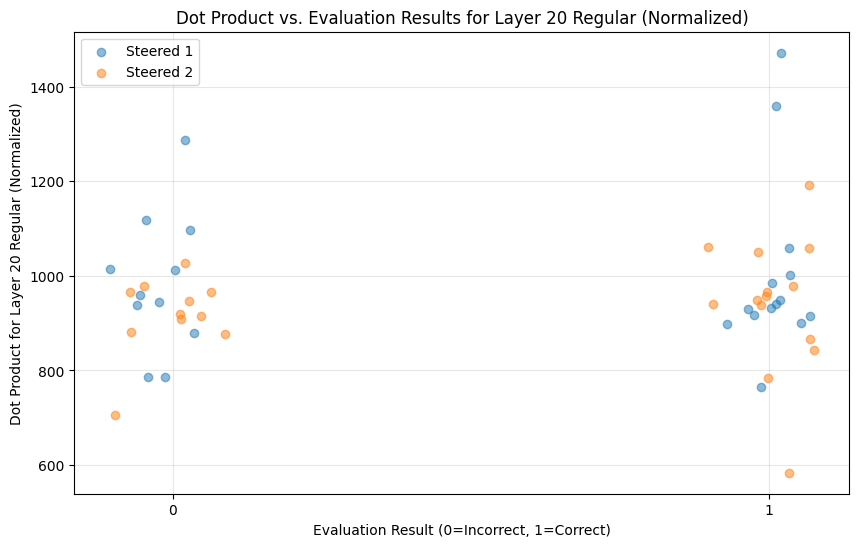


Statistics for Layer 20 Regular - Steered 1:
Average dot product for correct answers: 1001.5257
Average dot product for incorrect answers: 983.9418
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average dot product for correct answers: 940.6129
Average dot product for incorrect answers: 917.5063
Number of correct answers: 14
Number of incorrect answers: 11


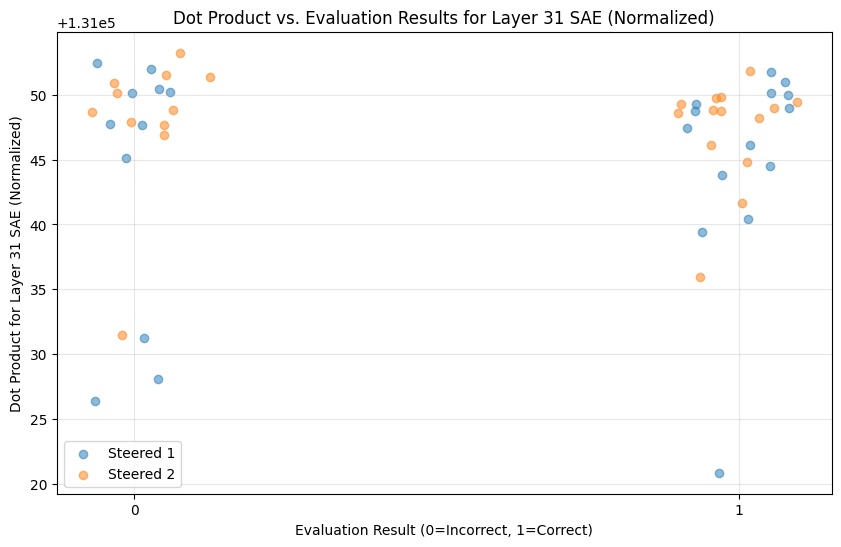


Statistics for Layer 31 SAE - Steered 1:
Average dot product for correct answers: 131045.1743
Average dot product for incorrect answers: 131043.7635
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average dot product for correct answers: 131047.2852
Average dot product for incorrect answers: 131048.0539
Number of correct answers: 14
Number of incorrect answers: 11


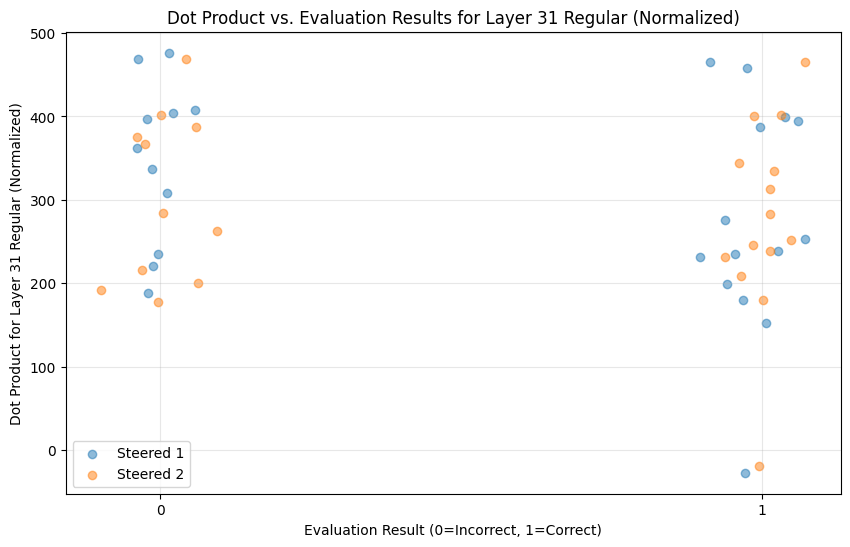


Statistics for Layer 31 Regular - Steered 1:
Average dot product for correct answers: 274.6290
Average dot product for incorrect answers: 345.8069
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average dot product for correct answers: 277.3001
Average dot product for incorrect answers: 303.0066
Number of correct answers: 14
Number of incorrect answers: 11


In [42]:
# For normalized dot products:
calculate_all_dot_products_and_plot(correct_df, use_normalized=True)


#### Non-Normalized dot product plot

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


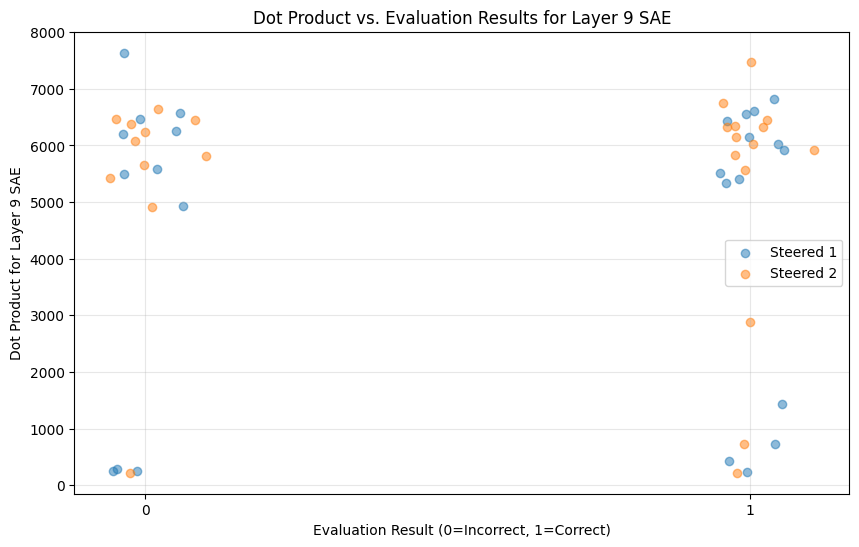


Statistics for Layer 9 SAE - Steered 1:
Average dot product for correct answers: 4541.3277
Average dot product for incorrect answers: 4540.7709
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average dot product for correct answers: 5214.2861
Average dot product for incorrect answers: 5482.8698
Number of correct answers: 14
Number of incorrect answers: 11


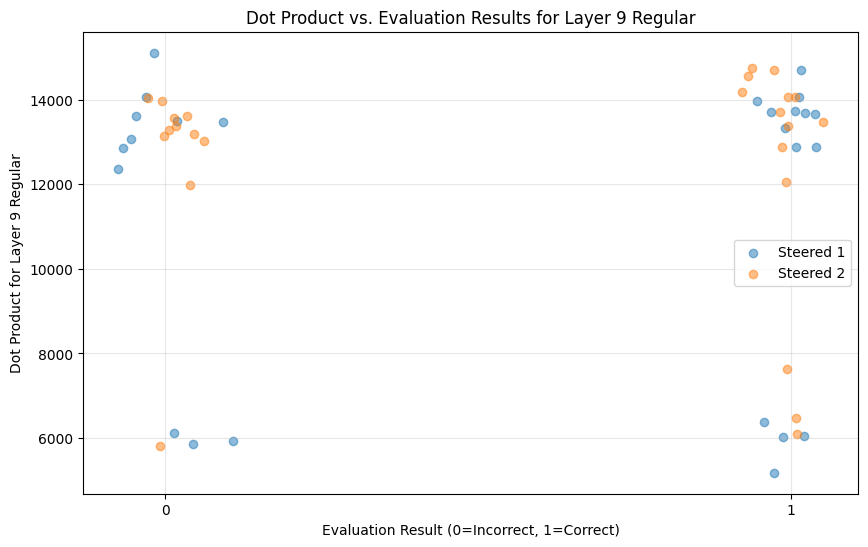


Statistics for Layer 9 Regular - Steered 1:
Average dot product for correct answers: 11448.5360
Average dot product for incorrect answers: 11455.0348
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average dot product for correct answers: 12291.5906
Average dot product for incorrect answers: 12634.2716
Number of correct answers: 14
Number of incorrect answers: 11


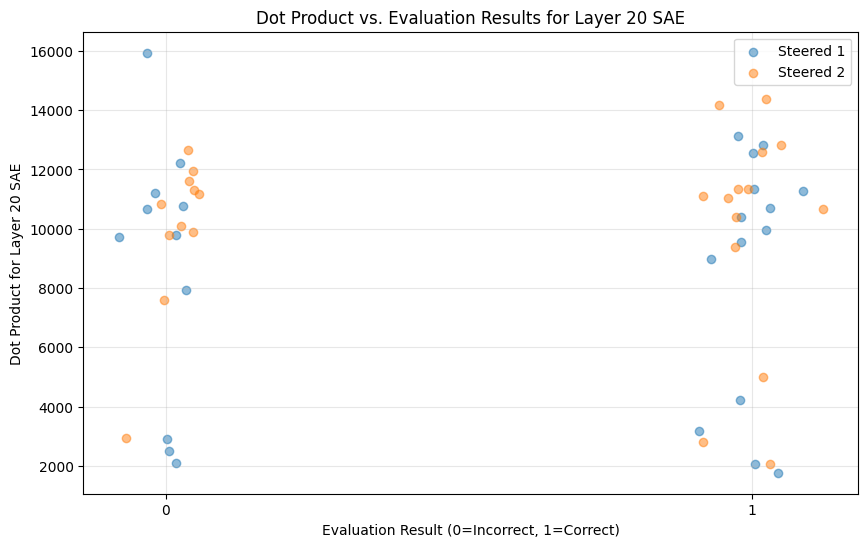


Statistics for Layer 20 SAE - Steered 1:
Average dot product for correct answers: 8714.0791
Average dot product for incorrect answers: 8703.3512
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average dot product for correct answers: 9939.8384
Average dot product for incorrect answers: 9987.9173
Number of correct answers: 14
Number of incorrect answers: 11


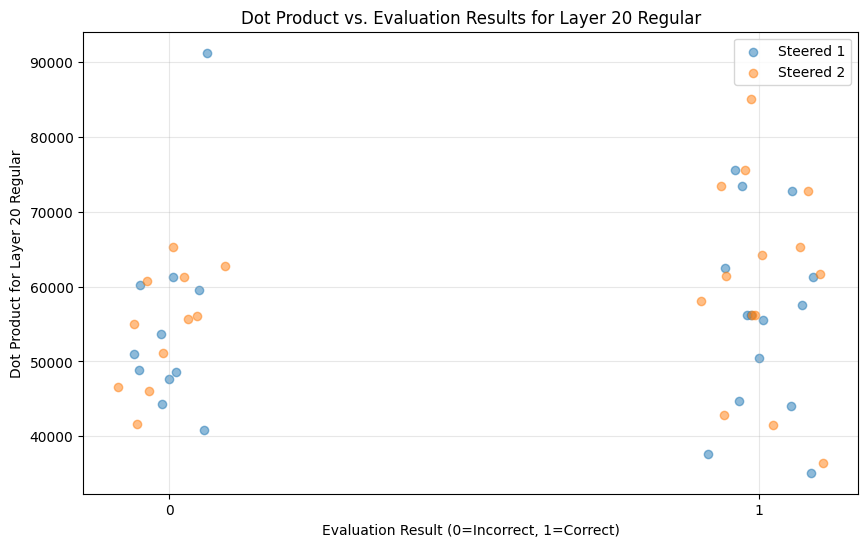


Statistics for Layer 20 Regular - Steered 1:
Average dot product for correct answers: 55939.8245
Average dot product for incorrect answers: 55199.0592
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average dot product for correct answers: 60783.5546
Average dot product for incorrect answers: 54749.7351
Number of correct answers: 14
Number of incorrect answers: 11


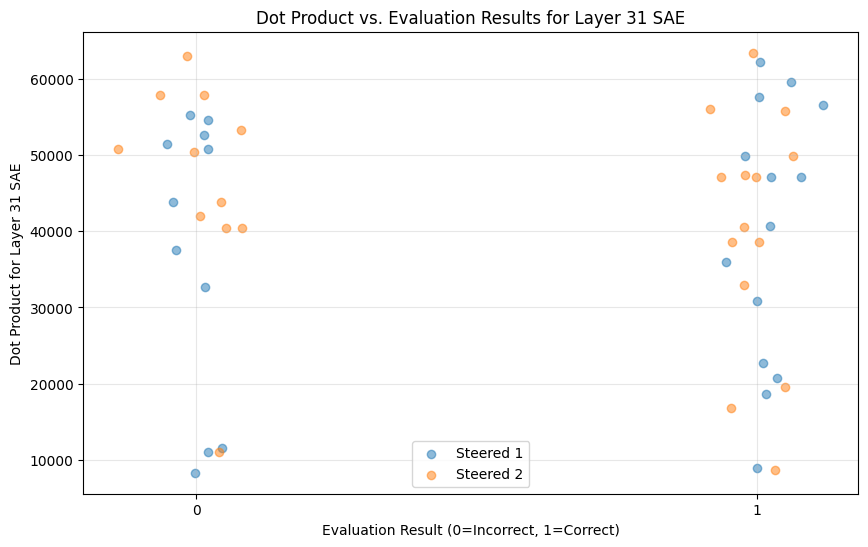


Statistics for Layer 31 SAE - Steered 1:
Average dot product for correct answers: 39890.8465
Average dot product for incorrect answers: 37225.6976
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average dot product for correct answers: 40154.3867
Average dot product for incorrect answers: 46441.0713
Number of correct answers: 14
Number of incorrect answers: 11


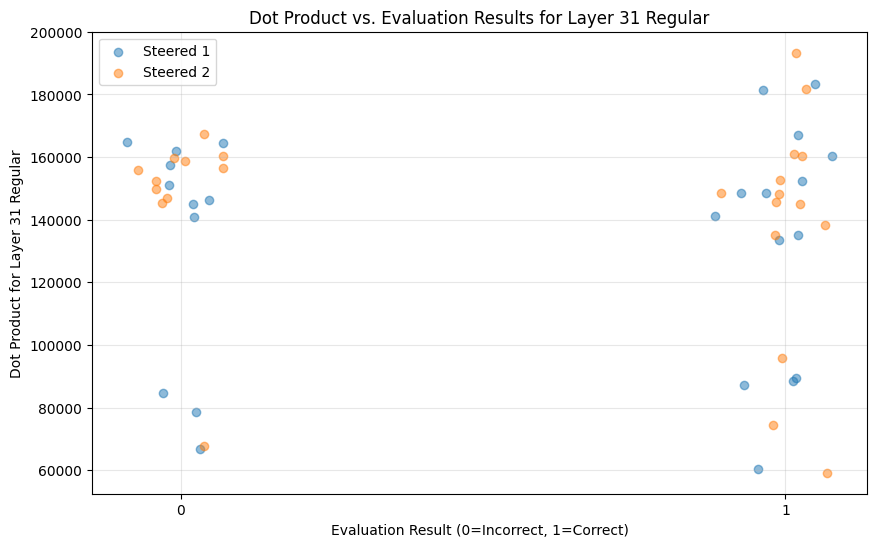


Statistics for Layer 31 Regular - Steered 1:
Average dot product for correct answers: 134080.9984
Average dot product for incorrect answers: 132893.6807
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average dot product for correct answers: 138478.7718
Average dot product for incorrect answers: 147340.4640
Number of correct answers: 14
Number of incorrect answers: 11


In [43]:

# For non-normalized dot products:
calculate_all_dot_products_and_plot(correct_df, use_normalized=False)

#### Results for 0to60 USMLE pirate V1:

Not really any clustering. Dot product is arguably a bit higher for incorrect answers?


When adding another 25 results (14 correct, 11 incorrect)--> again, seems a bit more on the incorrect side.


### Dot Product: Using only top actvns


In [44]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

def calculate_dot_product_masked(df, use_normalized=False):
    """
    Calculate dot products using only the extracted steered activations.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized dot products
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")
    
    # Initialize results dictionary
    results = {f"{act_type}layer{layer}": {'x_values': [], 'y_values': [], 'steered_version': []} 
              for layer in layers for act_type in activation_types}
    
    def calculate_dot_product(vec1_data, vec2_data):
        """Calculate dot product between two sets of (index, value) pairs"""
        # Convert to dictionaries for easy lookup
        dict1 = dict(vec1_data)
        dict2 = dict(vec2_data)
        
        # Get all unique indices
        all_indices = set(dict1.keys()) | set(dict2.keys())
        
        # Create vectors only for the relevant indices
        vec1 = np.array([dict1.get(idx, 0.0) for idx in all_indices])
        vec2 = np.array([dict2.get(idx, 0.0) for idx in all_indices])
        
        # Normalize if requested
        if use_normalized and len(vec1) > 0:
            vec1_range = vec1.max() - vec1.min()
            vec2_range = vec2.max() - vec2.min()
            
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate dot product
        return np.dot(vec1, vec2)
    
    # Process each prompt
    for prompt_id in range(len(df)):
        steered_evals = get_steered_evaluations(df['evaluation'].iloc[prompt_id])
        
        for layer in layers:
            for act_type in activation_types:
                try:
                    # Get column names
                    cols = [
                        f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass',
                        f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass',
                        f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                    ]
                    
                    # Get activation data
                    vectors = [df[col].iloc[prompt_id] for col in cols]
                    if any(v is None for v in vectors):
                        continue
                    
                    # Calculate dot products
                    dot1 = calculate_dot_product(vectors[0], vectors[1])
                    dot2 = calculate_dot_product(vectors[0], vectors[2])
                    
                    # Store results
                    key = f"{act_type}layer{layer}"
                    results[key]['x_values'].extend(steered_evals)
                    results[key]['y_values'].extend([dot1, dot2])
                    results[key]['steered_version'].extend([1, 2])
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    continue
    
    # Create plots
    for layer in layers:
        for act_type in activation_types:
            key = f"{act_type}layer{layer}"
            if not results[key]['x_values']:
                continue
                
            plt.figure(figsize=(10, 6))
            
            x_values = np.array(results[key]['x_values'])
            y_values = np.array(results[key]['y_values'])
            steered_versions = np.array(results[key]['steered_version'])
            
            # Add jitter and plot
            x_jitter = np.random.normal(0, 0.05, len(x_values))
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                plt.scatter(x_values[mask] + x_jitter[mask], 
                          y_values[mask], 
                          alpha=0.5,
                          label=f'Steered {steered_num}')
            
            # Set labels and title
            activation_name = "SAE" if act_type == 'SAE_' else "Regular"
            plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
            plt.ylabel(f'Masked Dot Product for Layer {layer} {activation_name}' + 
                      (' (Normalized)' if use_normalized else ''))
            plt.title(f'Masked Dot Product vs. Evaluation Results for Layer {layer} {activation_name}' +
                      (' (Normalized)' if use_normalized else ''))
            
            plt.xticks([0, 1])
            plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
            
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            for steered_num in [1, 2]:
                mask = steered_versions == steered_num
                steered_y_values = y_values[mask]
                steered_x_values = x_values[mask]
                
                correct_dots = steered_y_values[steered_x_values == 1]
                incorrect_dots = steered_y_values[steered_x_values == 0]
                
                print(f"\nStatistics for Layer {layer} {activation_name} - Steered {steered_num}:")
                if len(correct_dots):
                    print(f"Average dot product for correct answers: {np.mean(correct_dots):.4f}")
                if len(incorrect_dots):
                    print(f"Average dot product for incorrect answers: {np.mean(incorrect_dots):.4f}")
                print(f"Number of correct answers: {len(correct_dots)}")
                print(f"Number of incorrect answers: {len(incorrect_dots)}")

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


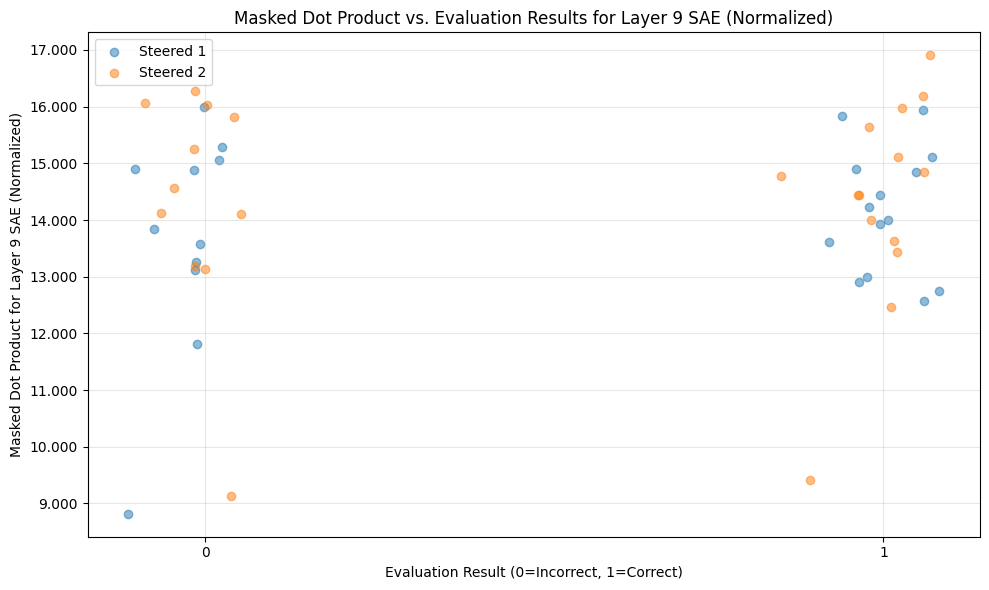


Statistics for Layer 9 SAE - Steered 1:
Average dot product for correct answers: 14.1465
Average dot product for incorrect answers: 13.6854
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average dot product for correct answers: 14.3783
Average dot product for incorrect answers: 14.3316
Number of correct answers: 14
Number of incorrect answers: 11


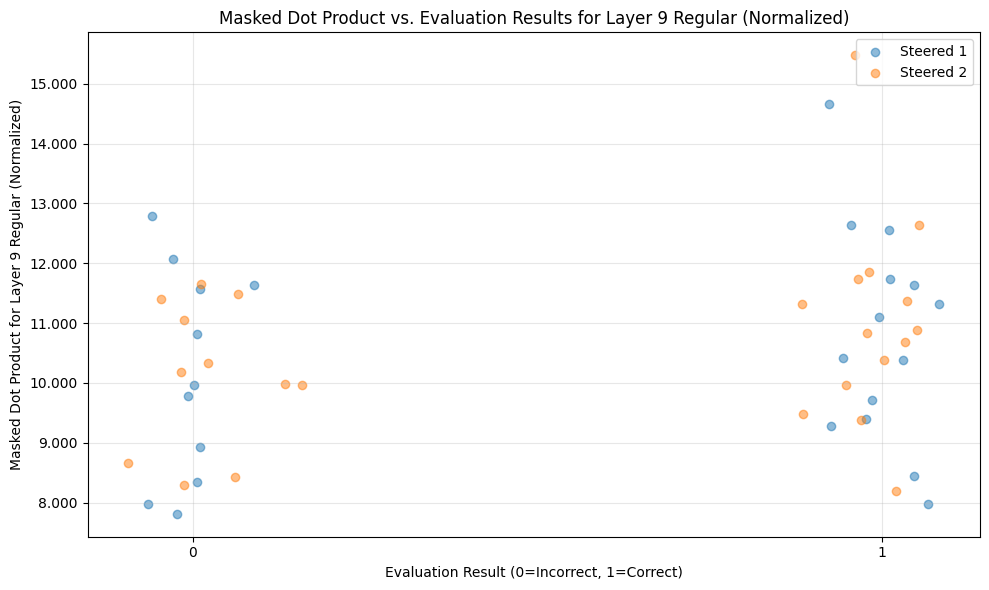


Statistics for Layer 9 Regular - Steered 1:
Average dot product for correct answers: 10.8053
Average dot product for incorrect answers: 10.1550
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average dot product for correct answers: 11.0142
Average dot product for incorrect answers: 10.1319
Number of correct answers: 14
Number of incorrect answers: 11


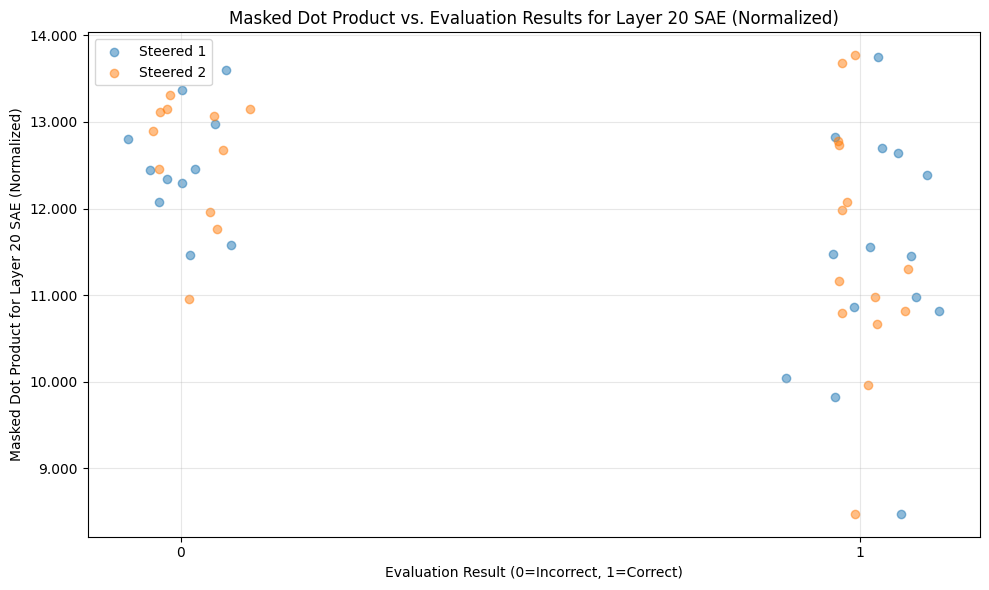


Statistics for Layer 20 SAE - Steered 1:
Average dot product for correct answers: 11.4125
Average dot product for incorrect answers: 12.4903
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average dot product for correct answers: 11.5127
Average dot product for incorrect answers: 12.5913
Number of correct answers: 14
Number of incorrect answers: 11


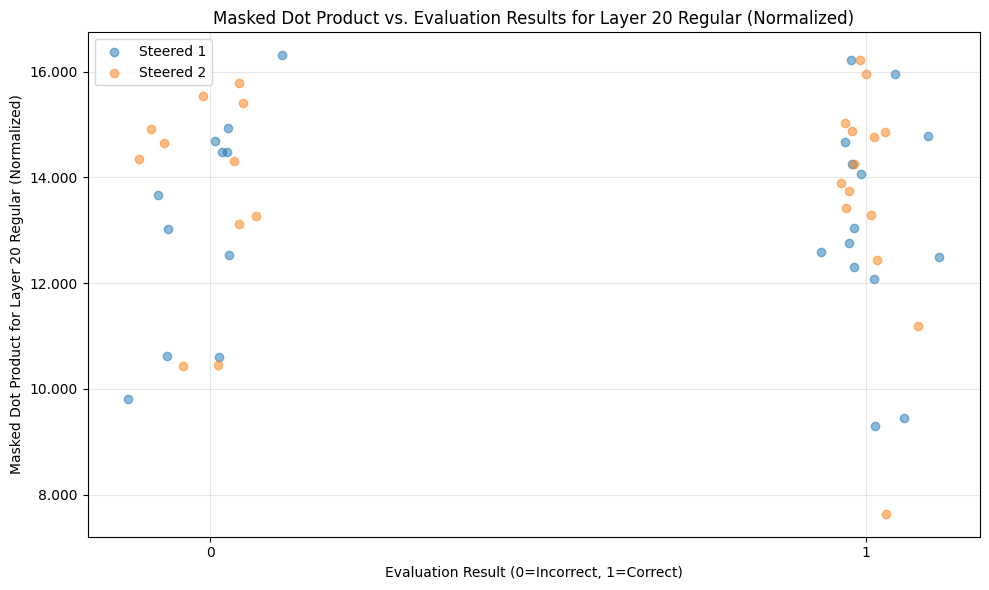


Statistics for Layer 20 Regular - Steered 1:
Average dot product for correct answers: 13.1399
Average dot product for incorrect answers: 13.1971
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average dot product for correct answers: 13.6828
Average dot product for incorrect answers: 13.8370
Number of correct answers: 14
Number of incorrect answers: 11


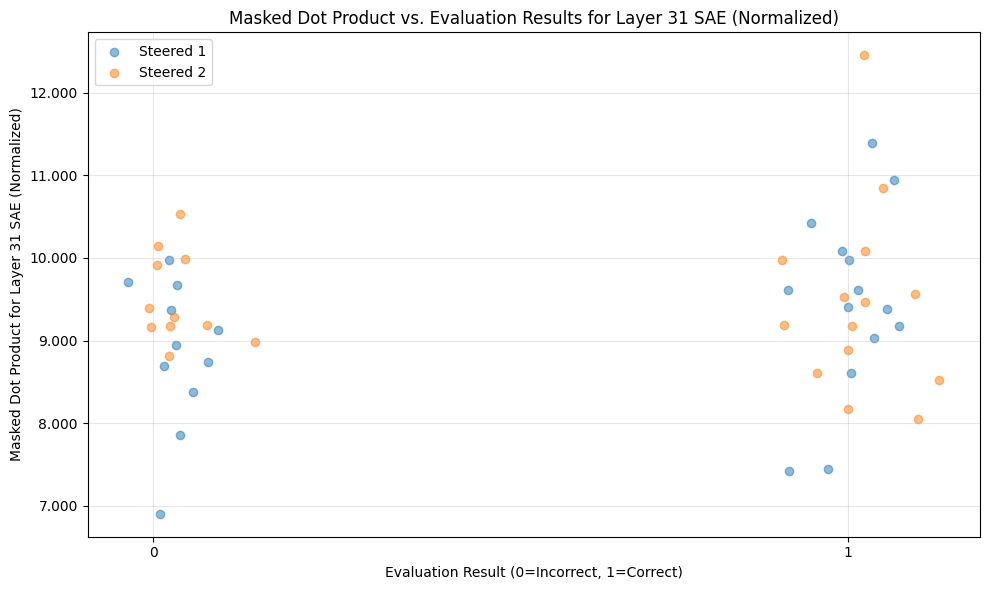


Statistics for Layer 31 SAE - Steered 1:
Average dot product for correct answers: 9.4649
Average dot product for incorrect answers: 8.8508
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average dot product for correct answers: 9.4658
Average dot product for incorrect answers: 9.5066
Number of correct answers: 14
Number of incorrect answers: 11


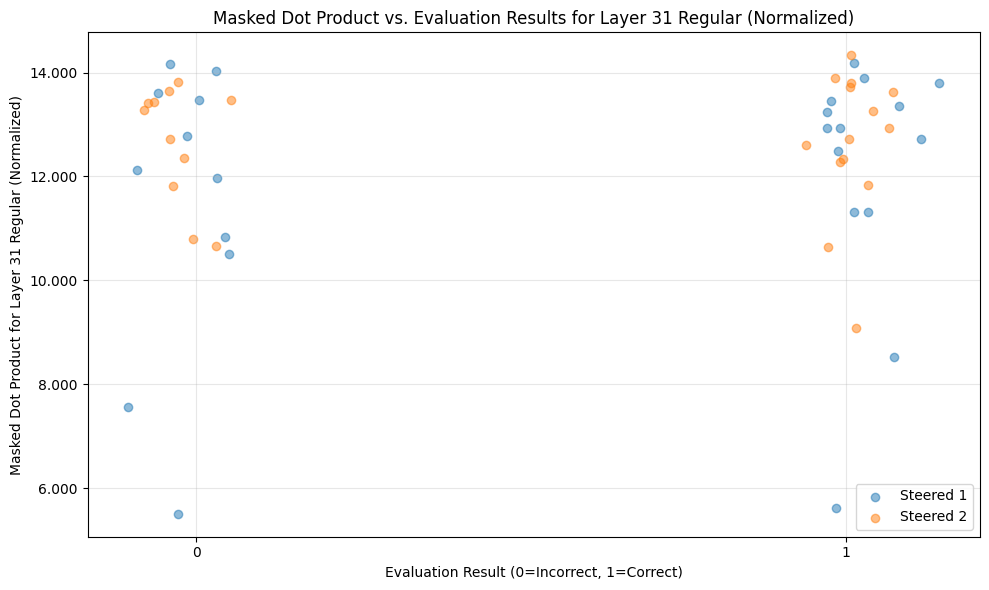


Statistics for Layer 31 Regular - Steered 1:
Average dot product for correct answers: 12.1262
Average dot product for incorrect answers: 11.5055
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average dot product for correct answers: 12.6470
Average dot product for incorrect answers: 12.6709
Number of correct answers: 14
Number of incorrect answers: 11


In [45]:
# For normalized dot products:
calculate_dot_product_masked(correct_df, use_normalized=True)

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


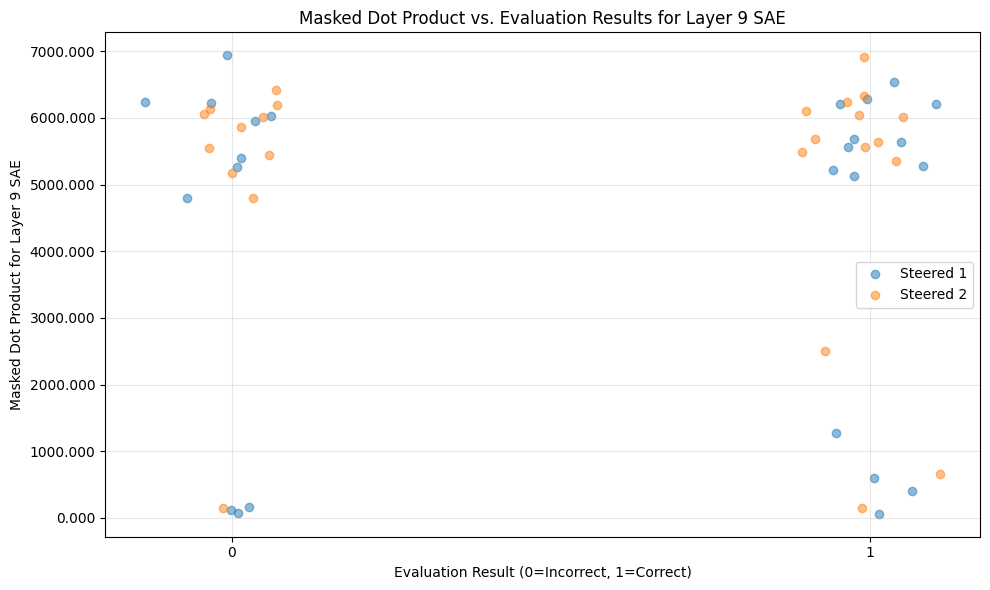


Statistics for Layer 9 SAE - Steered 1:
Average dot product for correct answers: 4292.6244
Average dot product for incorrect answers: 4290.5497
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 SAE - Steered 2:
Average dot product for correct answers: 4907.2180
Average dot product for incorrect answers: 5248.6288
Number of correct answers: 14
Number of incorrect answers: 11


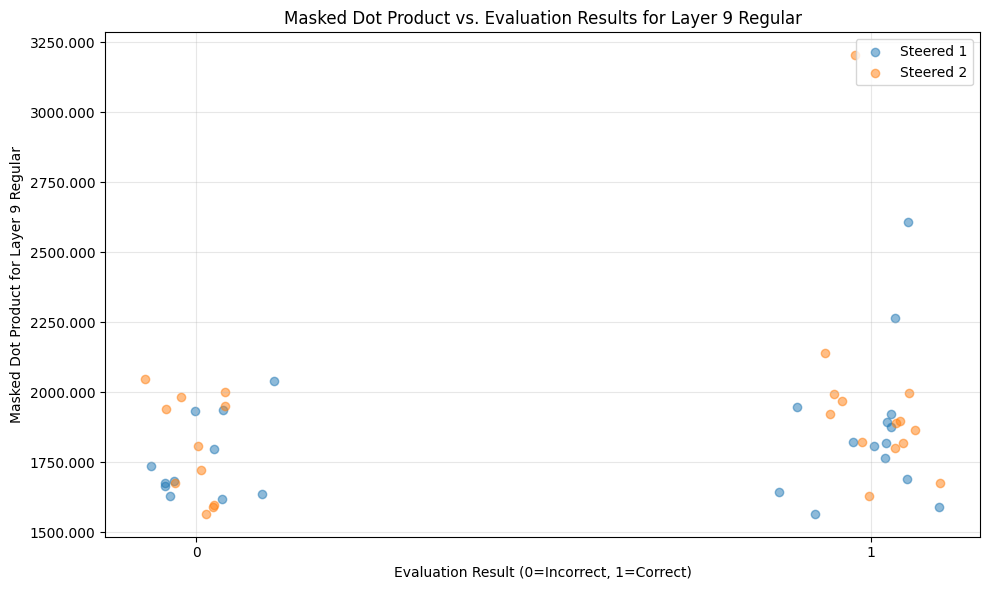


Statistics for Layer 9 Regular - Steered 1:
Average dot product for correct answers: 1872.5156
Average dot product for incorrect answers: 1759.2351
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 9 Regular - Steered 2:
Average dot product for correct answers: 1973.1491
Average dot product for incorrect answers: 1807.2112
Number of correct answers: 14
Number of incorrect answers: 11


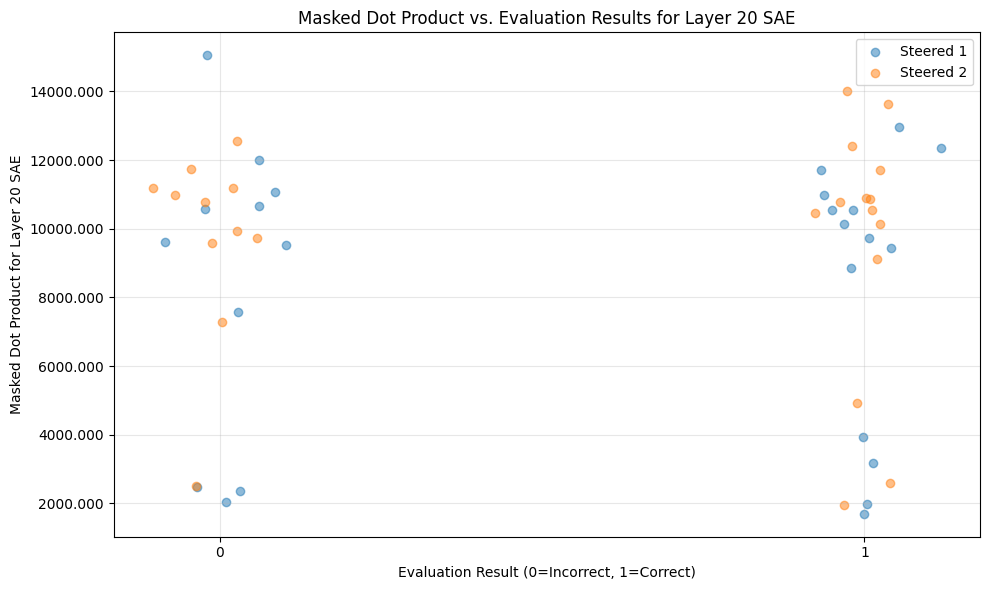


Statistics for Layer 20 SAE - Steered 1:
Average dot product for correct answers: 8436.0823
Average dot product for incorrect answers: 8448.5164
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 SAE - Steered 2:
Average dot product for correct answers: 9572.4407
Average dot product for incorrect answers: 9765.9927
Number of correct answers: 14
Number of incorrect answers: 11


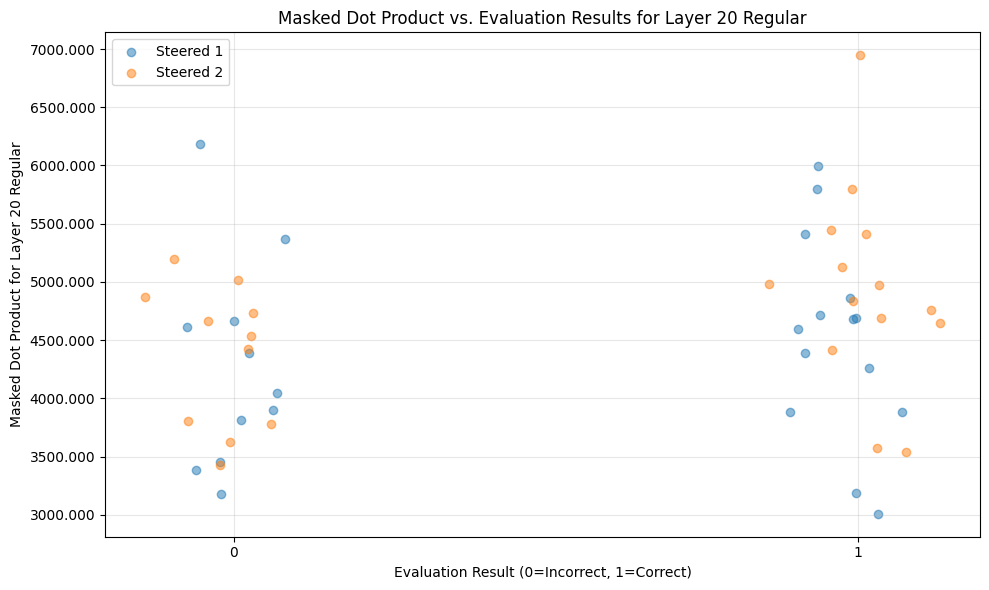


Statistics for Layer 20 Regular - Steered 1:
Average dot product for correct answers: 4526.5922
Average dot product for incorrect answers: 4273.6338
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 20 Regular - Steered 2:
Average dot product for correct answers: 4940.1991
Average dot product for incorrect answers: 4371.7591
Number of correct answers: 14
Number of incorrect answers: 11


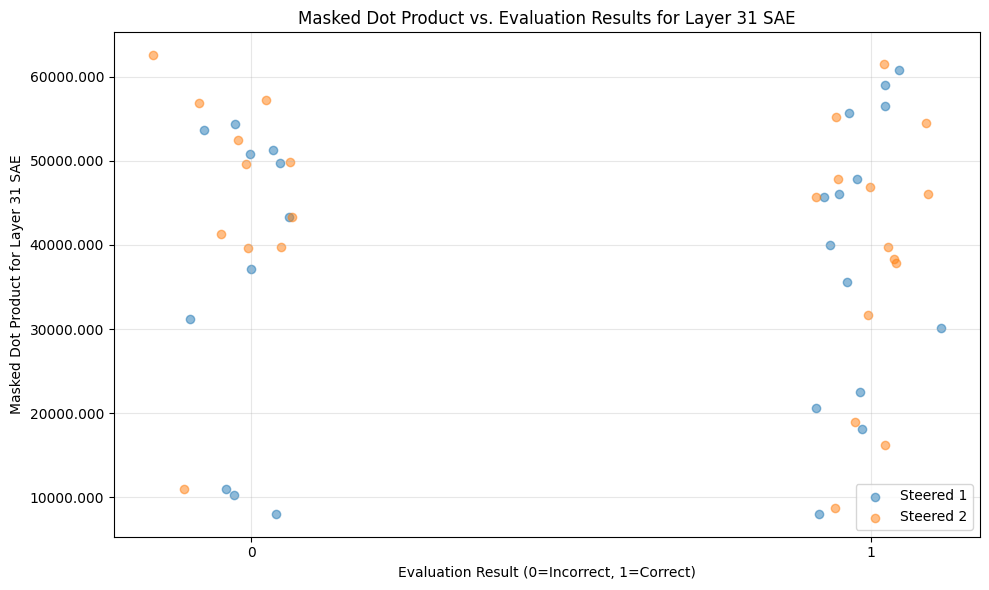


Statistics for Layer 31 SAE - Steered 1:
Average dot product for correct answers: 39037.6142
Average dot product for incorrect answers: 36442.5475
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 SAE - Steered 2:
Average dot product for correct answers: 39226.6806
Average dot product for incorrect answers: 45758.4269
Number of correct answers: 14
Number of incorrect answers: 11


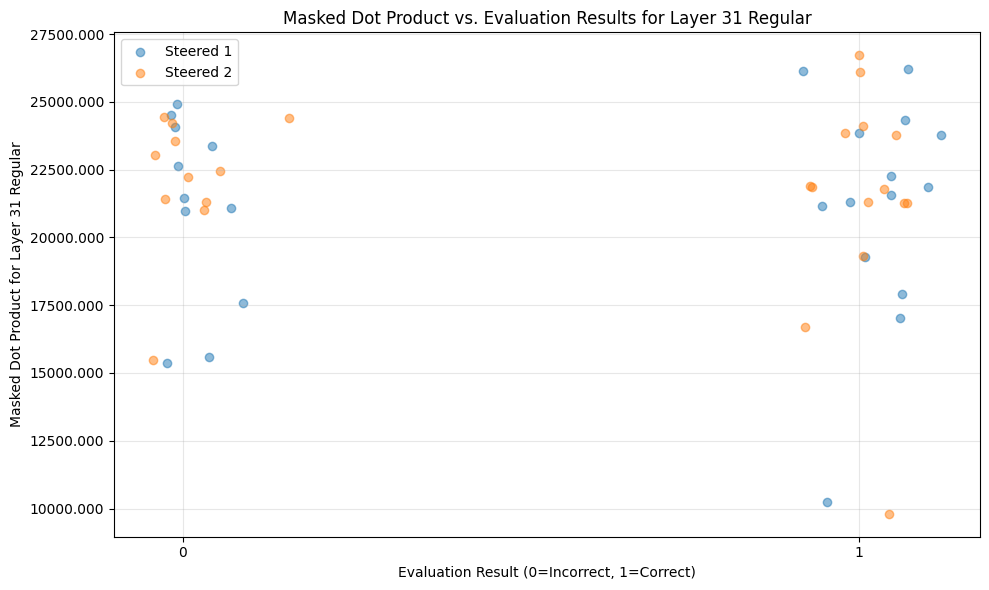


Statistics for Layer 31 Regular - Steered 1:
Average dot product for correct answers: 21211.5866
Average dot product for incorrect answers: 21048.8002
Number of correct answers: 14
Number of incorrect answers: 11

Statistics for Layer 31 Regular - Steered 2:
Average dot product for correct answers: 21413.1057
Average dot product for incorrect answers: 22143.1398
Number of correct answers: 14
Number of incorrect answers: 11


In [46]:

# For regular dot products:
calculate_dot_product_masked(correct_df, use_normalized=False)

### Distribution of Dot Products in Dataset

##### Function Definitions

In [ ]:
def calculate_and_store_dot_products(df):
    """
    Calculate dot products between unsteered and steered answers and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
    
    Returns:
        pandas DataFrame containing all dot products
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    
    # Initialize lists to store data
    data = []
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate dot products for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names
                unsteered_col = f'{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                steered1_col = f'{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                steered2_col = f'{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get vectors
                    unsteered_vec = df[unsteered_col].iloc[prompt_id]
                    steered1_vec = df[steered1_col].iloc[prompt_id]
                    steered2_vec = df[steered2_col].iloc[prompt_id]
                    
                    # Calculate dot products
                    steered1_dot = calculate_dot_product(unsteered_vec, steered1_vec)
                    steered2_dot = calculate_dot_product(unsteered_vec, steered2_vec)
                    
                    # Store dot products in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dot'] = steered1_dot
                    row_data[f'{col_prefix}_layer{layer}_steered2_dot'] = steered2_dot
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dot'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_dot'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    dot_products_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        dot_products_df['source_folder'] = df['source_folder']
    
    return dot_products_df


In [84]:

def analyze_dot_productsv2(dot_products_df):
    """
    Analyze and visualize the distribution of dot products between unsteered and steered answers,
    combining both steered1 and steered2 into a single distribution.
    """
    # Create subplots for each layer
    layers = [9, 20, 31]
    types = ['SAE', 'Regular']
    
    fig, axes = plt.subplots(len(layers), len(types), figsize=(15, 4*len(layers)))
    fig.suptitle('Distribution of Dot Products by Layer and Evaluation Result', fontsize=16, y=1.02)
    
    # Initialize list for statistics
    stats_data = []
    
    for i, layer in enumerate(layers):
        for j, type_name in enumerate(types):
            # Get columns for this layer and type
            prefix = type_name
            steered1_col = f'{prefix}_layer{layer}_steered1_dot'
            steered2_col = f'{prefix}_layer{layer}_steered2_dot'
            
            # Combine data from both steered versions
            all_dot_products = []
            all_correctness = []
            
            # Process steered1 data
            if steered1_col in dot_products_df.columns:
                correctness1 = dot_products_df['evaluation'].apply(lambda x: int(x[1]))
                dot_products1 = dot_products_df[steered1_col]
                all_dot_products.extend(dot_products1)
                all_correctness.extend(correctness1)
            
            # Process steered2 data
            if steered2_col in dot_products_df.columns:
                correctness2 = dot_products_df['evaluation'].apply(lambda x: int(x[2]))
                dot_products2 = dot_products_df[steered2_col]
                all_dot_products.extend(dot_products2)
                all_correctness.extend(correctness2)
            
            # Convert to numpy arrays for easier processing
            all_dot_products = np.array(all_dot_products)
            all_correctness = np.array(all_correctness)
            
            # Separate correct and incorrect
            correct_values = all_dot_products[all_correctness == 1]
            incorrect_values = all_dot_products[all_correctness == 0]
            
            # Plot distributions
            if len(correct_values) > 0:
                sns.histplot(data=correct_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='green', 
                           label=f'Correct (n={len(correct_values)})')
                mean_correct = correct_values.mean()
                axes[i,j].axvline(mean_correct, color='green', linestyle='--',
                                label=f'Mean Correct: {mean_correct:.2f}')
            
            if len(incorrect_values) > 0:
                sns.histplot(data=incorrect_values, kde=True, ax=axes[i,j], 
                           alpha=0.5, color='red',
                           label=f'Incorrect (n={len(incorrect_values)})')
                mean_incorrect = incorrect_values.mean()
                axes[i,j].axvline(mean_incorrect, color='red', linestyle='--',
                                label=f'Mean Incorrect: {mean_incorrect:.2f}')
            
            axes[i,j].set_title(f'{type_name} Layer {layer}')
            axes[i,j].set_xlabel('Dot Product')
            axes[i,j].set_ylabel('Count')
            axes[i,j].legend()
            
            # Store statistics
            if len(correct_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Correct',
                    'Mean': correct_values.mean(),
                    'Std': correct_values.std(),
                    'Count': len(correct_values)
                })
            
            if len(incorrect_values) > 0:
                stats_data.append({
                    'Layer': layer,
                    'Type': type_name,
                    'Correctness': 'Incorrect',
                    'Mean': incorrect_values.mean(),
                    'Std': incorrect_values.std(),
                    'Count': len(incorrect_values)
                })
    
    plt.tight_layout()
    plt.show()
    
    # Create and return statistics DataFrame
    return pd.DataFrame(stats_data)

##### Output

In [85]:
dotProd_df = calculate_and_store_dot_products(correct_df)
print(dotProd_df.head())

NameError: name 'calculate_and_store_dot_products' is not defined

In [ ]:
stats_cos_df = analyze_dot_productsv2(dotProd_df)

In [ ]:
# Further analyze specific combinations
stats_cos_df_sae = stats_cos_df[stats_cos_df['Type'] == 'SAE']
print("\nSAE Statistics:")
print(stats_cos_df_sae.to_string(index=False))

#### Using only top activations

##### Function Definition

In [ ]:
def calculate_and_store_dot_products_masked(df, use_normalized=False, use_individual_tops=False):
    """
    Calculate dot products between unsteered and steered answers for top activations and store in DataFrame.
    
    Args:
        df: DataFrame containing the activation data
        use_normalized: Boolean to toggle between normalized and non-normalized dot products
        use_individual_tops: Boolean to toggle between using masked (False) or individual (True) top activations
    
    Returns:
        pandas DataFrame containing all dot products for top activations
    """
    layers = [9, 20, 31]
    activation_types = ['SAE_', '']
    vector_length = 131072  # Full vector length for masked calculation
    
    # Initialize lists to store data
    data = []
    
    def calculate_masked_dot_product(vec1_data, vec2_data):
        """Calculate dot product using masked approach"""
        # Initialize vectors with zeros
        vec1 = np.zeros(vector_length)
        vec2 = np.zeros(vector_length)
        
        # Fill in the extracted activations
        for idx, val in vec1_data:
            vec1[idx] = val
        for idx, val in vec2_data:
            vec2[idx] = val
            
        if use_normalized:
            # Normalize vectors to [-1, 1]
            vec1_range = vec1.max() - vec1.min()
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            
            vec2_range = vec2.max() - vec2.min()
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate dot product
        return np.dot(vec1, vec2)
    
    def calculate_individual_dot_product(vec1_data, vec2_data):
        """Calculate dot product using individual top activations"""
        # Create dictionaries for easy lookup
        dict1 = dict(vec1_data)
        dict2 = dict(vec2_data)
        
        # Get all unique indices
        all_indices = set(dict1.keys()) | set(dict2.keys())
        
        # Create vectors only for the relevant indices
        vec1 = np.array([dict1.get(idx, 0.0) for idx in all_indices])
        vec2 = np.array([dict2.get(idx, 0.0) for idx in all_indices])
        
        if use_normalized and len(vec1) > 0:
            # Normalize vectors to [-1, 1]
            vec1_range = vec1.max() - vec1.min()
            if vec1_range != 0:
                vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1
            
            vec2_range = vec2.max() - vec2.min()
            if vec2_range != 0:
                vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1
        
        # Calculate dot product
        return np.dot(vec1, vec2)
    
    # Process each prompt
    for prompt_id in range(len(df)):
        row_data = {
            'prompt_id': prompt_id,
            'evaluation': df['evaluation'].iloc[prompt_id]
        }
        
        # Calculate dot products for each layer and activation type
        for layer in layers:
            for act_type in activation_types:
                # Define column names for top activations
                if use_individual_tops:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Top_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Top_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                else:
                    unsteered_col = f'Top_20_{act_type}Activations_Answer_No_Steering_layer{layer}_lastForwardPass'
                    steered1_col = f'Steered1_20_{act_type}Activations_Answer_Steered1_layer{layer}_lastForwardPass'
                    steered2_col = f'Steered2_20_{act_type}Activations_Answer_Steered2_layer{layer}_lastForwardPass'
                
                try:
                    # Get activation data
                    unsteered_data = df[unsteered_col].iloc[prompt_id]
                    steered1_data = df[steered1_col].iloc[prompt_id]
                    steered2_data = df[steered2_col].iloc[prompt_id]
                    
                    if any(data is None for data in [unsteered_data, steered1_data, steered2_data]):
                        continue
                    
                    # Calculate dot products using selected method
                    if use_individual_tops:
                        steered1_dot = calculate_individual_dot_product(unsteered_data, steered1_data)
                        steered2_dot = calculate_individual_dot_product(unsteered_data, steered2_data)
                    else:
                        steered1_dot = calculate_masked_dot_product(unsteered_data, steered1_data)
                        steered2_dot = calculate_masked_dot_product(unsteered_data, steered2_data)
                    
                    # Store dot products in row_data
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dot'] = steered1_dot
                    row_data[f'{col_prefix}_layer{layer}_steered2_dot'] = steered2_dot
                    
                except Exception as e:
                    print(f"Error processing prompt {prompt_id}, {act_type}layer{layer}: {e}")
                    # Store NaN for failed calculations
                    col_prefix = 'SAE' if act_type == 'SAE_' else 'Regular'
                    row_data[f'{col_prefix}_layer{layer}_steered1_dot'] = np.nan
                    row_data[f'{col_prefix}_layer{layer}_steered2_dot'] = np.nan
        
        data.append(row_data)
    
    # Create DataFrame from collected data
    dot_products_df = pd.DataFrame(data)
    
    # Add source folder information if available
    if 'source_folder' in df.columns:
        dot_products_df['source_folder'] = df['source_folder']
    
    return dot_products_df

##### Output

In [ ]:
# For masked approach
dot_products_df_masked = calculate_and_store_dot_products_masked(correct_df, use_normalized=False, use_individual_tops=False)



In [ ]:
# Analyze and visualize the results
stats_dot_masked_df = analyze_dot_productsv2(dot_products_df_masked)

In [ ]:
# For individual top activations approach
dot_products_df_tops = calculate_and_store_dot_products_masked(correct_df, use_normalized=False, use_individual_tops=True)

In [ ]:
# Analyze and visualize the results
stats_dot_tops_df = analyze_dot_productsv2(dot_products_df_tops)

# Top latent and overlapping latent analysis for individual prompts

took code from LetsDriftGemma2_Hooked_continued.ipynb

## define row numer

In [47]:
row_num = 0
import plotly.express as px

In [48]:
#row = correct_df['Top_Activations_No_Steering'].iloc[row_number]

In [49]:
#print(row)

## Define a bunch of plotting functions

In [50]:
"""def plot_activations_comparison(df, row_number):
    
    Create a bar plot comparing top activations between unsteered and steered responses.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
    
    import plotly.express as px
    import plotly.graph_objects as go
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Create figure
    fig = go.Figure()
    
    # Process and add traces for each set of activations
    for name, activations, color in [
        ("No Steering", row['Top_Activations_No_Steering'], '#1f77b4'),
        ("Steered 0", row['Top_Activations_Steered0'], '#ff7f0e'),
        ("Steered 1", row['Top_Activations_Steered1'], '#ff7f0e') # for a different colour: 2ca02c
    ]:
        # Extract indices and values
        indices = [pair[0] for pair in activations]
        values = [pair[1] for pair in activations]
        
        # Add bar plot
        fig.add_trace(go.Bar(
            x=indices,
            y=values,
            name=name,
            marker_color=color,
            width=100  # Adjust bar width as needed
        ))
    
    # Update layout
    fig.update_layout(
        title=f"Top Latent Activations Comparison (Row {row_number})",
        xaxis_title="Latent Index",
        yaxis_title="Activation Value",
        width=1000,
        showlegend=True,
        barmode='group'  # Group bars for each latent index
    )
    
    # Show the plot
    fig.show()
    
    # Print evaluation results
    print(f"\nEvaluation results: {row['evaluation']}")
    
    # Print top 3 activations for each
    print("\nTop 3 activations for each generation:")
    for name, activations in [
        ("No Steering", row['Top_Activations_No_Steering']),
        ("Steered 0", row['Top_Activations_Steered0']),
        ("Steered 1", row['Top_Activations_Steered1'])
    ]:
        print(f"\n{name}:")
        for idx, val in activations[:3]:  # Take first 3 pairs
            print(f"Latent {idx} had activation {val:.2f}")
"""

'def plot_activations_comparison(df, row_number):\n    \n    Create a bar plot comparing top activations between unsteered and steered responses.\n    \n    Args:\n        df: DataFrame containing the activation data\n        row_number: Index of the row to analyze\n    \n    import plotly.express as px\n    import plotly.graph_objects as go\n    \n    # Get the row data\n    row = df.iloc[row_number]\n    \n    # Create figure\n    fig = go.Figure()\n    \n    # Process and add traces for each set of activations\n    for name, activations, color in [\n        ("No Steering", row[\'Top_Activations_No_Steering\'], \'#1f77b4\'),\n        ("Steered 0", row[\'Top_Activations_Steered0\'], \'#ff7f0e\'),\n        ("Steered 1", row[\'Top_Activations_Steered1\'], \'#ff7f0e\') # for a different colour: 2ca02c\n    ]:\n        # Extract indices and values\n        indices = [pair[0] for pair in activations]\n        values = [pair[1] for pair in activations]\n        \n        # Add bar plot\n   

In [51]:
def plot_activations_comparison_v2(df, row_number, layer_num=9, top_n=10):
    """
    Create a bar plot comparing activations between unsteered and steered responses
    for a specific layer's last forward pass.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
        layer_num: Layer number to analyze (default=9)
        top_n: Number of top activations to consider from each vector (default=10)
    """
    import plotly.graph_objects as go
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Create figure
    fig = go.Figure()
    
    # Define column names for the layer
    cols = [
        f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass',
        f'SAE_Activations_Answer_Steered1_layer{layer_num}_lastForwardPass',
        f'SAE_Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
    ]
    
    # Get top N activations from each vector
    def get_top_activations(vector_data, n=top_n):  # Changed default n to use top_n parameter
        # Convert to numpy array if it's not already
        if isinstance(vector_data, str):
            # If the data is stored as a string, evaluate it
            vector = np.array(eval(vector_data))
        elif isinstance(vector_data, list):
            # If the data is already a list
            vector = np.array(vector_data)
        else:
            # If it's already a numpy array
            vector = vector_data
            
        indices = np.argsort(vector)[-n:]
        return list(zip(indices, vector[indices]))
    
    # Collect all unique indices with significant activations
    all_indices = set()
    for col in cols:
        try:
            activations = get_top_activations(row[col])
            indices = [pair[0] for pair in activations]
            all_indices.update(indices)
        except Exception as e:
            print(f"Error processing column {col}: {e}")
            print(f"Data type: {type(row[col])}")
            print(f"Value: {row[col][:100]}..." if isinstance(row[col], str) else row[col])
            continue
    
    # Sort indices for consistent x-axis
    all_indices = sorted(list(all_indices))
    
    # Process and add traces for each set of activations
    for name, col, color in [
        ("No Steering", cols[0], '#1f77b4'),
        ("Steered 1", cols[1], '#ff7f0e'),
        ("Steered 2", cols[2], '#FF550E')
    ]:
        try:
            # Convert data to numpy array
            if isinstance(row[col], str):
                vector = np.array(eval(row[col]))
            elif isinstance(row[col], list):
                vector = np.array(row[col])
            else:
                vector = row[col]
                
            # Get values for the indices
            values = [vector[idx] for idx in all_indices]
            
            # Add bar plot
            fig.add_trace(go.Bar(
                x=[str(idx) for idx in all_indices],
                y=values,
                name=name,
                marker_color=color,
                width=0.2
            ))
        except Exception as e:
            print(f"Error processing {name}: {e}")
            continue
    
    # Update layout
    fig.update_layout(
        title=f"Top {top_n} Latent Activations Comparison - Layer {layer_num} (Row {row_number})",
        xaxis_title="Latent Index",
        yaxis_title="Activation Value",
        width=1000,
        showlegend=True,
        barmode='group',
        xaxis=dict(
            tickangle=45,
            type='category'
        )
    )
    
    # Show the plot
    fig.show()
    
    # Print evaluation results with explanation
    eval_result = row['evaluation']
    print("\nEvaluation results [unsteered, steered1, steered2]:")
    print(f"{eval_result} (1 = correct, 0 = incorrect)")
    
    # Add interpretation of evaluation results
    if isinstance(eval_result, list) and len(eval_result) >= 3:
        print("\nInterpretation:")
        print(f"Unsteered answer: {'Correct' if eval_result[0] == '1' else 'Incorrect'}")
        print(f"Steered1 answer: {'Correct' if eval_result[1] == '1' else 'Incorrect'}")
        print(f"Steered2 answer: {'Correct' if eval_result[2] == '1' else 'Incorrect'}")
    
    # Print top 3 activations for each (keeping this at 3 for readability)
    print(f"\nTop 3 activations for Layer {layer_num}:")
    for name, col in [
        ("No Steering", cols[0]),
        ("Steered 1", cols[1]),
        ("Steered 2", cols[2])
    ]:
        try:
            if isinstance(row[col], str):
                vector = np.array(eval(row[col]))
            elif isinstance(row[col], list):
                vector = np.array(row[col])
            else:
                vector = row[col]
            activations = get_top_activations(vector, 3)  # Keep this at 3 for readability
            print(f"\n{name}:")
            for idx, val in activations:
                print(f"Latent {idx} had activation {val:.2f}")
        except Exception as e:
            print(f"Error processing {name}: {e}")

In [52]:
def plot_activations_comparison_all_layers_separate(df, row_number, top_n=10):
    """
    Create separate plots for steered1 and steered2, comparing their activations with unsteered
    across all layers for the top N latents from the unsteered answer.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
        top_n: Number of top activations to consider from unsteered vector (default=10)
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Define layers
    layers = [9, 20, 31]
    
    def get_top_activations(vector_data, n=top_n):
        if isinstance(vector_data, str):
            vector = np.array(eval(vector_data))
        elif isinstance(vector_data, list):
            vector = np.array(vector_data)
        else:
            vector = vector_data
            
        indices = np.argsort(vector)[-n:][::-1]  # Reverse to get descending order
        return list(zip(indices, vector[indices]))
    
    # Process each steered version separately
    for steered_version in [1, 2]:
        # Create subplots for this steered version
        fig = make_subplots(rows=len(layers), cols=1, 
                           subplot_titles=[f"Layer {layer}" for layer in layers],
                           vertical_spacing=0.1)
        
        # Process each layer
        for i, layer_num in enumerate(layers, 1):
            # Get unsteered column for this layer
            unsteered_col = f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass'
            steered_col = f'SAE_Activations_Answer_Steered{steered_version}_layer{layer_num}_lastForwardPass'
            
            try:
                # Get unsteered vector and its top indices
                if isinstance(row[unsteered_col], str):
                    unsteered_vector = np.array(eval(row[unsteered_col]))
                elif isinstance(row[unsteered_col], list):
                    unsteered_vector = np.array(row[unsteered_col])
                else:
                    unsteered_vector = row[unsteered_col]
                
                # Get top indices from unsteered vector
                top_activations = get_top_activations(unsteered_vector)
                indices = [pair[0] for pair in top_activations]
                
                # Get steered vector
                if isinstance(row[steered_col], str):
                    steered_vector = np.array(eval(row[steered_col]))
                elif isinstance(row[steered_col], list):
                    steered_vector = np.array(row[steered_col])
                else:
                    steered_vector = row[steered_col]
                
                # Get values for the indices
                unsteered_values = [unsteered_vector[idx] for idx in indices]
                steered_values = [steered_vector[idx] for idx in indices]
                
                # Add bar plots
                fig.add_trace(
                    go.Bar(
                        x=[str(idx) for idx in indices],
                        y=unsteered_values,
                        name="No Steering",
                        marker_color='#1f77b4',
                        width=0.2,
                        showlegend=(i == 1)
                    ),
                    row=i, col=1
                )
                
                fig.add_trace(
                    go.Bar(
                        x=[str(idx) for idx in indices],
                        y=steered_values,
                        name=f"Steered {steered_version}",
                        marker_color='#ff7f0e',
                        width=0.2,
                        showlegend=(i == 1)
                    ),
                    row=i, col=1
                )
                
            except Exception as e:
                print(f"Error processing layer {layer_num}: {e}")
                continue
        
        # Update layout
        fig.update_layout(
            title=f"Top {top_n} Unsteered Latents vs Steered{steered_version} (Row {row_number})",
            height=1200,
            width=1000,
            showlegend=True,
            barmode='group'
        )
        
        # Update x-axes
        for i in range(len(layers)):
            fig.update_xaxes(tickangle=45, type='category', row=i+1, col=1)
            fig.update_yaxes(title_text="Activation Value", row=i+1, col=1)
        
        # Show the plot
        fig.show()
    
    # Print evaluation results with explanation
    eval_result = row['evaluation']
    print("\nEvaluation results [unsteered, steered1, steered2]:")
    print(f"{eval_result} (1 = correct, 0 = incorrect)")
    
    # Add interpretation of evaluation results
    if isinstance(eval_result, list) and len(eval_result) >= 3:
        print("\nInterpretation:")
        print(f"Unsteered answer: {'Correct' if eval_result[0] == '1' else 'Incorrect'}")
        print(f"Steered1 answer: {'Correct' if eval_result[1] == '1' else 'Incorrect'}")
        print(f"Steered2 answer: {'Correct' if eval_result[2] == '1' else 'Incorrect'}")
    
    # Print top activations for each layer
    for layer_num in layers:
        print(f"\nTop {top_n} activations for Layer {layer_num}:")
        unsteered_col = f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass'
        try:
            if isinstance(row[unsteered_col], str):
                vector = np.array(eval(row[unsteered_col]))
            elif isinstance(row[unsteered_col], list):
                vector = np.array(row[unsteered_col])
            else:
                vector = row[unsteered_col]
            activations = get_top_activations(vector, top_n)
            print(f"\nNo Steering:")
            for idx, val in activations:
                print(f"Latent {idx} had activation {val:.2f}")
        except Exception as e:
            print(f"Error processing No Steering: {e}")

### Result1: Complete overview (quite useless with 131k features, hard to recognize anyhting..)

In [53]:
#plot_activations_comparison(correct_df, row_num)  

### Result 2: Reduced x-axis to relevant data

In [54]:
row_num=0
plot_activations_comparison_v2(correct_df, row_num, top_n=20)  # Replace 0 with any row number you want to analyze


Evaluation results [unsteered, steered1, steered2]:
['1', '1', '1'] (1 = correct, 0 = incorrect)

Interpretation:
Unsteered answer: Correct
Steered1 answer: Correct
Steered2 answer: Correct

Top 3 activations for Layer 9:

No Steering:
Latent 104959 had activation 22.79
Latent 120222 had activation 28.26
Latent 3879 had activation 50.64

Steered 1:
Latent 27493 had activation 18.61
Latent 129489 had activation 36.40
Latent 120550 had activation 40.00

Steered 2:
Latent 61982 had activation 17.43
Latent 129489 had activation 33.84
Latent 120550 had activation 43.11


In [55]:
## New Result2b: Should top 10 across all hookpoint-layers together in one graph
def plot_activations_comparison_all_layers(df, row_number, top_n=10):
    """
    Create bar plots comparing activations between unsteered and steered responses
    for all layers' last forward passes.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
        top_n: Number of top activations to consider from each vector (default=10)
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Define layers
    layers = [9, 20, 31]
    
    # Create subplots - one for each layer
    fig = make_subplots(rows=len(layers), cols=1, 
                       subplot_titles=[f"Layer {layer}" for layer in layers],
                       vertical_spacing=0.1)
    
    def get_top_activations(vector_data, n=top_n):
        if isinstance(vector_data, str):
            vector = np.array(eval(vector_data))
        elif isinstance(vector_data, list):
            vector = np.array(vector_data)
        else:
            vector = vector_data
            
        indices = np.argsort(vector)[-n:]
        return list(zip(indices, vector[indices]))
    
    # Process each layer
    for i, layer_num in enumerate(layers, 1):
        # Define column names for the layer
        cols = [
            f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered1_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
        ]
        
        # Collect all unique indices with significant activations
        all_indices = set()
        for col in cols:
            try:
                activations = get_top_activations(row[col])
                indices = [pair[0] for pair in activations]
                all_indices.update(indices)
            except Exception as e:
                print(f"Error processing column {col}: {e}")
                continue
        
        # Sort indices for consistent x-axis
        all_indices = sorted(list(all_indices))
        
        # Process and add traces for each set of activations
        for name, col, color in [
            ("No Steering", cols[0], '#1f77b4'),
            ("Steered 1", cols[1], '#ff7f0e'),
            ("Steered 2", cols[2], '#FF550E')
        ]:
            try:
                # Convert data to numpy array
                if isinstance(row[col], str):
                    vector = np.array(eval(row[col]))
                elif isinstance(row[col], list):
                    vector = np.array(row[col])
                else:
                    vector = row[col]
                    
                # Get values for the indices
                values = [vector[idx] for idx in all_indices]
                
                # Add bar plot to appropriate subplot
                fig.add_trace(
                    go.Bar(
                        x=[str(idx) for idx in all_indices],
                        y=values,
                        name=name,
                        marker_color=color,
                        width=0.2,
                        showlegend=(i == 1)  # Only show legend for first subplot
                    ),
                    row=i, col=1
                )
            except Exception as e:
                print(f"Error processing {name}: {e}")
                continue
    
    # Update layout
    fig.update_layout(
        title=f"Top {top_n} Latent Activations Comparison Across Layers (Row {row_number})",
        height=1200,  # Increased height to accommodate all subplots
        width=1000,
        showlegend=True,
        barmode='group'
    )
    
    # Update x-axes
    for i in range(len(layers)):
        fig.update_xaxes(tickangle=45, type='category', row=i+1, col=1)
        fig.update_yaxes(title_text="Activation Value", row=i+1, col=1)
    
    # Show the plot
    fig.show()
    
    # Print evaluation results with explanation
    eval_result = row['evaluation']
    print("\nEvaluation results [unsteered, steered1, steered2]:")
    print(f"{eval_result} (1 = correct, 0 = incorrect)")
    
    # Add interpretation of evaluation results
    if isinstance(eval_result, list) and len(eval_result) >= 3:
        print("\nInterpretation:")
        print(f"Unsteered answer: {'Correct' if eval_result[0] == '1' else 'Incorrect'}")
        print(f"Steered1 answer: {'Correct' if eval_result[1] == '1' else 'Incorrect'}")
        print(f"Steered2 answer: {'Correct' if eval_result[2] == '1' else 'Incorrect'}")
    
    # Print top 3 activations for each layer
    for layer_num in layers:
        print(f"\nTop 3 activations for Layer {layer_num}:")
        cols = [
            f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered1_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
        ]
        for name, col in [
            ("No Steering", cols[0]),
            ("Steered 1", cols[1]),
            ("Steered 2", cols[2])
        ]:
            try:
                if isinstance(row[col], str):
                    vector = np.array(eval(row[col]))
                elif isinstance(row[col], list):
                    vector = np.array(row[col])
                else:
                    vector = row[col]
                activations = get_top_activations(vector, 3)
                print(f"\n{name}:")
                for idx, val in activations:
                    print(f"Latent {idx} had activation {val:.2f}")
            except Exception as e:
                print(f"Error processing {name}: {e}")

In [56]:

# Show top 20 latents for all layers
plot_activations_comparison_all_layers(correct_df, row_num, top_n=15)


Evaluation results [unsteered, steered1, steered2]:
['1', '1', '1'] (1 = correct, 0 = incorrect)

Interpretation:
Unsteered answer: Correct
Steered1 answer: Correct
Steered2 answer: Correct

Top 3 activations for Layer 9:

No Steering:
Latent 104959 had activation 22.79
Latent 120222 had activation 28.26
Latent 3879 had activation 50.64

Steered 1:
Latent 27493 had activation 18.61
Latent 129489 had activation 36.40
Latent 120550 had activation 40.00

Steered 2:
Latent 61982 had activation 17.43
Latent 129489 had activation 33.84
Latent 120550 had activation 43.11

Top 3 activations for Layer 20:

No Steering:
Latent 67884 had activation 35.17
Latent 26379 had activation 48.23
Latent 123033 had activation 67.29

Steered 1:
Latent 108678 had activation 29.50
Latent 51811 had activation 30.89
Latent 16573 had activation 35.60

Steered 2:
Latent 108678 had activation 33.85
Latent 26379 had activation 34.55
Latent 16573 had activation 36.20

Top 3 activations for Layer 31:

No Steering:
L

#### Print out individual prompt and answers by row number of correct_df

In [109]:
def print_prompt_and_answers(df, row_num):
    """
    Print the prompt and all answers (unsteered and steered) for a given row.
    
    Args:
        df: DataFrame containing the data
        row_num: Index of the row to analyze
    """
    row = df.iloc[row_num]
    
    print("="*80)
    print("PROMPT:")
    print("-"*80)
    print(row['Prompt'])  # Changed from 'prompt' to 'Prompt'
    print("\n")
    
    print("ANSWERS:")
    print("-"*80)
    print(f"Unsteered Answer (Evaluation: {row['evaluation'][0]}):")
    print(row['Answer_No_Steering'])
    print("\n")
    
    print(f"Steered Answer 1 (Evaluation: {row['evaluation'][1]}):")
    print(row['Answer_Steered1'])
    print("\n")
    
    print(f"Steered Answer 2 (Evaluation: {row['evaluation'][2]}):")
    print(row['Answer_Steered2'])
    print("="*80)

# Use the function with your row number
print_prompt_and_answers(correct_df, row_num)

PROMPT:
--------------------------------------------------------------------------------
What nationality were social anthropologists Alfred Gell and Edmund Leach?


ANSWERS:
--------------------------------------------------------------------------------
Unsteered Answer (Evaluation: 1):


Alfred Gell was **British**, and Edmund Leach was also **British**. 
<end_of_turn><eos>


Steered Answer 1 (Evaluation: 1):


* **Alfred Gell** was **British**.
* **Edmund Leach** was also **British**. 


Let's celebrate these influential figures in the field of social anthropology!<end_of_turn>
<eos>


Steered Answer 2 (Evaluation: 1):


* **Alfred Gell** was **British**.
* **Edmund Leach** was also **British**. 


Let me know if you have any other questions!<end_of_turn>
<eos>


## Result 3: Comparing the Top Latents of unsteered answer with their steered answer's corresponding latents:

In [57]:

# Show top 20 latents comparison
plot_activations_comparison_all_layers_separate(correct_df, row_num, top_n=20)


Evaluation results [unsteered, steered1, steered2]:
['1', '1', '1'] (1 = correct, 0 = incorrect)

Interpretation:
Unsteered answer: Correct
Steered1 answer: Correct
Steered2 answer: Correct

Top 20 activations for Layer 9:

No Steering:
Latent 3879 had activation 50.64
Latent 120222 had activation 28.26
Latent 104959 had activation 22.79
Latent 98395 had activation 14.91
Latent 129335 had activation 12.00
Latent 127994 had activation 9.45
Latent 114730 had activation 9.43
Latent 11970 had activation 8.45
Latent 398 had activation 8.08
Latent 7208 had activation 7.73
Latent 98306 had activation 7.58
Latent 34309 had activation 7.37
Latent 18308 had activation 6.76
Latent 99092 had activation 5.89
Latent 67198 had activation 5.32
Latent 54777 had activation 5.08
Latent 111661 had activation 4.96
Latent 22540 had activation 4.61
Latent 129426 had activation 4.60
Latent 73960 had activation 4.57

Top 20 activations for Layer 20:

No Steering:
Latent 123033 had activation 67.29
Latent 2637

In [58]:
#SANITY CHECK -- manually read out the activation value of a latent of a certain row
#row = correct_df.iloc[0]
#print(f"Activation value for latent 105608 in Steered0: {row['SAE_Activations_Steered1'][0][105608]}")


KeyError: 'SAE_Activations_Steered1'

# new approach for statistical method based on the graphs of 'result 3'

Manhattan distance/ cosine sim/ etc, based on the top 5-20 activating latents in the UNSTEERED answer. 

In [59]:
def plot_activations_comparison_all_layers(df, row_number, top_n=20):
    """
    Create bar plots comparing activations between unsteered and steered responses
    for all layers' last forward passes.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
        top_n: Number of top activations to consider from each vector (default=10)
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Define layers
    layers = [9, 20, 31]
    
    # Create subplots - one for each layer
    fig = make_subplots(rows=len(layers), cols=1, 
                       subplot_titles=[f"Layer {layer}" for layer in layers],
                       vertical_spacing=0.1)
    
    def get_top_activations(vector_data, n=top_n):
        if isinstance(vector_data, str):
            vector = np.array(eval(vector_data))
        elif isinstance(vector_data, list):
            vector = np.array(vector_data)
        else:
            vector = vector_data
            
        indices = np.argsort(vector)[-n:]
        return list(zip(indices, vector[indices]))
    
    # Process each layer
    for i, layer_num in enumerate(layers, 1):
        # Define column names for the layer
        cols = [
            f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered1_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
        ]
        
        # Collect all unique indices with significant activations
        all_indices = set()
        for col in cols:
            try:
                activations = get_top_activations(row[col])
                indices = [pair[0] for pair in activations]
                all_indices.update(indices)
            except Exception as e:
                print(f"Error processing column {col}: {e}")
                continue
        
        # Sort indices for consistent x-axis
        all_indices = sorted(list(all_indices))
        
        # Process and add traces for each set of activations
        for name, col, color in [
            ("No Steering", cols[0], '#1f77b4'),
            ("Steered 1", cols[1], '#ff7f0e'),
            ("Steered 2", cols[2], '#FF550E')
        ]:
            try:
                # Convert data to numpy array
                if isinstance(row[col], str):
                    vector = np.array(eval(row[col]))
                elif isinstance(row[col], list):
                    vector = np.array(row[col])
                else:
                    vector = row[col]
                    
                # Get values for the indices
                values = [vector[idx] for idx in all_indices]
                
                # Add bar plot to appropriate subplot
                fig.add_trace(
                    go.Bar(
                        x=[str(idx) for idx in all_indices],
                        y=values,
                        name=name,
                        marker_color=color,
                        width=0.2,
                        showlegend=(i == 1)  # Only show legend for first subplot
                    ),
                    row=i, col=1
                )
            except Exception as e:
                print(f"Error processing {name}: {e}")
                continue
    
    # Update layout
    fig.update_layout(
        title=f"Top {top_n} Latent Activations Comparison Across Layers (Row {row_number})",
        height=1200,  # Increased height to accommodate all subplots
        width=1000,
        showlegend=True,
        barmode='group'
    )
    
    # Update x-axes
    for i in range(len(layers)):
        fig.update_xaxes(tickangle=45, type='category', row=i+1, col=1)
        fig.update_yaxes(title_text="Activation Value", row=i+1, col=1)
    
    # Show the plot
    fig.show()
    
    # Print evaluation results with explanation
    eval_result = row['evaluation']
    print("\nEvaluation results [unsteered, steered1, steered2]:")
    print(f"{eval_result} (1 = correct, 0 = incorrect)")
    
    # Add interpretation of evaluation results
    if isinstance(eval_result, list) and len(eval_result) >= 3:
        print("\nInterpretation:")
        print(f"Unsteered answer: {'Correct' if eval_result[0] == '1' else 'Incorrect'}")
        print(f"Steered1 answer: {'Correct' if eval_result[1] == '1' else 'Incorrect'}")
        print(f"Steered2 answer: {'Correct' if eval_result[2] == '1' else 'Incorrect'}")
    
    # Print top 3 activations for each layer
    for layer_num in layers:
        print(f"\nTop 3 activations for Layer {layer_num}:")
        cols = [
            f'SAE_Activations_Answer_No_Steering_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered1_layer{layer_num}_lastForwardPass',
            f'SAE_Activations_Answer_Steered2_layer{layer_num}_lastForwardPass'
        ]
        for name, col in [
            ("No Steering", cols[0]),
            ("Steered 1", cols[1]),
            ("Steered 2", cols[2])
        ]:
            try:
                if isinstance(row[col], str):
                    vector = np.array(eval(row[col]))
                elif isinstance(row[col], list):
                    vector = np.array(row[col])
                else:
                    vector = row[col]
                activations = get_top_activations(vector, 3)
                print(f"\n{name}:")
                for idx, val in activations:
                    print(f"Latent {idx} had activation {val:.2f}")
            except Exception as e:
                print(f"Error processing {name}: {e}")

In [60]:
# Show top 20 latents for all layers
plot_activations_comparison_all_layers(correct_df, row_num, top_n=20)


Evaluation results [unsteered, steered1, steered2]:
['1', '1', '1'] (1 = correct, 0 = incorrect)

Interpretation:
Unsteered answer: Correct
Steered1 answer: Correct
Steered2 answer: Correct

Top 3 activations for Layer 9:

No Steering:
Latent 104959 had activation 22.79
Latent 120222 had activation 28.26
Latent 3879 had activation 50.64

Steered 1:
Latent 27493 had activation 18.61
Latent 129489 had activation 36.40
Latent 120550 had activation 40.00

Steered 2:
Latent 61982 had activation 17.43
Latent 129489 had activation 33.84
Latent 120550 had activation 43.11

Top 3 activations for Layer 20:

No Steering:
Latent 67884 had activation 35.17
Latent 26379 had activation 48.23
Latent 123033 had activation 67.29

Steered 1:
Latent 108678 had activation 29.50
Latent 51811 had activation 30.89
Latent 16573 had activation 35.60

Steered 2:
Latent 108678 had activation 33.85
Latent 26379 had activation 34.55
Latent 16573 had activation 36.20

Top 3 activations for Layer 31:

No Steering:
L

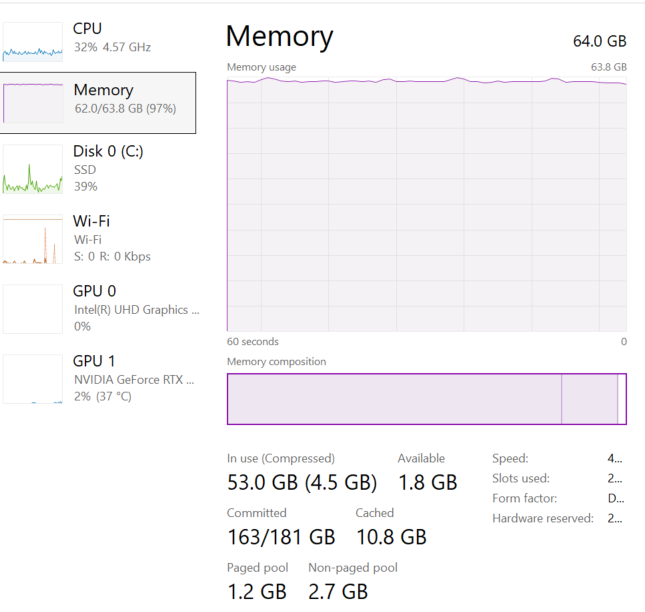